In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

# Monthly 90th Percentile Max Lead by ZIP Code (Grouped by Calendar Month)

## Goal  
This analysis visualizes the 90th percentile of maximum lead levels in water samples, aggregated by ZIP code and calendar month. By focusing on the 90th percentile rather than the mean, we target unusually high contamination levels that may pose a public health risk, even if infrequent. Mapping these values helps identify spatial and seasonal trends in lead exposure across Chicago.

## What the Code Does  
- **Loads** ZIP code boundaries for Chicago using GeoPandas  
- **Cleans** and prepares the lead sampling dataset:  
  - Parses sample dates  
  - Extracts 5-digit ZIP codes  
  - Converts lead values (`Max`) to numeric format  
- **Groups** the data by ZIP and month to compute the 90th percentile lead level (`Lead90`) for each combination  
- **Merges** the monthly statistics with spatial data  
- **Plots** a separate choropleth map for each calendar month, shading ZIP codes based on high lead levels  

## Interpretation  
The resulting series of 12 maps show how extreme lead concentrations vary month to month and by location. March exhibits a possible outlier ZIP with unusually high lead levels. In contrast, July appears more stable, with fewer ZIPs showing extreme contamination. This may indicate less volatility in summer sampling or a seasonal pattern in contamination sources.

## Key Insight  
Tracking high-percentile lead values monthly helps pinpoint high-risk areas and peak contamination times, aiding targeted interventions and policy planning.

In [3]:
import geopandas as gpd

# Load Chicago ZIP Code boundaries from public data source (City of Chicago Data Portal)
zip_url = "https://data.cityofchicago.org/api/geospatial/unjd-c2ca?method=export&format=GeoJSON"
gdf = gpd.read_file(zip_url)

# Preview the data
gdf.head()

objectid    zip     shape_area      shape_len  \
0        1  60607  64664294.2344  39143.6400726   
1        2  60661   9357755.8171  13132.5659184   
2        3  60606  6766410.78996  12040.4399607   
3        4  60615  66565454.6108  38321.3132699   
4        5  60643  207706232.893  75254.7301243   

                                            geometry  
0  MULTIPOLYGON (((-87.6474 41.88315, -87.6474 41...  
1  MULTIPOLYGON (((-87.64081 41.88908, -87.64068 ...  
2  MULTIPOLYGON (((-87.63696 41.88906, -87.63696 ...  
3  MULTIPOLYGON (((-87.58103 41.80421, -87.58089 ...  
4  MULTIPOLYGON (((-87.66326 41.7212, -87.66326 4...

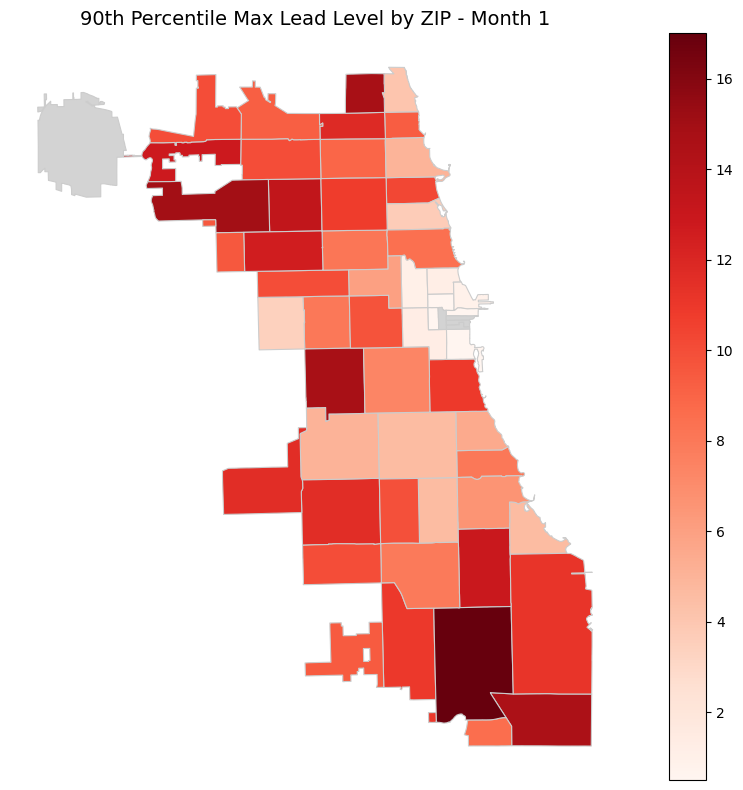

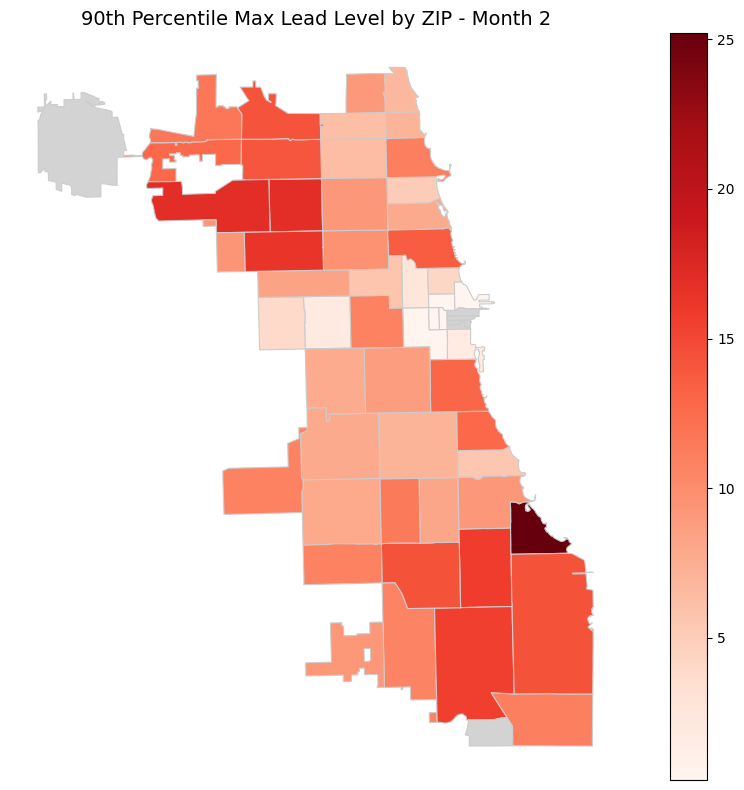

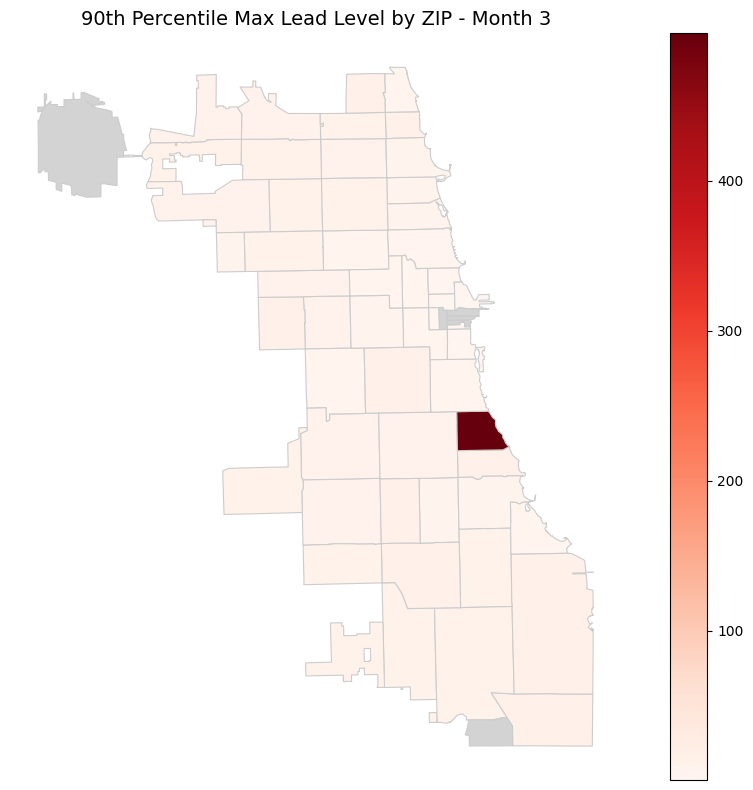

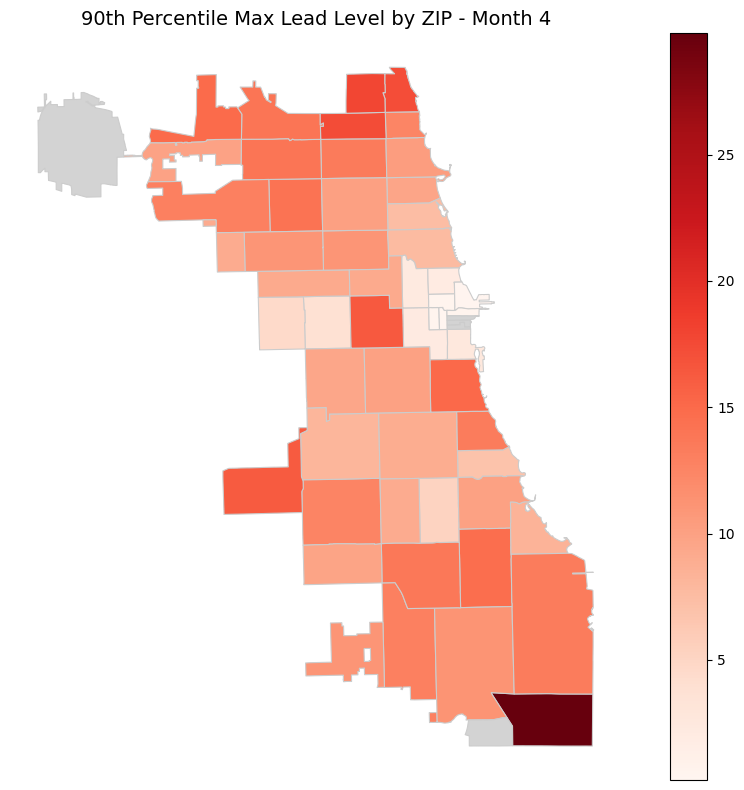

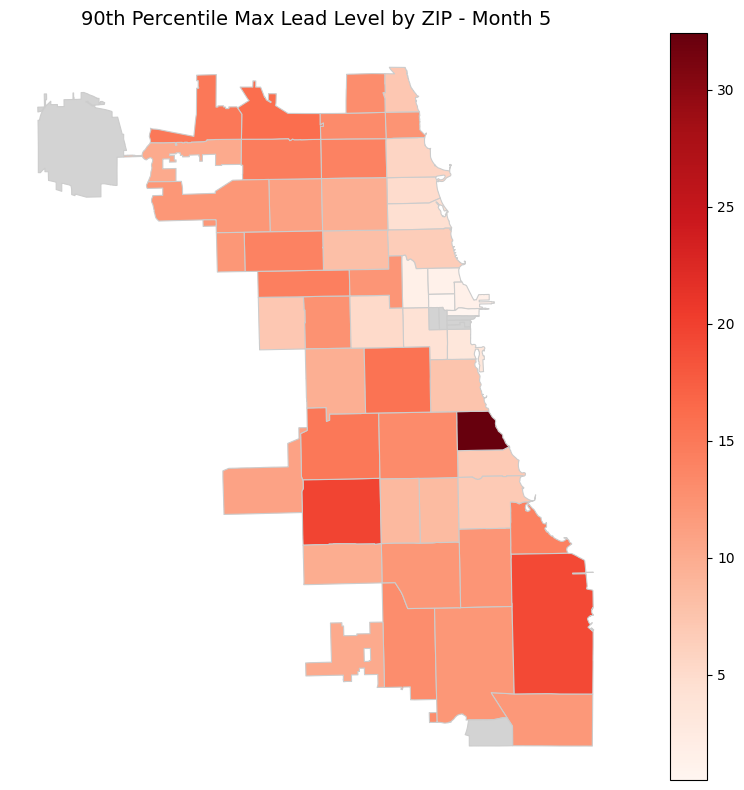

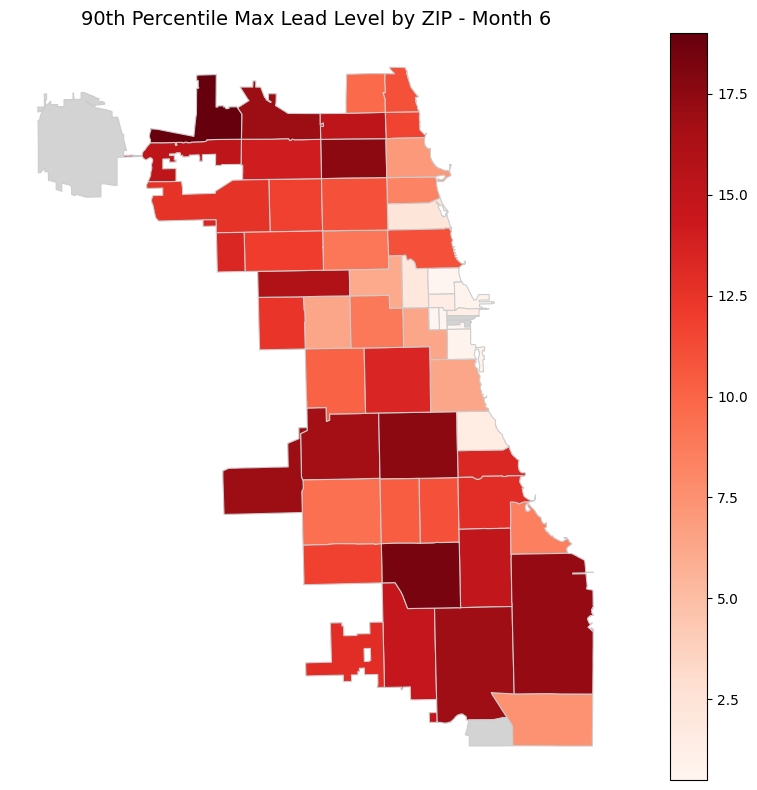

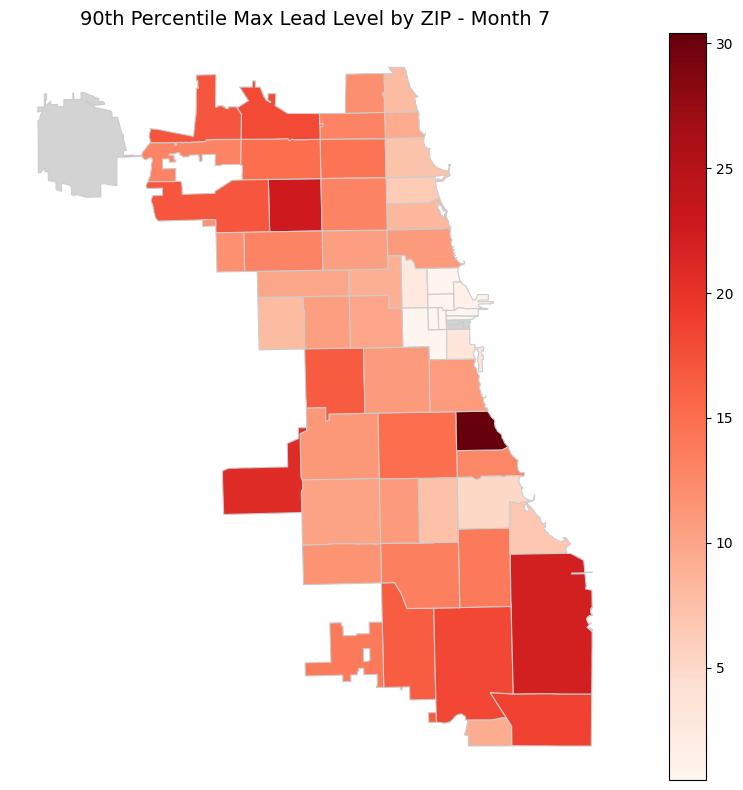

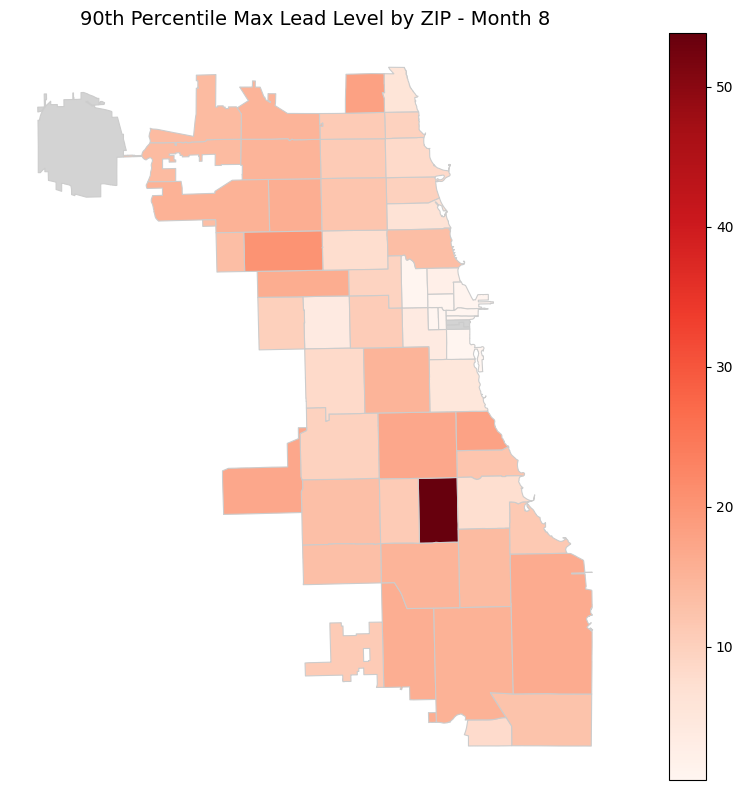

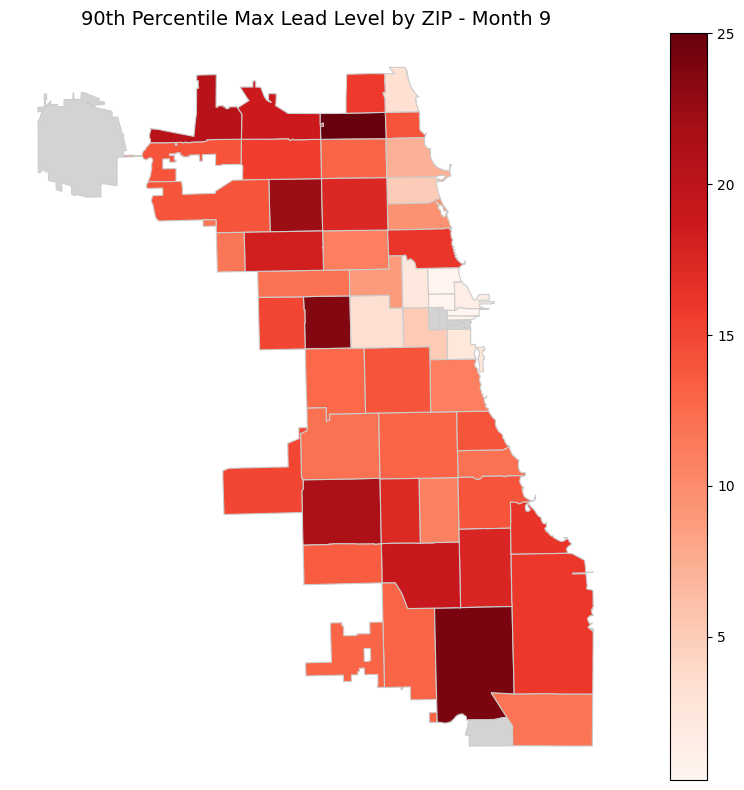

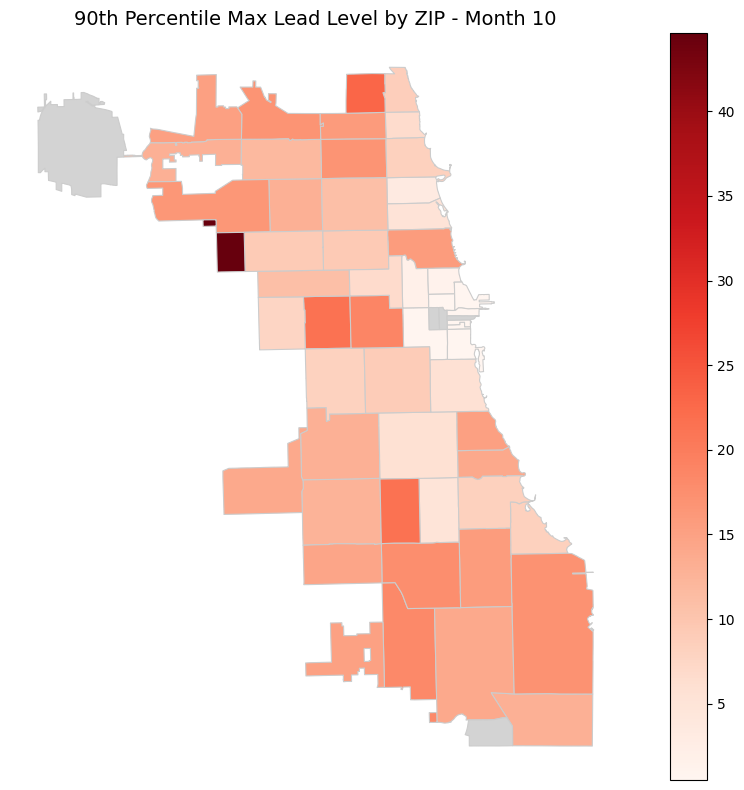

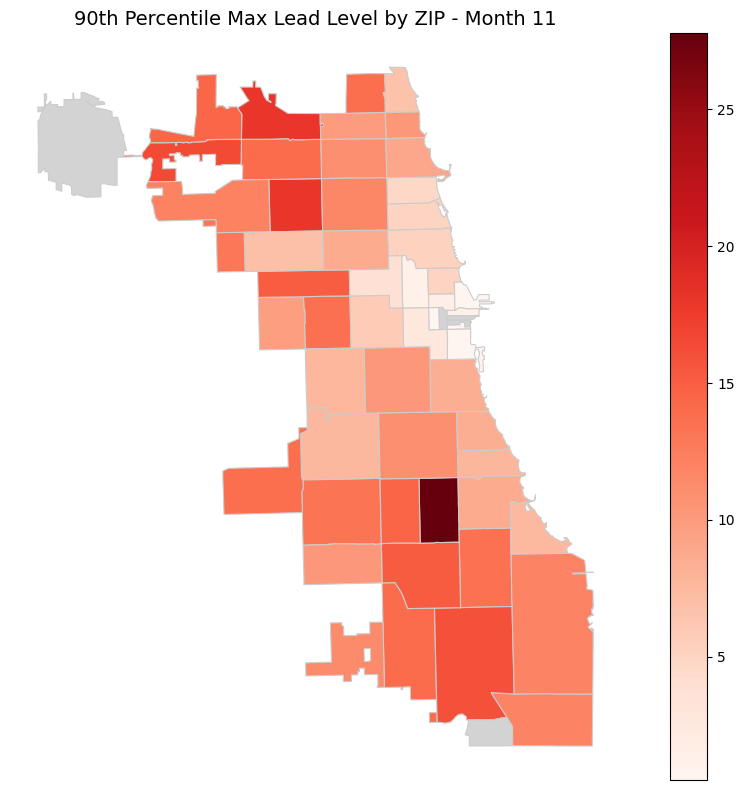

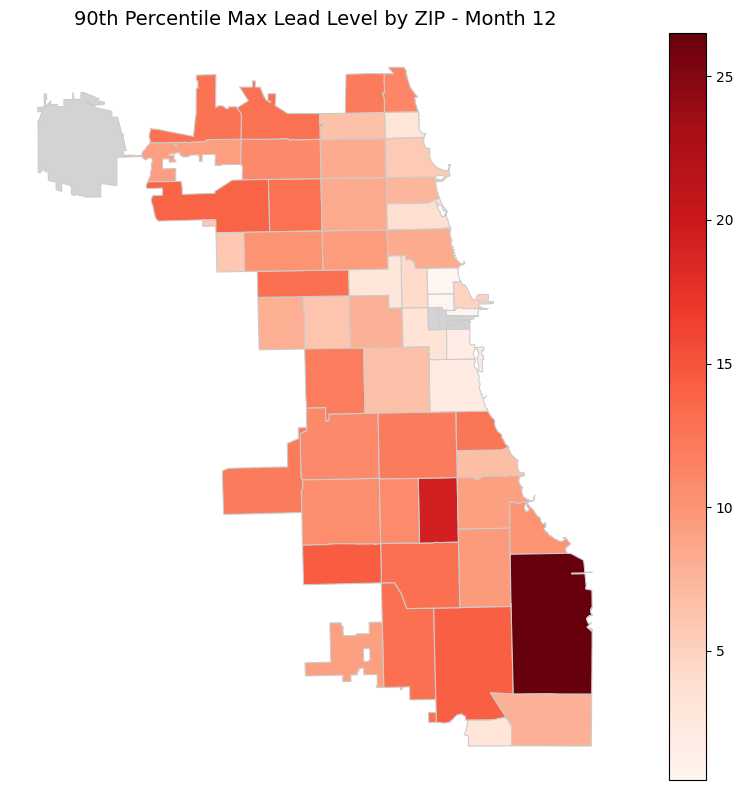

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/content/drive/My Drive/IPRO/boots_1.csv')

# Convert Sample Date
df['Sample Date'] = pd.to_datetime(df['Sample Date'], errors='coerce')
df = df.dropna(subset=['Sample Date'])

# Clean ZIP codes (extract 5-digit)
df['ZIP'] = df['property_zip'].astype(str).str.extract(r'(\d{5})')

# Extract month
df['Month'] = df['Sample Date'].dt.month

# Convert 'Max' to numeric
df['Max'] = pd.to_numeric(df['Max'], errors='coerce')

# Drop NaNs in ZIP or Max
df = df.dropna(subset=['ZIP', 'Max'])

# Calculate 90th percentile lead level for each ZIP and month
monthly_90th_by_zip = df.groupby(['ZIP', 'Month'])['Max'].quantile(0.9).reset_index()
monthly_90th_by_zip.columns = ['ZIP', 'Month', 'Lead90']

# Optional: Load ZIP shapefile for Chicago
# Replace with correct path to your shapefile
# Load Chicago ZIP boundaries from City of Chicago's Data Portal
zip_url = "https://data.cityofchicago.org/api/geospatial/unjd-c2ca?method=export&format=GeoJSON"
gdf = gpd.read_file(zip_url)


# Standardize ZIP column name
gdf['ZIP'] = gdf['zip'].astype(str).str.zfill(5)


# Ensure ZIP columns match format
gdf['ZIP'] = gdf['ZIP'].astype(str).str.zfill(5)

# Plot maps for each month
for month in range(1, 13):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Merge monthly data with GeoDataFrame
    month_data = monthly_90th_by_zip[monthly_90th_by_zip['Month'] == month]
    merged = gdf.merge(month_data, on='ZIP', how='left')

    # Plot
    merged.plot(column='Lead90',
                cmap='Reds',
                linewidth=0.8,
                edgecolor='0.8',
                legend=True,
                ax=ax,
                missing_kwds={"color": "lightgrey", "label": "No data"})

    ax.set_title(f"90th Percentile Max Lead Level by ZIP - Month {month}", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
print("Total unique ZIPs in original dataset:", df['ZIP'].nunique())

Total unique ZIPs in original dataset: 58


# Seasonal Risk Score by ZIP Code

## Goal  
This analysis helps us understand how lead levels change with the seasons in different parts of Chicago. By comparing warm months (May–September) to cold months (October–April), we can find ZIP codes where lead contamination gets worse in summer.

## What the Code Does  
- **Tags** each lead sample as either `Warm` or `Cold` season based on the sample month  
- **Groups** data by ZIP code and season, then calculates the 90th percentile lead level for each  
- **Creates** a Seasonal Risk Score by dividing the warm-season lead level by the cold-season level  
  - A score > 1 means lead levels are higher in warm months  
- **Ranks** all ZIP codes by this score and shows the top 15 with the highest summer sensitivity  
- **Merges** this data with the city’s ZIP code map and visualizes the score using a choropleth map  

## Interpretation  
The map uses a `coolwarm` color scheme:  
- *Blue areas*: Similar or slightly higher lead levels in summer  
- *Red areas* (especially downtown Chicago): Much higher summer lead levels  
- Most ZIPs are blue but still have scores > 1 — just less extreme than red zones  

## Key Insight  
This map helps target ZIP codes where warm-weather lead exposure may spike, possibly due to temperature-related effects in plumbing or water chemistry.

In [6]:
# Define warm (Jun–Sep) and cold (Oct–Apr) months
warm_months = [6, 7, 8, 9]
cold_months = [1, 2, 3, 4, 5, 10, 11, 12]

# Tag seasons
df['Season'] = df['Month'].apply(lambda x: 'Warm' if x in warm_months else 'Cold')

# Group by ZIP and Season, compute 90th percentile of Max
seasonal_zip = df.groupby(['ZIP', 'Season'])['Max'].quantile(0.9).unstack()

# Compute seasonal risk score
seasonal_zip['RiskScore'] = seasonal_zip['Warm'] / seasonal_zip['Cold']

# Sort by score
seasonal_zip_sorted = seasonal_zip.sort_values(by='RiskScore', ascending=False)

# Display top 15 most seasonally sensitive ZIPs
print("Top 15 ZIPs with highest summer sensitivity:")
display(seasonal_zip_sorted.head(15))


Top 15 ZIPs with highest summer sensitivity:


Season   Cold   Warm  RiskScore
ZIP                            
60605    0.50   1.10   2.200000
60614    7.80  13.00   1.666667
60609   10.40  16.80   1.615385
60644    8.12  12.80   1.576355
60608    9.66  15.00   1.552795
60607    3.09   4.50   1.456311
60615    8.24  12.00   1.456311
60616    7.38  10.00   1.355014
60622    6.80   8.93   1.313235
60641   14.00  18.30   1.307143
60624    9.51  12.40   1.303891
60631   14.00  18.00   1.285714
60659   12.00  15.00   1.250000
60623   12.00  15.00   1.250000
60628   14.00  17.00   1.214286

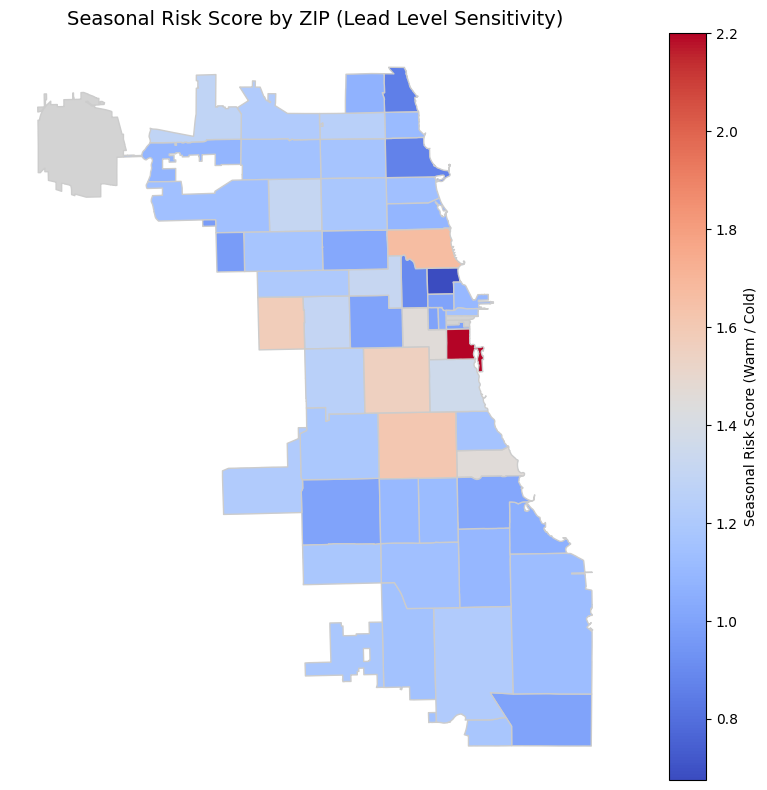

In [7]:
# Merge with GeoDataFrame
gdf_risk = gdf.merge(seasonal_zip, on='ZIP', how='left')

# Plot the Risk Score
fig, ax = plt.subplots(figsize=(10, 8))
gdf_risk.plot(column='RiskScore',
              cmap='coolwarm',
              legend=True,
              edgecolor='0.8',
              ax=ax,
              missing_kwds={"color": "lightgrey", "label": "No data"},
              legend_kwds={"label": "Seasonal Risk Score (Warm / Cold)"})

ax.set_title("Seasonal Risk Score by ZIP (Lead Level Sensitivity)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


# Professor Ellis' Email

## Goal  
To determine if lead contamination in Chicago ZIP codes is **significantly higher during warm months (June–September)** using statistical methods. This helps distinguish true seasonal trends from random noise and guides targeted interventions.  

---

## Methodology  

### 1. Season Classification & Risk Score  
- **Warm months**: June–September (aligned with EPA compliance periods)  
- **Cold months**: October–May  
- **Risk Score**:  Risk Score = (90th percentile Warm) / (90th percentile Cold)

- **Score > 1**: Higher risk in summer  
- **Score < 1**: Higher risk in winter  

### 2. Sample Size Filtering  
- Excluded ZIPs with **<10 samples per season** (`low_data_zips`) to ensure reliability  

---

## Visual Interpretation Tools  

### 3. Overlaid Histograms (PDF)  
- **Red curve**: Warm season lead levels  
- **Blue curve**: Cold season lead levels  
- **Rightward red shift** = Higher summer contamination  

### 4. Cumulative Distribution Function (CDF)  
- **Red line (Warm) right of blue** = Summer values dominate higher percentiles  

### 5. 2D Histogram: Lead Level vs. Day of Year  
- **X-axis**: Day of year (1–365)  
- **Y-axis**: Lead level (ppb)  
- **Darker clusters in summer** = Seasonal risk spikes  

---

## Statistical Testing  

### 6. Bootstrap Confidence Intervals (90th Percentile)  
- **1,000 iterations** per ZIP/season  
- **Non-overlapping CIs** = Statistically significant difference  
- Example: ZIP 60609 (Warm CI: 12–18 ppb vs. Cold CI: 6–9 ppb)  

### 7. Permutation Test (Risk Score Significance)  
- **1,000 shuffled season labels** to create null distribution  
- **p-value < 0.05** = True Risk Score unlikely due to chance  

---

## Results  

### 8. Statistically Significant ZIPs (Choropleth Map)  
**Key criteria for inclusion**:  
- Adequate sample size (≥10 samples/season)  
- Significant warm/cold difference (p < 0.05)  

**High-risk ZIPs**:  
- **60614**, **60609**, **60644**, **60608** (strong summer elevation)  
- **60623**, **60629**, **60632** (moderate seasonal spikes)  

---

## Key Insights  
1. **Summer spikes are real**: ZIPs like 60609 show statistically confirmed warm-month risk elevation.  
2. **Uncertainty matters**: Wide CIs in low-sample ZIPs (e.g., 60605) limit conclusions.  
3. **Actionable targets**: Prioritize ZIPs with **p < 0.05 + Risk Score > 1.5** for seasonal monitoring.  

## Step 1: Adjust Warm/Cold Season Definition

### Tag the seasons  
We split the data into two parts:  

- **Warm season** (June to September)  
- **Cold season** (all the other months)  

That’s because compliance testing is done in the summer, so we need to compare those months directly.  


In [8]:
# Updated season tagging
warm_months = [6, 7, 8, 9]
cold_months = [1, 2, 3, 4, 5, 10, 11, 12]

df['Season'] = df['Month'].apply(lambda x: 'Warm' if x in warm_months else 'Cold')

### Group and calculate extremes  
For each ZIP code, we calculate the **90th percentile lead level** separately for warm and cold seasons.  
This shows us how bad the worst lead exposures are in each season — we’re not using averages, we’re focusing on high-risk cases.  

### Risk score = how much worse it gets in summer  
Then, we take the warm season 90th percentile and divide it by the cold season’s. That gives us a **Risk Score** for each ZIP.  

- **A score > 1** = lead is worse in summer  
- **The higher the score**, the stronger the seasonal effect  

### Ranking  
We sort ZIPs by this score to see which areas have the biggest summer spike in lead levels.

In [9]:
# Group by ZIP and Season, compute 90th percentile of Max
seasonal_zip = df.groupby(['ZIP', 'Season'])['Max'].quantile(0.9).unstack()

# Compute risk score
seasonal_zip['RiskScore'] = seasonal_zip['Warm'] / seasonal_zip['Cold']

# Sort and display
seasonal_zip_sorted = seasonal_zip.sort_values(by='RiskScore', ascending=False)
display(seasonal_zip_sorted.head(15))

Season   Cold   Warm  RiskScore
ZIP                            
60605    0.50   1.10   2.200000
60614    7.80  13.00   1.666667
60609   10.40  16.80   1.615385
60644    8.12  12.80   1.576355
60608    9.66  15.00   1.552795
60607    3.09   4.50   1.456311
60615    8.24  12.00   1.456311
60616    7.38  10.00   1.355014
60622    6.80   8.93   1.313235
60641   14.00  18.30   1.307143
60624    9.51  12.40   1.303891
60631   14.00  18.00   1.285714
60659   12.00  15.00   1.250000
60623   12.00  15.00   1.250000
60628   14.00  17.00   1.214286

## Step 2: Check sample sizes per ZIP and season

### Data Quality Check  
We needed to double-check the data quality  
Even if a ZIP has a high Risk Score, it’s not reliable if there were only a few samples. For example, if a ZIP had just 2 summer tests, that score could be misleading.  

### What the code does  
- First, we count how many samples we have in each ZIP, separately for Warm and Cold seasons.  
- Then we merge that with the **Risk Scores** we calculated earlier.  
- Finally, we flag any ZIP that had fewer than **10 samples** in either season. These are the ones we might want to ignore or treat carefully when interpreting results.  

### Why this matters  
It helps us avoid over-interpreting ZIPs with small sample sizes. Basically, we’re making sure our conclusions are statistically sound.

In [10]:
# Count number of samples per ZIP and season
sample_counts = df.groupby(['ZIP', 'Season']).size().unstack(fill_value=0)
sample_counts.columns = ['Cold_Count', 'Warm_Count']

# Merge with the seasonal risk scores
seasonal_zip_stats = seasonal_zip.merge(sample_counts, left_index=True, right_index=True)

# Optional: Filter ZIPs where either season has fewer than 10 samples
low_data_zips = seasonal_zip_stats[(seasonal_zip_stats['Cold_Count'] < 30) |
                                    (seasonal_zip_stats['Warm_Count'] < 30)]

print(f"Number of ZIPs with insufficient data (<10 samples in one season): {len(low_data_zips)}")
display(low_data_zips)

Number of ZIPs with insufficient data (<10 samples in one season): 8


Cold  Warm  RiskScore  Cold_Count  Warm_Count
ZIP                                                  
60601  0.500  0.58   1.160000          15          10
60602    NaN  0.50        NaN           0           3
60603  0.500   NaN        NaN           1           0
60604  0.500  0.50   1.000000           4           1
60606  0.475  0.50   1.052632           2           5
60654  0.500  0.50   1.000000          20          25
60661  0.500  0.50   1.000000          10          13
60827  7.960  9.38   1.178392           2           4

## Step 3: Visualize Warm vs. Cold Distributions

Generates overlaid probability histograms (PDFs) of lead levels for warm and cold seasons in a given ZIP code. Useful for visually comparing the distribution shapes and spotting differences, especially around the 90th percentile.

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Code for Overlaid Histograms (PDF)
def plot_overlay_histograms(zip_code):
    subset = df[df['ZIP'] == zip_code]
    warm = subset[subset['Season'] == 'Warm']['Max']
    cold = subset[subset['Season'] == 'Cold']['Max']

    plt.figure(figsize=(10, 5))
    sns.histplot(warm, kde=True, color='red', label='Warm', stat='density', bins=20, alpha=0.6)
    sns.histplot(cold, kde=True, color='blue', label='Cold', stat='density', bins=20, alpha=0.6)
    plt.title(f'Probability Histogram (PDF) for ZIP {zip_code}')
    plt.xlabel('Lead Level (Max, µg/L)')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

Plots cumulative distribution functions (CDFs) of lead levels for warm and cold seasons in a given ZIP code. Helps identify percentile cutoffs like the 90th and visually compare the cumulative behavior of both distributions.

In [12]:
# Code for Overlaid Cumulative Histograms (CDF)
def plot_overlay_cdf(zip_code):
    subset = df[df['ZIP'] == zip_code]
    warm = subset[subset['Season'] == 'Warm']['Max']
    cold = subset[subset['Season'] == 'Cold']['Max']

    plt.figure(figsize=(10, 5))
    sns.ecdfplot(warm, label='Warm', color='red')
    sns.ecdfplot(cold, label='Cold', color='blue')
    plt.title(f'Cumulative Histogram (CDF) for ZIP {zip_code}')
    plt.xlabel('Lead Level (Max, µg/L)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Interpretation Guide for Seasonal Lead Analysis  

### 🔹 **PDF (Histogram) – Lead Level Frequency**  
- **✅ Red (warm) curve is to the right of blue (cold)**  
  → *Higher lead levels in warm months.*  

- **✅ Blue (cold) curve is to the right of red**  
  → *Higher lead levels in cold months (rare).*  

- **⚠️ Red and blue overlap almost completely**  
  → *No significant seasonal difference.*  

- **⚠️ Red curve has a long tail on the right**  
  → *Warm months include extreme outliers.*  

- **⚠️ Blue curve is wide and flat**  
  → *Cold months show high variability, not necessarily higher averages.*  

---

### 🔹 **CDF (Cumulative Graph) – Percentile Trends**  
- **✅ Red line is always under the blue line**  
  → *Warm months dominate higher percentiles.*  

- **✅ Red line hits 90% at a higher value than blue**  
  → *Top 10% of readings are worse in warm months.*  

- **⚠️ Red and blue lines overlap**  
  → *No meaningful seasonal difference.*  

- **⚠️ Red line rises steeply**  
  → *Warm-month values cluster tightly (low spread).*  

- **⚠️ Red and blue lines cross**  
  → *Mixed pattern: Cold months dominate mid-range, warm months have worse extremes.*  

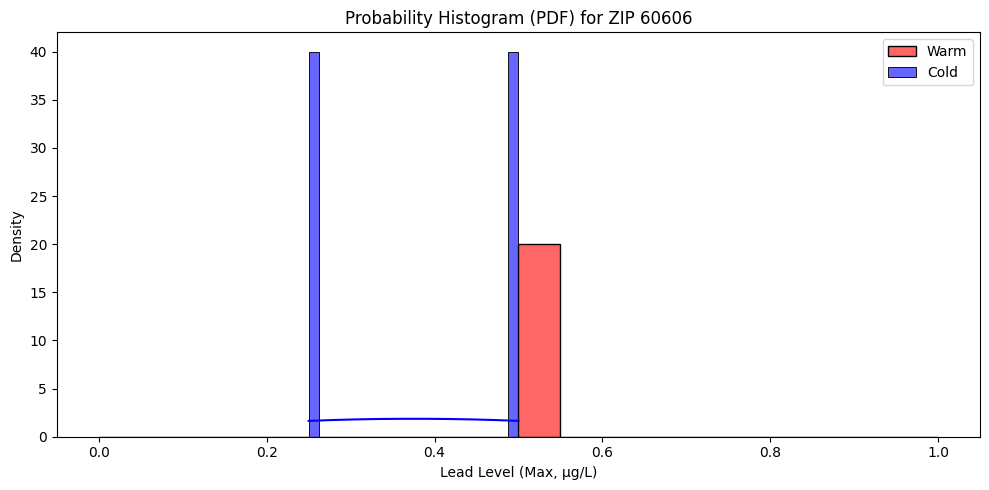

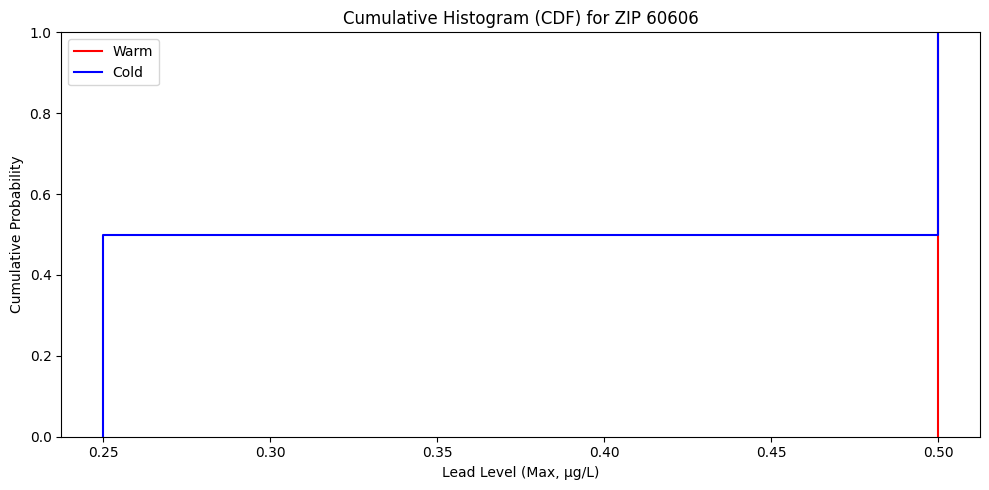

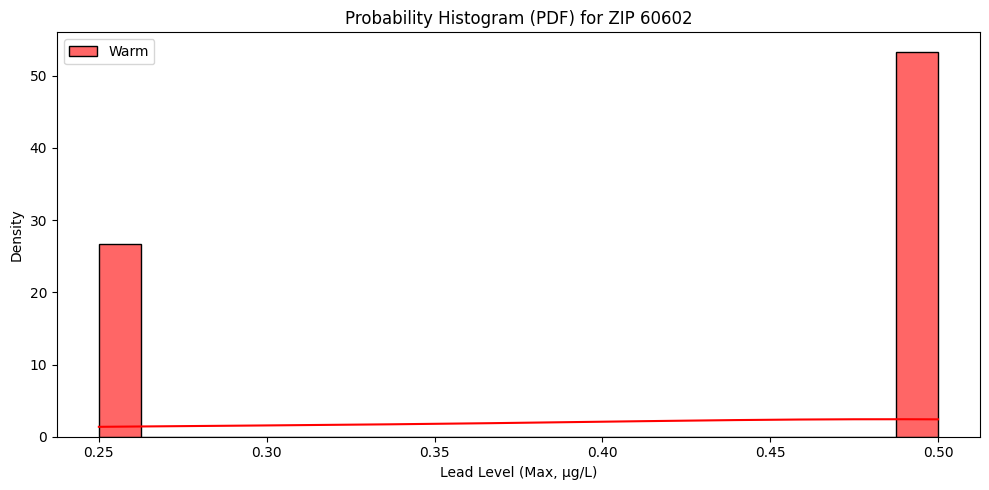

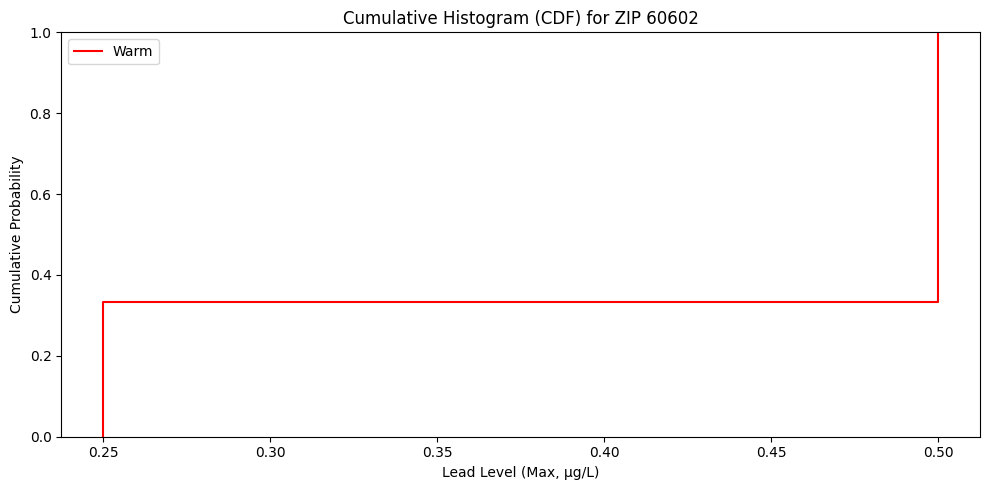

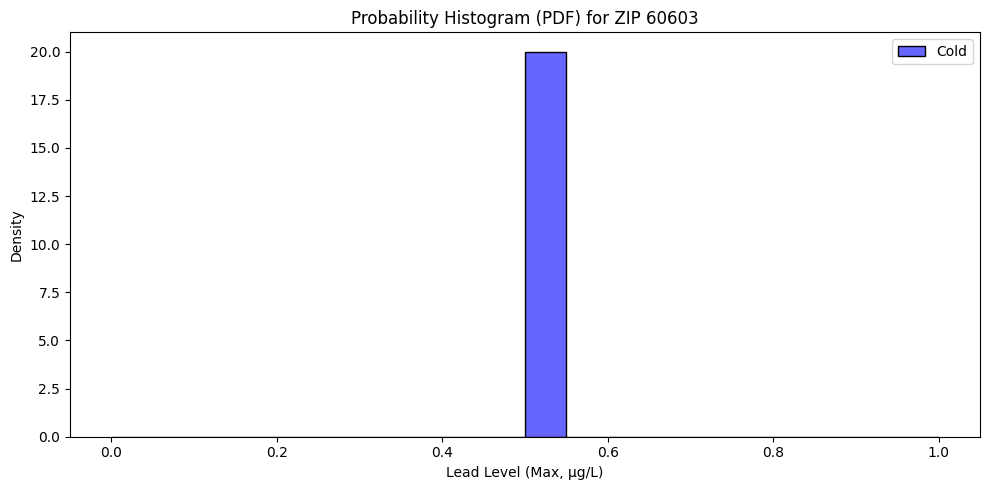

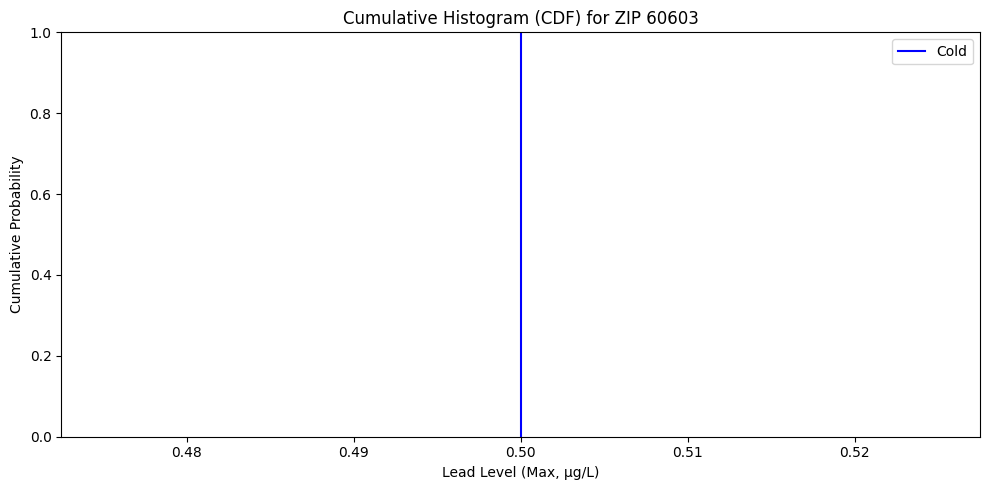

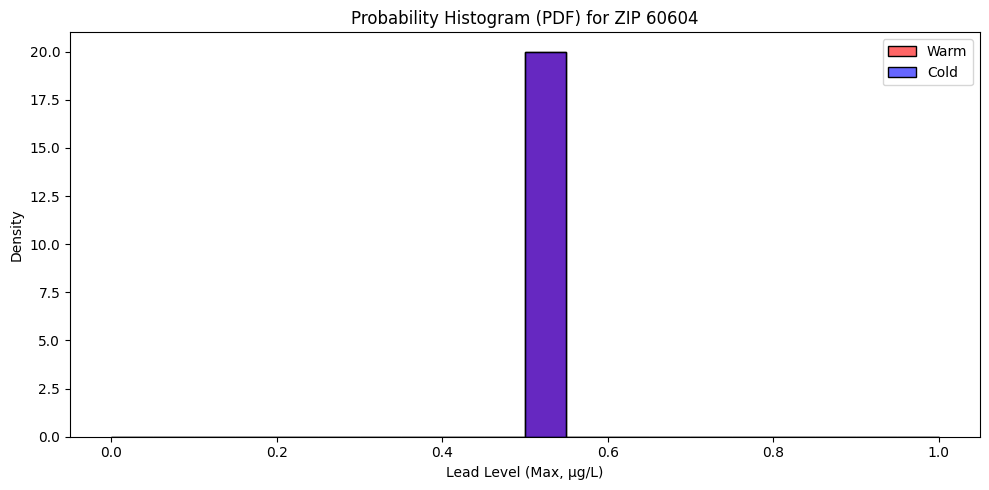

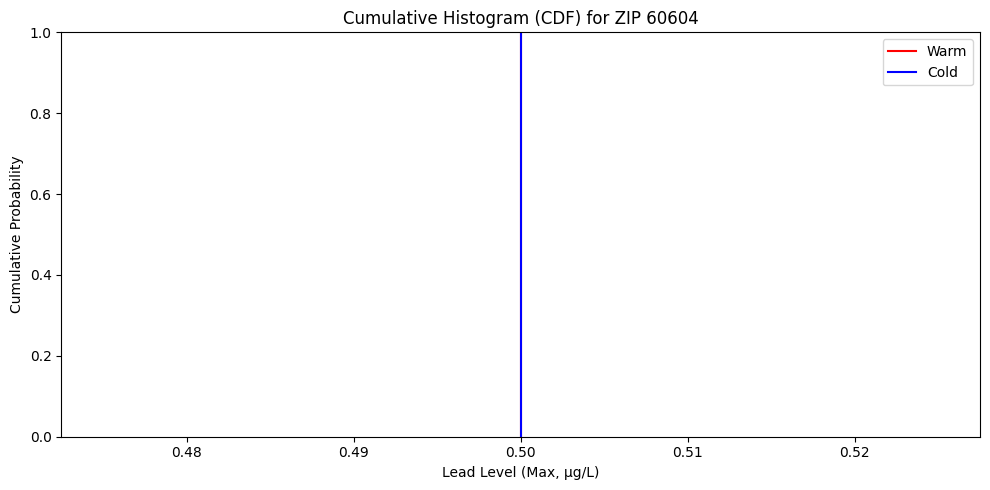

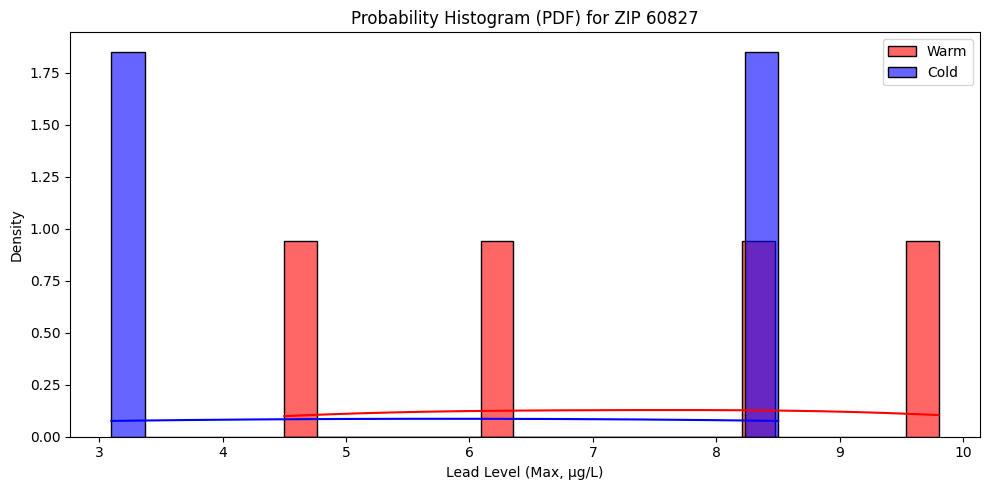

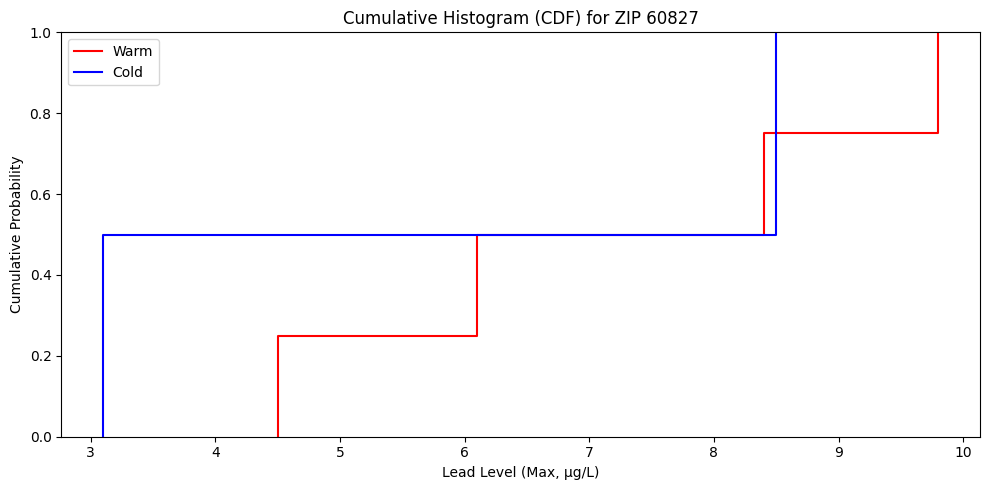

In [13]:
plot_overlay_histograms('60606')
plot_overlay_cdf('60606')
plot_overlay_histograms('60602')
plot_overlay_cdf('60602')
plot_overlay_histograms('60603')
plot_overlay_cdf('60603')
plot_overlay_histograms('60604')
plot_overlay_cdf('60604')
plot_overlay_histograms('60827')
plot_overlay_cdf('60827')

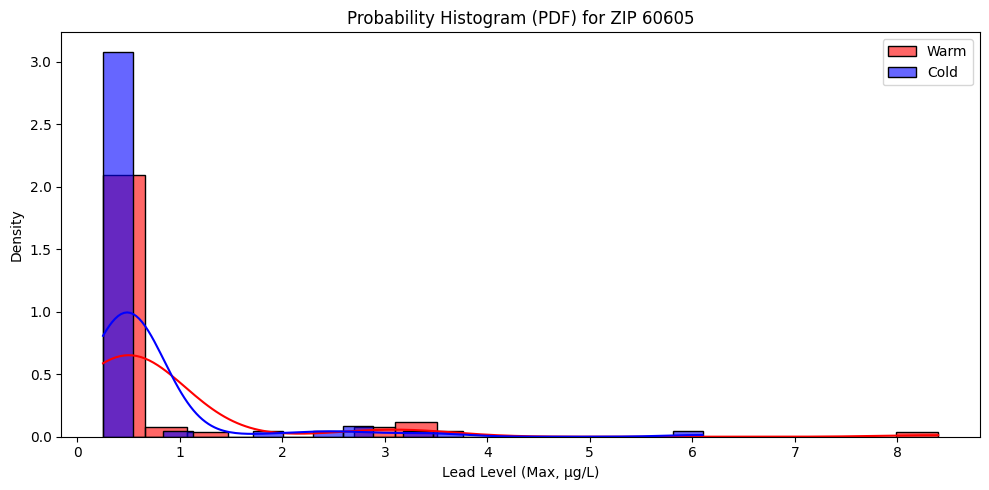

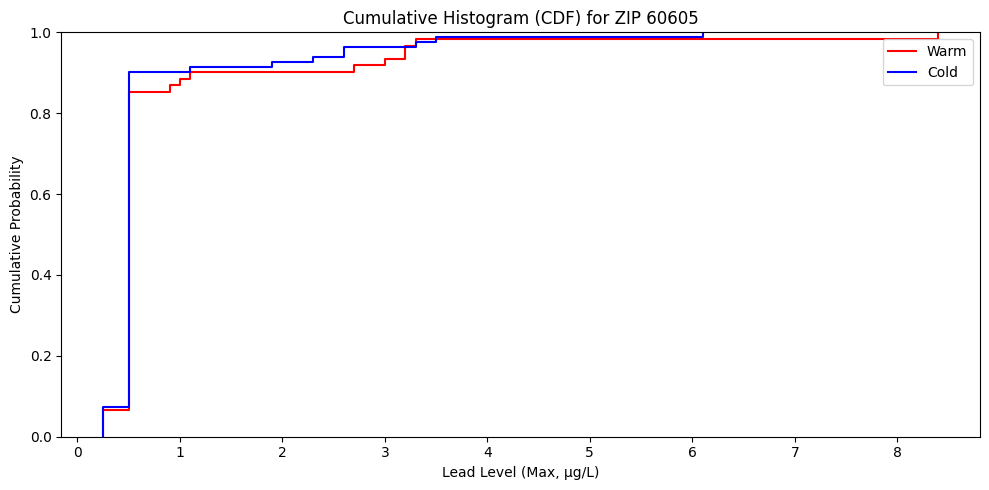

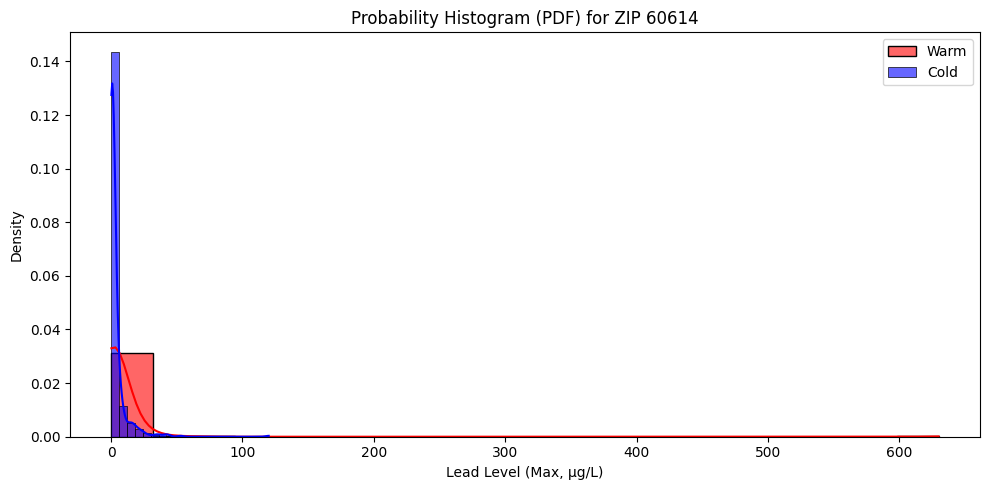

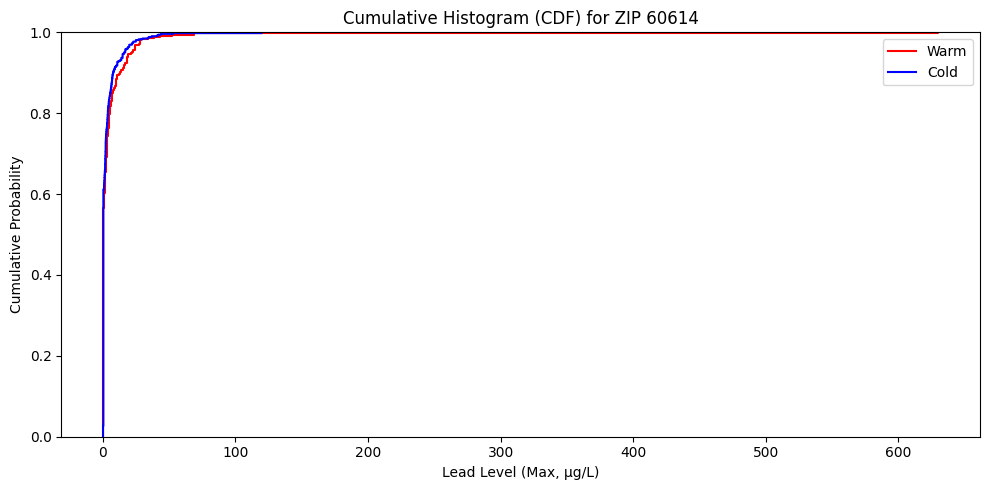

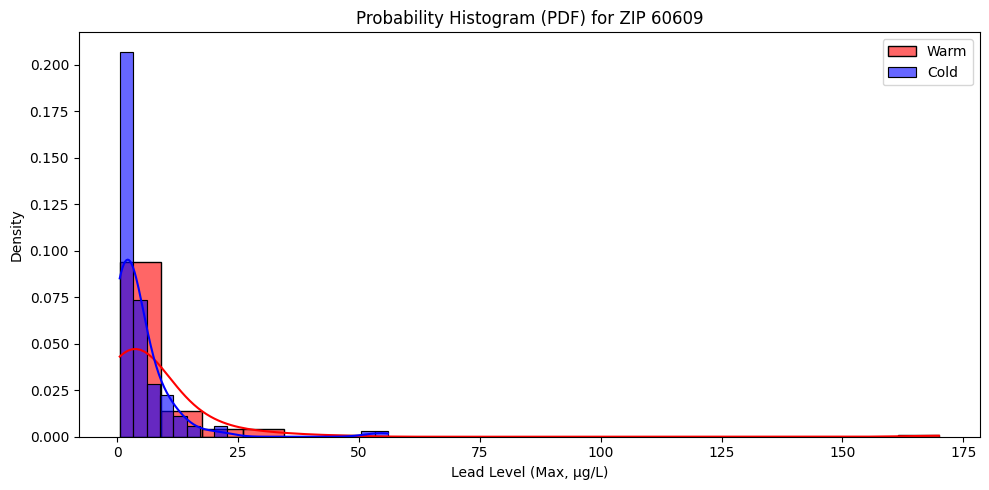

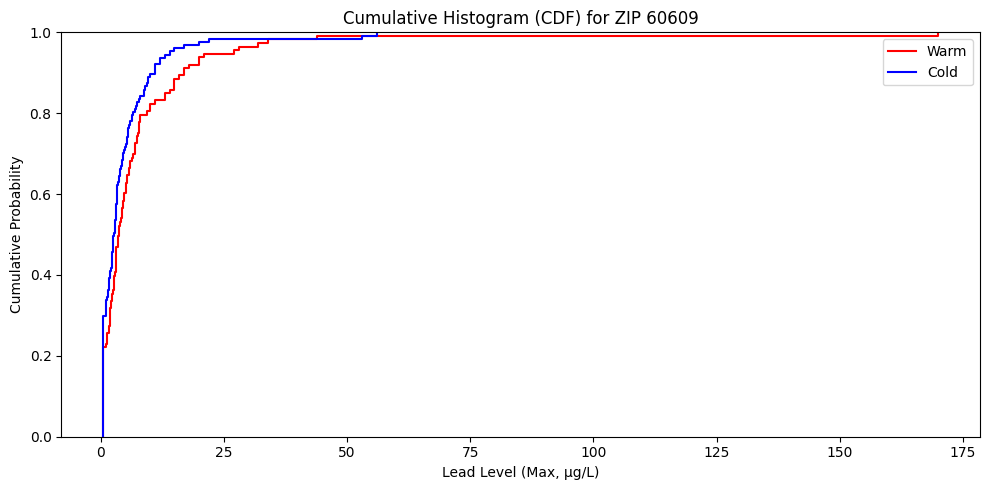

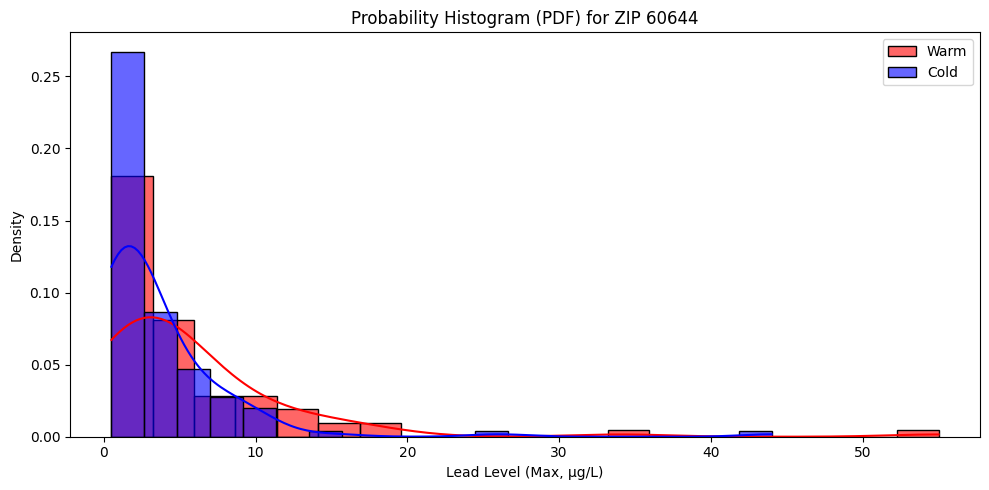

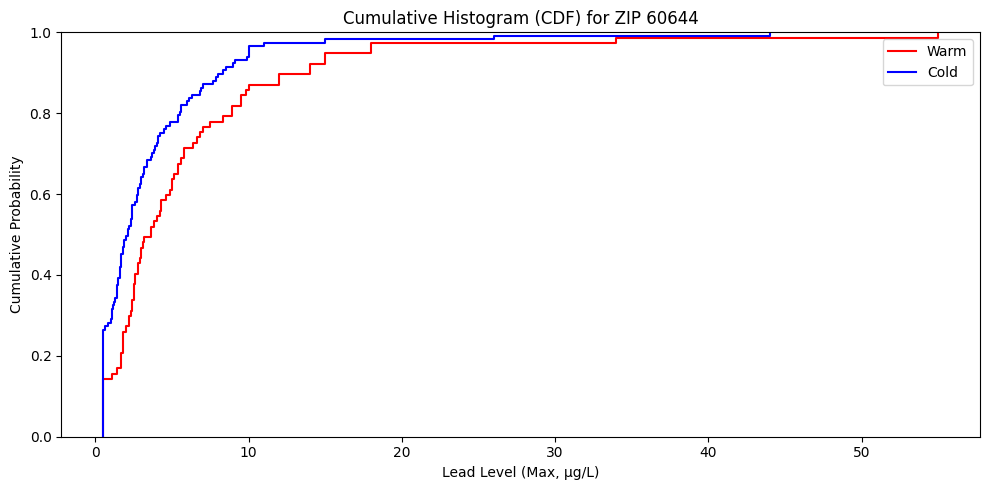

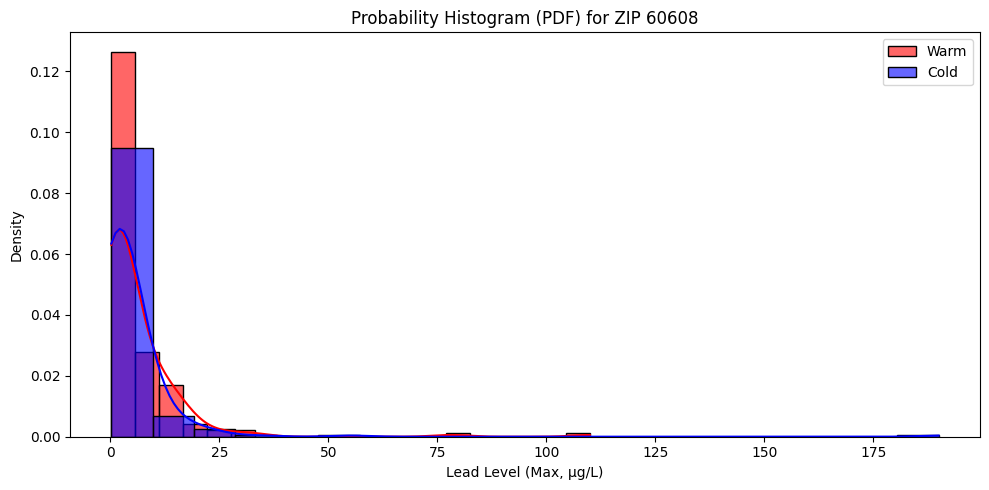

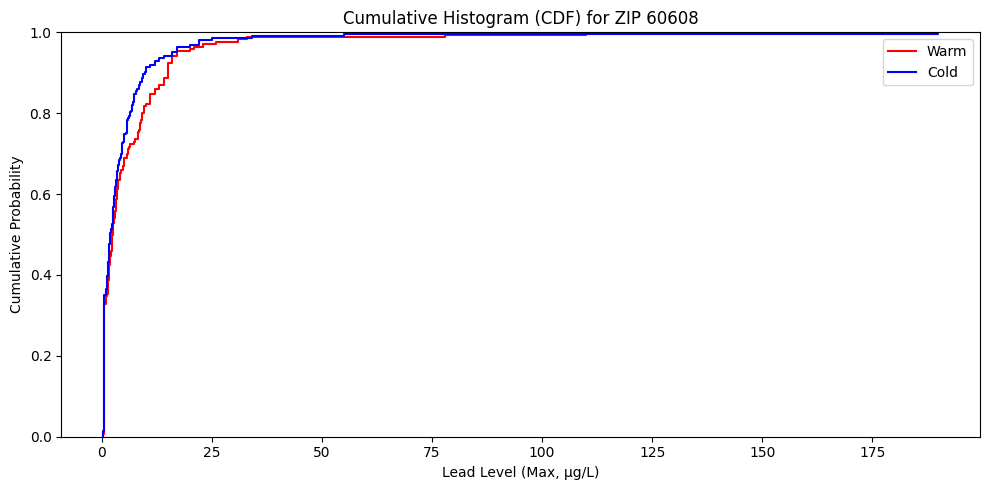

In [14]:
plot_overlay_histograms('60605')
plot_overlay_cdf('60605')
plot_overlay_histograms('60614')
plot_overlay_cdf('60614')
plot_overlay_histograms('60609')
plot_overlay_cdf('60609')
plot_overlay_histograms('60644')
plot_overlay_cdf('60644')
plot_overlay_histograms('60608')
plot_overlay_cdf('60608')

## Step 4: 2D Histogram – Lead Level vs. Day of Year

In [15]:
# Add a Day of Year column
df['DayOfYear'] = df['Sample Date'].dt.dayofyear

Instead of using months, we translated the date into a number between **1 and 365**. That way, we can spot seasonal trends more clearly on a timeline.  

### Plotted lead levels across the year  
We made a **2D heatmap-style histogram** where:  
- **X-axis** = day of the year (January 1 to December 31)  
- **Y-axis** = lead levels  
- **Color** = number of samples (darker = more data points)  

### Why this is useful  
- Shows us **when** during the year the highest lead levels tend to happen  
- A cluster of high lead values around summer days (e.g., day 150–250) → visual confirmation of seasonal spikes  
- Done for **specific ZIPs** and **citywide** to compare local vs general trends  

### How to read the plot  
- **Red-hot zones higher up on the Y-axis during June–Sep** → likely seasonal lead spikes  
- **Even color throughout** → no seasonal pattern  
- **Tall red zone** = more high-risk samples on those days  
- **Nothing above 15–20 µg/L all year** = generally low-risk area  

In [16]:
import matplotlib.pyplot as plt

# 2D Histogram for One ZIP (e.g., 60606)
def plot_2d_hist(zip_code):
    subset = df[df['ZIP'] == zip_code]

    plt.figure(figsize=(10, 6))
    plt.hist2d(subset['DayOfYear'], subset['Max'], bins=[30, 20], cmap='Reds')
    plt.colorbar(label='Number of Samples')
    plt.title(f'2D Histogram – Day of Year vs Lead Level for ZIP {zip_code}')
    plt.xlabel('Day of Year')
    plt.ylabel('Lead Level (Max, µg/L)')
    plt.tight_layout()
    plt.show()

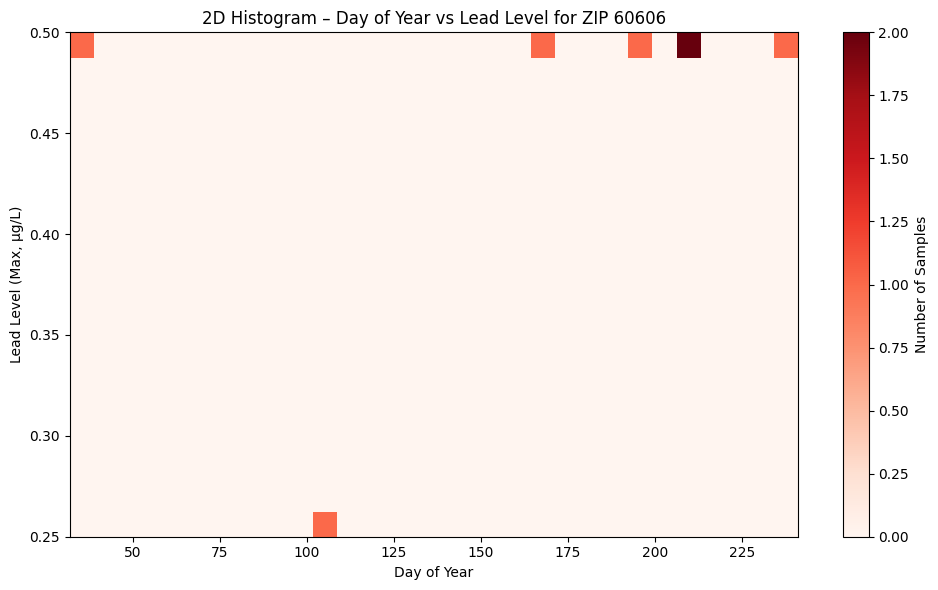

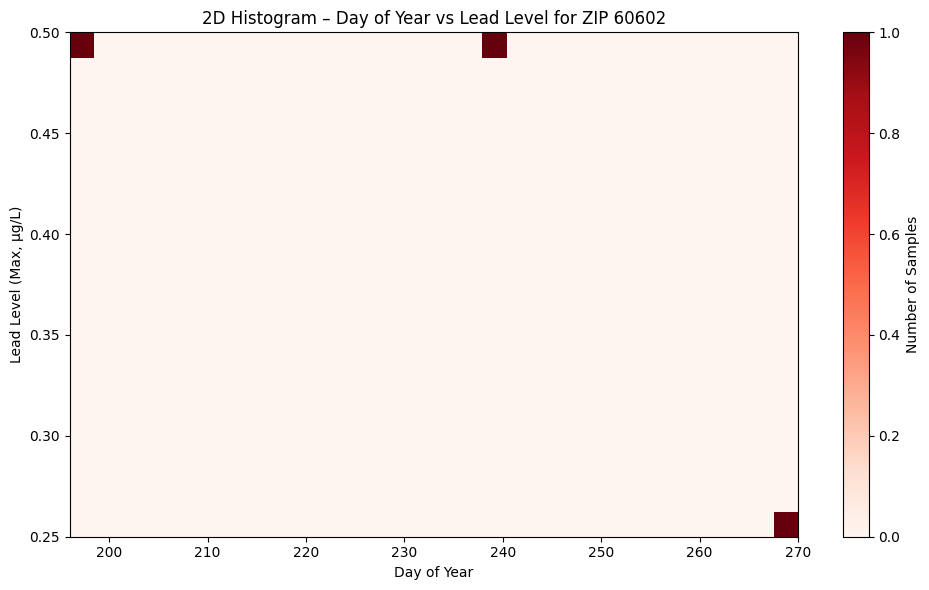

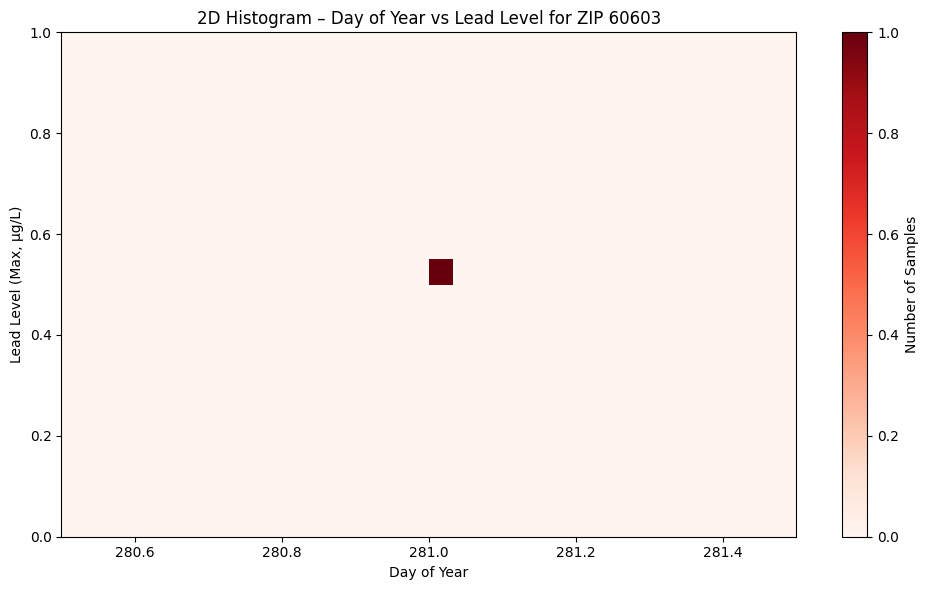

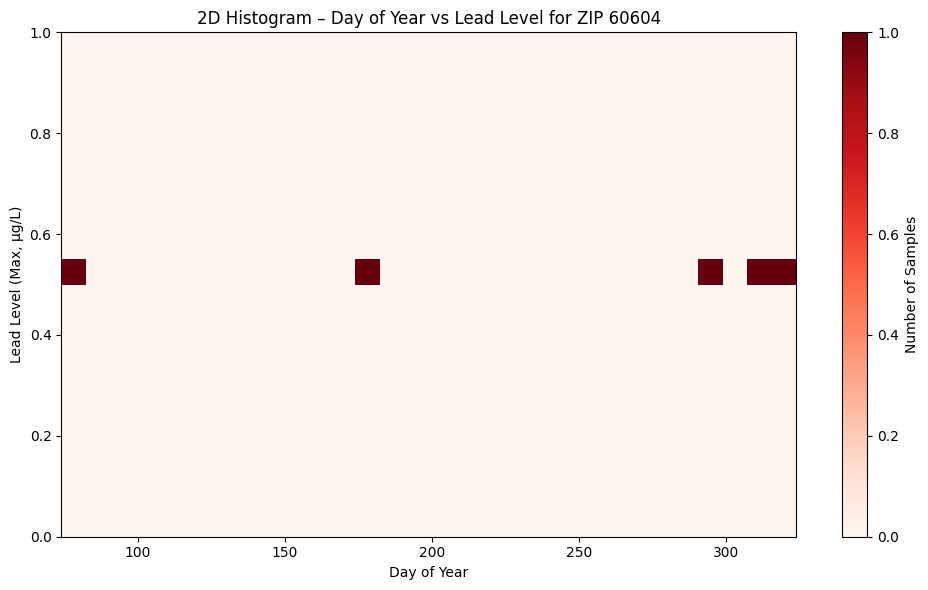

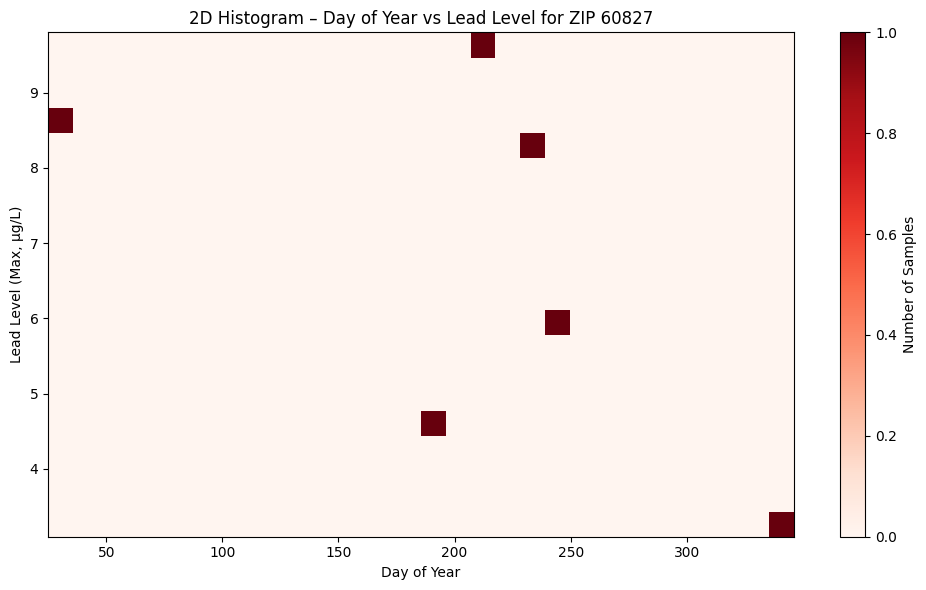

In [17]:
plot_2d_hist('60606')
plot_2d_hist('60602')
plot_2d_hist('60603')
plot_2d_hist('60604')
plot_2d_hist('60827')

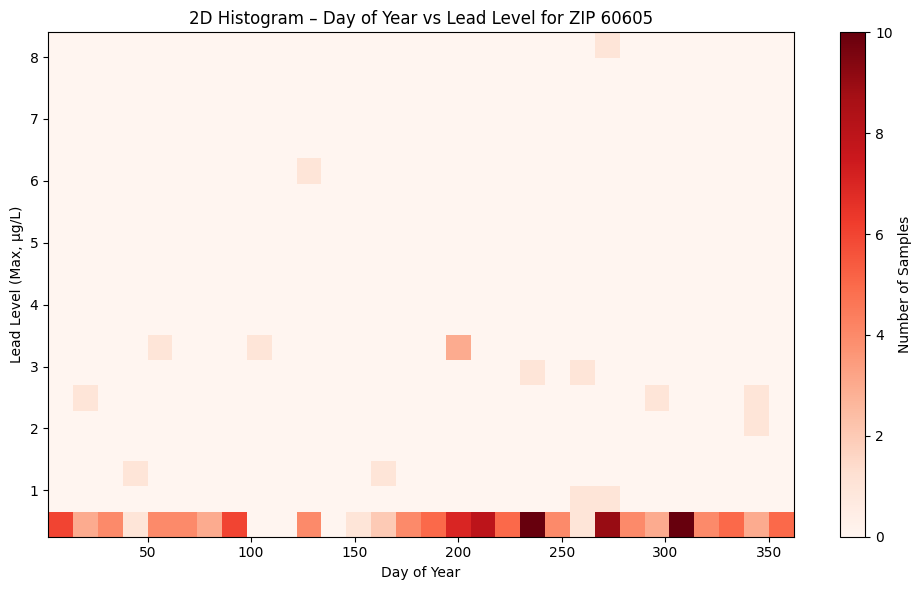

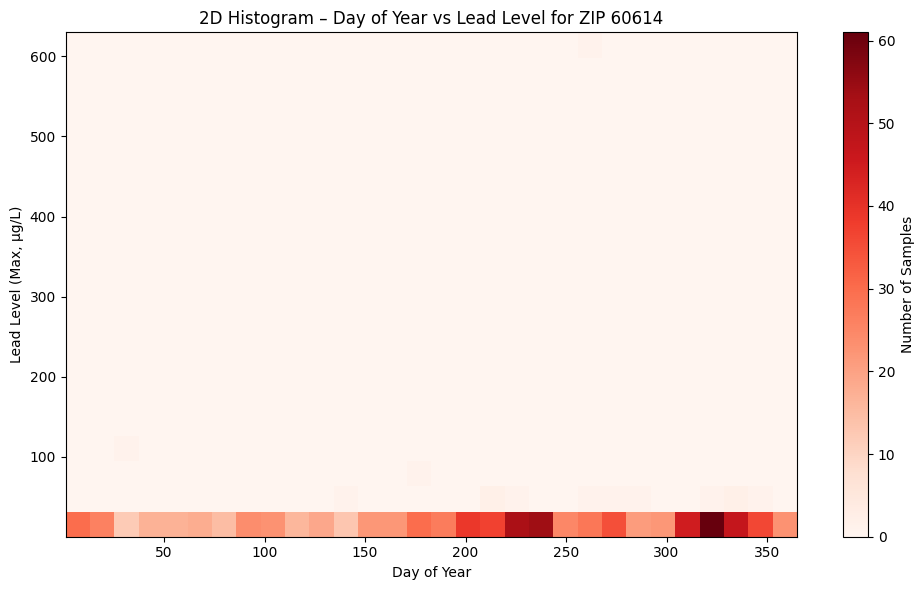

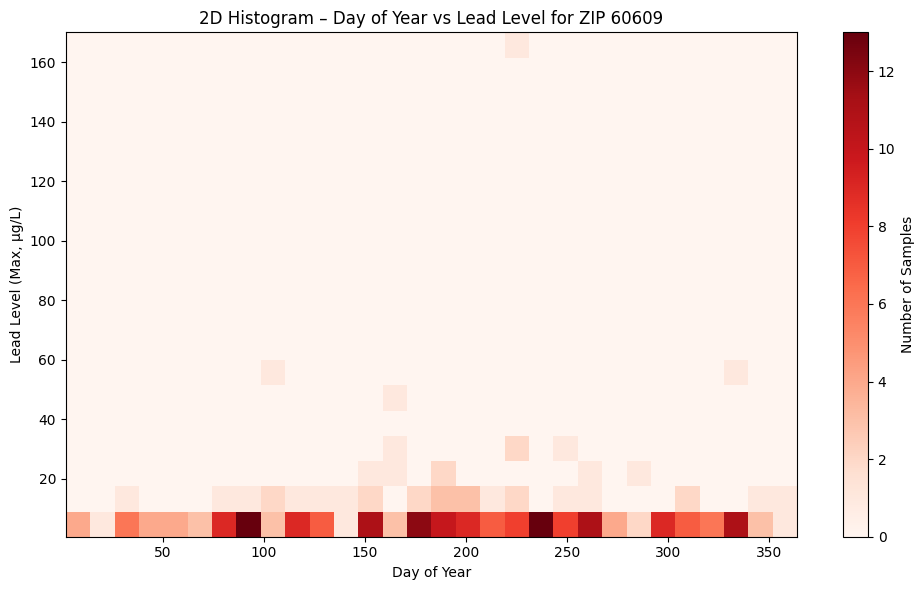

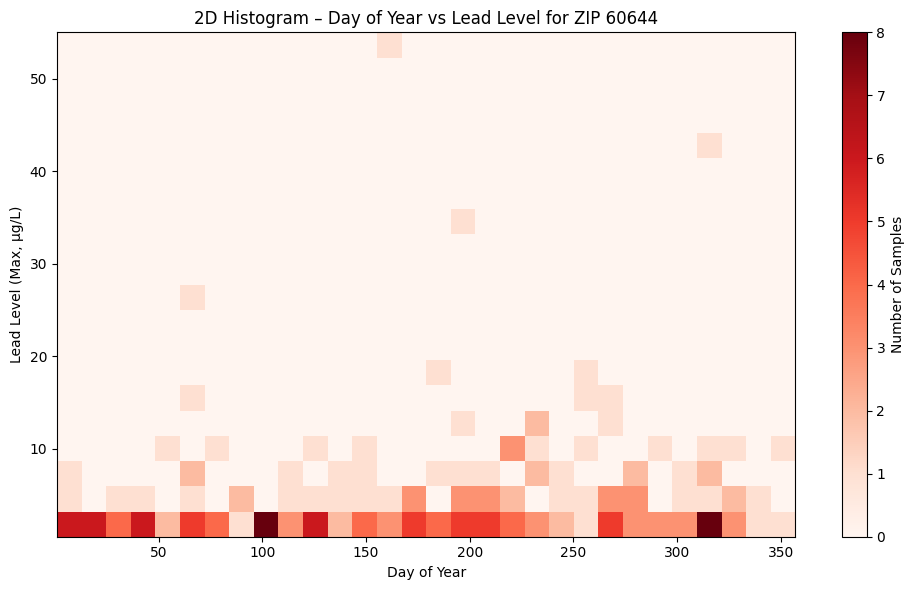

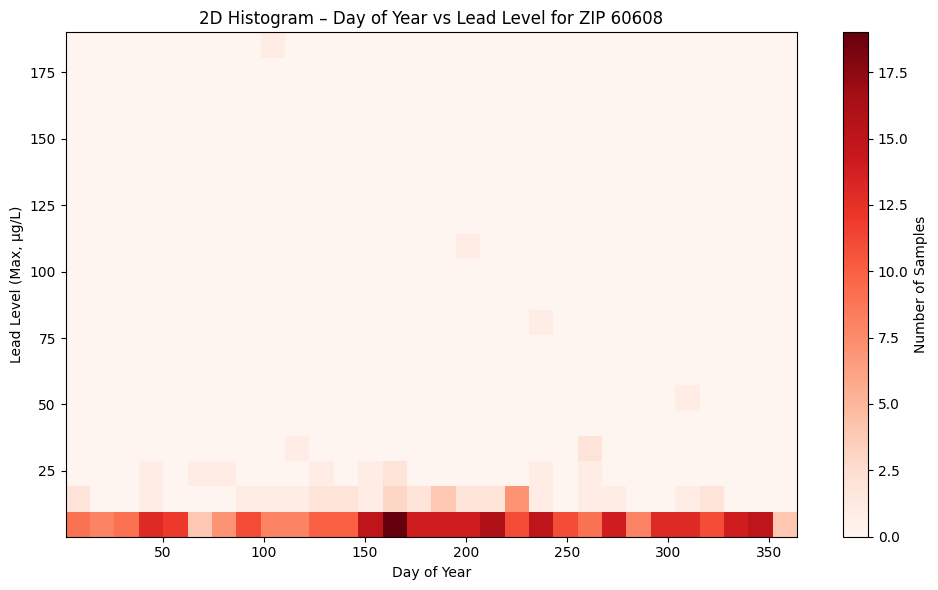

In [18]:
plot_2d_hist('60605')
plot_2d_hist('60614')
plot_2d_hist('60609')
plot_2d_hist('60644')
plot_2d_hist('60608')

Generates a 2D histogram for all ZIP codes, showing lead levels across the calendar year. Useful for identifying seasonal spikes and temporal clustering of high lead values citywide.

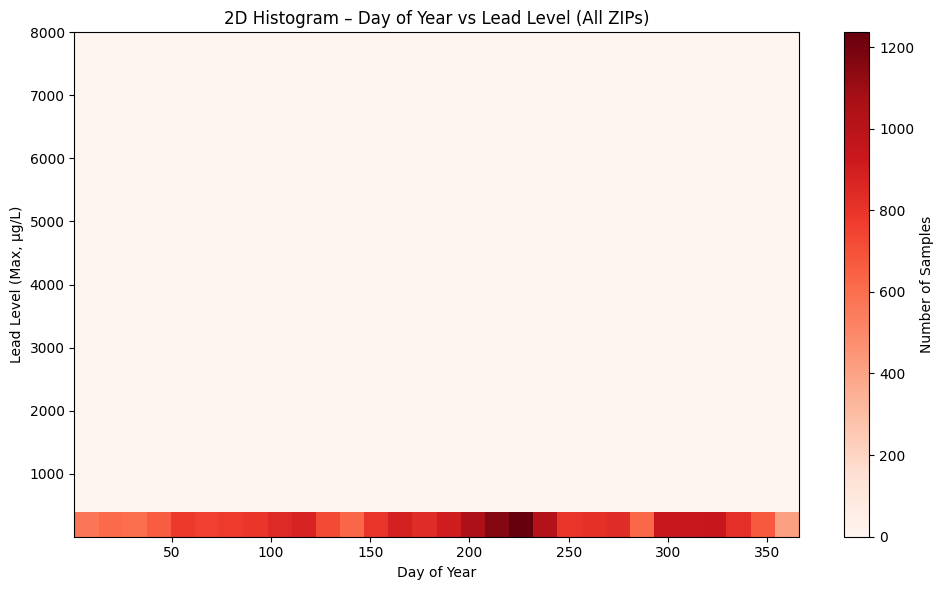

In [19]:
plt.figure(figsize=(10, 6))
plt.hist2d(df['DayOfYear'], df['Max'], bins=[30, 20], cmap='Reds')
plt.colorbar(label='Number of Samples')
plt.title('2D Histogram – Day of Year vs Lead Level (All ZIPs)')
plt.xlabel('Day of Year')
plt.ylabel('Lead Level (Max, µg/L)')
plt.tight_layout()
plt.show()

## Step 5: Bootstrap Confidence Intervals for the 90th percentile lead levels.

### Validating Risk Scores with Bootstrap Analysis  
What we’re doing: We want to check how reliable the **90th percentile lead levels** are for Warm vs Cold seasons. Just having a Risk Score > 1 isn’t enough — we need to see if the difference is statistically meaningful.  

### How the bootstrap works  
- **Resample your data 1000 times**  
  For each resample, we:  
  - Pick random values (with replacement)  
  - Compute the **90th percentile** for that sample  
  - Save that result  

### Create a range (confidence interval)  
- Once we have 1000 bootstrapped 90th percentiles, we take the **middle 95%** of them.  
- This gives us a **confidence interval** for how high the 90th percentile could be, considering random variation in the data.  

### What the results mean  
- **If the Warm and Cold intervals don’t overlap** → we have evidence of a **real seasonal difference** in lead risk  
- **If the intervals do overlap a lot** → even if the Risk Score looks high, it might just be due to random chance (i.e., not statistically significant)  

> If the confidence intervals of Warm and Cold seasons overlap substantially, it suggests no statistically meaningful difference in the 90th percentiles.

> If they don’t overlap, that may imply evidence of a seasonal difference.

In [20]:
import numpy as np

def bootstrap_ci(data, percentile=90, n_bootstrap=1000, ci=95):
    boot_samples = []
    data = data.dropna().values

    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_samples.append(np.percentile(sample, percentile))

    lower = np.percentile(boot_samples, (100 - ci) / 2)
    upper = np.percentile(boot_samples, 100 - (100 - ci) / 2)
    return lower, upper

Computes and prints 90th percentile lead levels with bootstrap confidence intervals for warm and cold seasons in a given ZIP. Offers insight into statistical reliability of seasonal differences.

In [21]:
def bootstrap_zip(zip_code):
    subset = df[df['ZIP'] == zip_code]
    warm = subset[subset['Season'] == 'Warm']['Max']
    cold = subset[subset['Season'] == 'Cold']['Max']

    warm_ci = bootstrap_ci(warm)
    cold_ci = bootstrap_ci(cold)

    print(f"Bootstrap 90th Percentile CI for ZIP {zip_code}:")
    print(f"  Warm Season: {np.percentile(warm, 90):.2f} µg/L (CI: {warm_ci[0]:.2f} – {warm_ci[1]:.2f})")
    print(f"  Cold Season: {np.percentile(cold, 90):.2f} µg/L (CI: {cold_ci[0]:.2f} – {cold_ci[1]:.2f})")

In [22]:
bootstrap_zip('60606')
# bootstrap_zip('60602')
# bootstrap_zip('60603')
bootstrap_zip('60604')
bootstrap_zip('60827')

Bootstrap 90th Percentile CI for ZIP 60606:
  Warm Season: 0.50 µg/L (CI: 0.50 – 0.50)
  Cold Season: 0.47 µg/L (CI: 0.25 – 0.50)
Bootstrap 90th Percentile CI for ZIP 60604:
  Warm Season: 0.50 µg/L (CI: 0.50 – 0.50)
  Cold Season: 0.50 µg/L (CI: 0.50 – 0.50)
Bootstrap 90th Percentile CI for ZIP 60827:
  Warm Season: 9.38 µg/L (CI: 6.10 – 9.80)
  Cold Season: 7.96 µg/L (CI: 3.10 – 8.50)


This reinforces that ZIP 60606 doesn’t have enough data to confidently claim that warm season lead levels are significantly higher. Even though the Risk Score > 1, it’s possibly not statistically meaningful.

In [23]:
bootstrap_zip('60605')
bootstrap_zip('60614')
bootstrap_zip('60609')
bootstrap_zip('60644')
bootstrap_zip('60608')

Bootstrap 90th Percentile CI for ZIP 60605:
  Warm Season: 1.10 µg/L (CI: 0.50 – 3.20)
  Cold Season: 0.50 µg/L (CI: 0.50 – 2.60)
Bootstrap 90th Percentile CI for ZIP 60614:
  Warm Season: 13.00 µg/L (CI: 9.55 – 18.00)
  Cold Season: 7.80 µg/L (CI: 6.69 – 11.00)
Bootstrap 90th Percentile CI for ZIP 60609:
  Warm Season: 16.80 µg/L (CI: 11.00 – 20.80)
  Cold Season: 10.40 µg/L (CI: 8.10 – 13.00)
Bootstrap 90th Percentile CI for ZIP 60644:
  Warm Season: 12.80 µg/L (CI: 9.14 – 16.20)
  Cold Season: 8.12 µg/L (CI: 6.08 – 9.94)
Bootstrap 90th Percentile CI for ZIP 60608:
  Warm Season: 15.00 µg/L (CI: 11.98 – 16.10)
  Cold Season: 9.66 µg/L (CI: 7.70 – 13.00)


## Step 6: Permutation Test for Risk Score Significance

### Hypothesis Testing (Permutation Test)  
**How the test works**  
- **Null Hypothesis (H₀):** Season doesn’t matter — warm/cold labels are just random.  

### Shuffle the data  
- We randomly reassign "Warm" and "Cold" labels to the samples. This destroys any seasonal pattern.  

### Recalculate Risk Score  
- For each shuffled version, calculate a new **Warm/Cold 90th percentile ratio**.  
- Repeat this **1,000 times** to build a **null distribution** of scores expected if season had no effect.  

### Compare  
- Check: How extreme is the **real Risk Score** compared to this random distribution?  

### P-Value  
- Probability of observing a Risk Score as extreme as ours **by random chance** (via label shuffling).  
- ✅ **p < 0.05** → Very unlikely under random chance → reject the null hypothesis (season matters).  
- ⚠️ **p ≥ 0.05** → Could just be noise → retain the null hypothesis (no evidence season matters).  

### Hypotheses  
- **Null Hypothesis (H₀):**  
  The season label (Warm/Cold) has no effect on the distribution of 90th percentile lead levels.  
  *i.e., Observed Risk Score differences are due to random chance.*  

- **Alternative Hypothesis (H₁):**  
  There is a statistically significant difference in 90th percentile lead levels between seasons.  

---

### Test Statistic  
**Risk Score**  
$$ \text{Risk Score} = \frac{90^{\text{th}} \text{ percentile (Warm)}}{90^{\text{th}} \text{ percentile (Cold)}} $$  

---

### Permutation Procedure  
1. **Shuffle**: Randomly reassign season labels (Warm/Cold) to destroy true seasonal patterns  
2. **Recalculate**: Compute Risk Score with shuffled labels  
3. **Repeat**: Perform 1,000 permutations to create null distribution  
4. **Compare**: Assess where observed Risk Score falls in this distribution  

---

### P-value Calculation  
$$ \text{p-value} = \frac{\text{Number of permuted Risk Scores} \geq \text{observed Risk Score}}{1,000} $$  

- **p < 0.05**: Unlikely under H₀ → reject null hypothesis  
- **p ≥ 0.05**: Insufficient evidence to reject H₀  

---

### Decision Rules  
| Condition | Conclusion | Action |  
|-----------|------------|--------|  
| p < 0.05  | Reject H₀  | Seasonal effect is statistically significant |  
| p ≥ 0.05  | Retain H₀  | No conclusive evidence of seasonal difference |  

In [24]:
def permutation_test(zip_code, n_permutations=1000):
    subset = df[df['ZIP'] == zip_code].dropna(subset=['Season', 'Max'])
    observed = seasonal_zip.loc[zip_code, 'RiskScore']

    scores = []
    for _ in range(n_permutations):
        shuffled = subset.copy()
        shuffled['Season'] = np.random.permutation(shuffled['Season'].values)

        warm = shuffled[shuffled['Season'] == 'Warm']['Max']
        cold = shuffled[shuffled['Season'] == 'Cold']['Max']

        # Skip if any group has too few samples
        if len(warm) < 2 or len(cold) < 2:
            continue

        warm_q = np.percentile(warm, 90)
        cold_q = np.percentile(cold, 90)
        score = warm_q / cold_q if cold_q > 0 else np.nan
        scores.append(score)

    scores = [s for s in scores if not np.isnan(s)]
    p_val = np.mean([s >= observed for s in scores])

    print(f"Permutation test for ZIP {zip_code}:")
    print(f"  Observed Risk Score: {observed:.3f}")
    print(f"  P-value: {p_val:.3f}")


In [25]:
permutation_test('60606')
permutation_test('60602')
permutation_test('60603')
permutation_test('60604')
permutation_test('60827')

Permutation test for ZIP 60606:
  Observed Risk Score: 1.053
  P-value: 0.282
Permutation test for ZIP 60602:
  Observed Risk Score: nan
  P-value: nan
Permutation test for ZIP 60603:
  Observed Risk Score: nan
  P-value: nan
Permutation test for ZIP 60604:
  Observed Risk Score: 1.000
  P-value: nan
Permutation test for ZIP 60827:
  Observed Risk Score: 1.178
  P-value: 0.360


In [26]:
permutation_test('60605')
permutation_test('60614')
permutation_test('60609')
permutation_test('60644')
permutation_test('60608')

Permutation test for ZIP 60605:
  Observed Risk Score: 2.200
  P-value: 0.319
Permutation test for ZIP 60614:
  Observed Risk Score: 1.667
  P-value: 0.026
Permutation test for ZIP 60609:
  Observed Risk Score: 1.615
  P-value: 0.028
Permutation test for ZIP 60644:
  Observed Risk Score: 1.576
  P-value: 0.006
Permutation test for ZIP 60608:
  Observed Risk Score: 1.553
  P-value: 0.015


## Step 7: Map it

### Permutation Test Results  
What we did:  
- **Ran permutation tests for all ZIPs**  
  - Looped through every ZIP code and ran the full permutation test (Step 6) to get:  
    - The observed **Risk Score**  
    - A **p-value** indicating statistical significance  

### Data Storage  
- Stored results in a clean DataFrame (`perm_df`) with columns:  
  - **ZIP**  
  - **Risk Score**  
  - **p-value**  
- Enables easy filtering of ZIPs without strong evidence of seasonal spikes.  

### Filtering Logic  
- **Keep only ZIPs where p < 0.05** → Likely have real seasonal effects  
- Compared real significant ZIP count vs. **expected-by-chance count** (random noise baseline)  

### Mapping Significant ZIPs  
- **Spatial Analysis**  
  - Merged significant ZIPs with geospatial data (`GeoDataFrame`)  
  - Plotted **Risk Scores** using a color gradient (higher scores = stronger seasonal spikes)  
- **Visual Features**  
  - Labeled ZIPs using geographic center (**centroid**)  
  - Greyed out non-significant ZIPs to de-emphasize noise  

### Store all permutation test results (ZIP + p-value)

In [27]:
# Step 1: Run and collect permutation test results
perm_results = []

zips_to_check = seasonal_zip.index.tolist()  # or a subset of valid ZIPs

for zip_code in zips_to_check:
    subset = df[df['ZIP'] == zip_code].dropna(subset=['Season', 'Max'])
    try:
        observed = seasonal_zip.loc[zip_code, 'RiskScore']
    except:
        continue  # skip if missing

    scores = []
    for _ in range(1000):
        shuffled = subset.copy()
        shuffled['Season'] = np.random.permutation(shuffled['Season'].values)

        warm = shuffled[shuffled['Season'] == 'Warm']['Max']
        cold = shuffled[shuffled['Season'] == 'Cold']['Max']

        if len(warm) < 2 or len(cold) < 2:
            continue

        warm_q = np.percentile(warm, 90)
        cold_q = np.percentile(cold, 90)
        score = warm_q / cold_q if cold_q > 0 else np.nan
        scores.append(score)

    scores = [s for s in scores if not np.isnan(s)]
    p_val = np.mean([s >= observed for s in scores])
    perm_results.append({'ZIP': zip_code, 'RiskScore': observed, 'PValue': p_val})

### Convert to DataFrame and Filter by Significance

Creates a DataFrame of permutation test results and filters ZIP codes with statistically significant seasonal Risk Scores (p < 0.05). Merges with original risk data for further analysis or mapping.

In [28]:
perm_df = pd.DataFrame(perm_results)



# Total number of ZIPs evaluated
N = len(perm_df)

# Count how many ZIPs have p-values below common thresholds
p_05 = (perm_df['PValue'] <= 0.05).sum()
p_10 = (perm_df['PValue'] <= 0.10).sum()

print(f"Total ZIPs evaluated (N): {N}")
print(f"ZIPs with p ≤ 0.05: {p_05} (Expected by chance: {0.05 * N:.1f})")
print(f"ZIPs with p ≤ 0.10: {p_10} (Expected by chance: {0.10 * N:.1f})")



significant_perm_df = perm_df[perm_df['PValue'] < 0.05]  # filter significant ones

# Merge with the original seasonal_zip to keep the structure
seasonal_zip_sig = seasonal_zip.loc[seasonal_zip.index.isin(significant_perm_df['ZIP'])]

Total ZIPs evaluated (N): 58
ZIPs with p ≤ 0.05: 10 (Expected by chance: 2.9)
ZIPs with p ≤ 0.10: 14 (Expected by chance: 5.8)


### Plot Only Significant ZIPs

Visualizes statistically significant ZIP codes with elevated seasonal Risk Scores on a map, using a color gradient and labeled centroids. This map highlights areas with reliable evidence of warmer-season lead spikes.

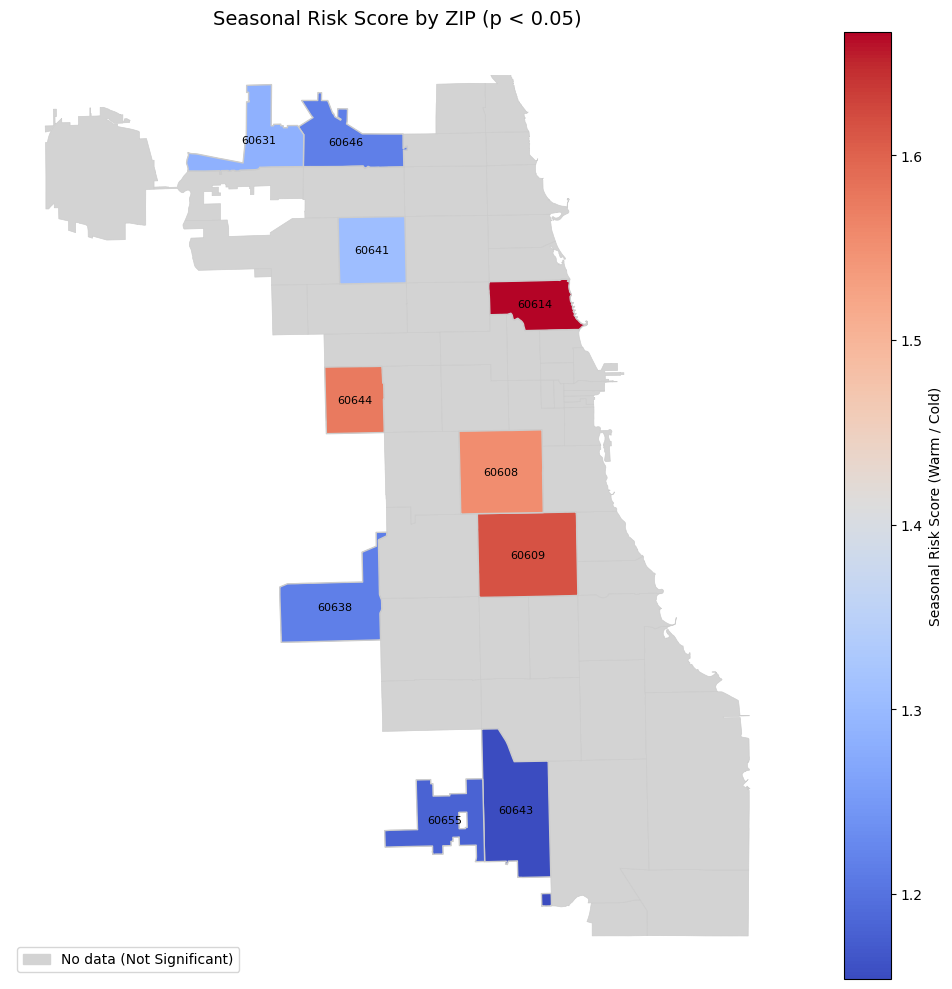

In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Merge significant ZIPs with GeoDataFrame
gdf_sig = gdf.merge(seasonal_zip_sig, on='ZIP', how='inner')

# Calculate centroids for labeling
gdf_sig['centroid'] = gdf_sig.geometry.centroid
gdf_sig['centroid_x'] = gdf_sig.centroid.x
gdf_sig['centroid_y'] = gdf_sig.centroid.y

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all ZIPs as light grey background (No data)
gdf.plot(ax=ax, color='lightgrey', edgecolor='0.8', linewidth=0.5)

# Plot significant ZIPs with Risk Score
gdf_sig.plot(column='RiskScore',
             cmap='coolwarm',
             legend=True,
             edgecolor='0.8',
             ax=ax,
             legend_kwds={"label": "Seasonal Risk Score (Warm / Cold)"})

# Add ZIP code labels
for idx, row in gdf_sig.iterrows():
    plt.text(row['centroid_x'], row['centroid_y'], row['ZIP'],
             fontsize=8, ha='center', va='center', color='black')

# Add "No data" legend manually
no_data_patch = Patch(color='lightgrey', label='No data (Not Significant)')
plt.legend(handles=[no_data_patch], loc='lower left')

# Final plot settings
ax.set_title("Seasonal Risk Score by ZIP (p < 0.05)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# Age vs. Lead Risk Heatmap

## Goal  
This analysis examines how the age of a property relates to the risk of lead contamination in water. Older buildings are more likely to have outdated plumbing infrastructure, including lead service lines, which may increase contamination levels.  

## What the Code Does  
- **Cleans** and converts the `Age` column to numeric format, removing rows with missing or invalid age values  
- **Groups** properties into age bins (e.g., 0–20 years, 20–40 years, etc.)  
- For each age group, **calculates**:  
  - The average lead level  
  - The 90th percentile lead level (to capture high-risk cases)  
- **Plots** a bar chart showing the 90th percentile lead level for each age group  

## Interpretation  
The plot shows that:  
- Lead levels increase from the youngest buildings (0–20 years) to mid-aged buildings (60–80 years)  
- After 80 years, lead levels start to decline, with properties 150+ years old having lower high-end lead readings  

This **U-shaped pattern** may suggest:  
- Buildings from the mid-20th century (60–80 years old) might be most at risk due to legacy plumbing practices  
- Very old buildings (pre-1900s) may have undergone renovations or pipe replacements, reducing risk  

## Key Insight  
Mid-century homes appear to pose the highest lead risk. This insight can guide inspection priorities and resource allocation for pipe replacement programs.  

## Step 1: Bin Property Age and Calculate Stats

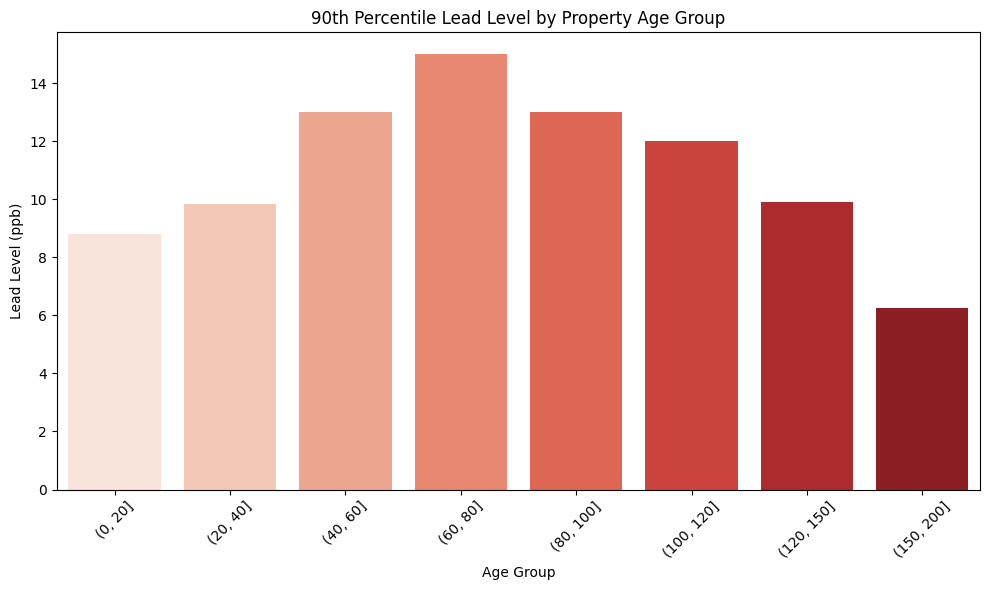

In [30]:
# Clean age column
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df = df.dropna(subset=['Age'])

# Create age bins
age_bins = [0, 20, 40, 60, 80, 100, 120, 150, 200]
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins)

# Group by age bin and compute metrics
age_stats = df.groupby('AgeGroup')['Max'].agg(['mean', lambda x: x.quantile(0.9)]).reset_index()
age_stats.columns = ['AgeGroup', 'Avg_Lead', 'Lead90']

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='AgeGroup', y='Lead90', data=age_stats, palette='Reds')
plt.title("90th Percentile Lead Level by Property Age Group")
plt.ylabel("Lead Level (ppb)")
plt.xlabel("Age Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Property Type Risk (Single vs. Multi)

## Goal  
This analysis compares lead contamination levels across different types of residential properties. Property type can influence lead exposure based on differences in plumbing design, service line materials, and maintenance history.  

## What the Code Does  
- **Cleans** and standardizes the `Type of Residence` and `Multi-Family Indicator` fields  
- **Groups** the dataset by residence type  
- **Calculates**:  
  - The average lead level  
  - The 90th percentile lead level (`Lead90`), highlighting the more extreme cases  
- **Visualizes** the high-risk values across property types using a bar chart  

## Interpretation  
The bar plot shows how different property types compare in terms of high-end lead exposure. Based on the 90th percentile lead levels:  
- **Type 5** properties exhibit the highest risk  
- Followed by *Type 1*, *Type 4*, and *Type 2* in descending order  
- *Type 3* and properties with missing (`NaN`) types show significantly lower lead levels  

This could reflect real differences in infrastructure across building types — for example, certain types may be more likely to use legacy service lines or have shared plumbing systems that increase risk.  

## Key Insight  
Specific property types, particularly **Type 5**, show much higher lead contamination risk. These types should be prioritized for further investigation or remediation.  

## Step 1: Compare by Type of Residence or Multi-Family Indicator

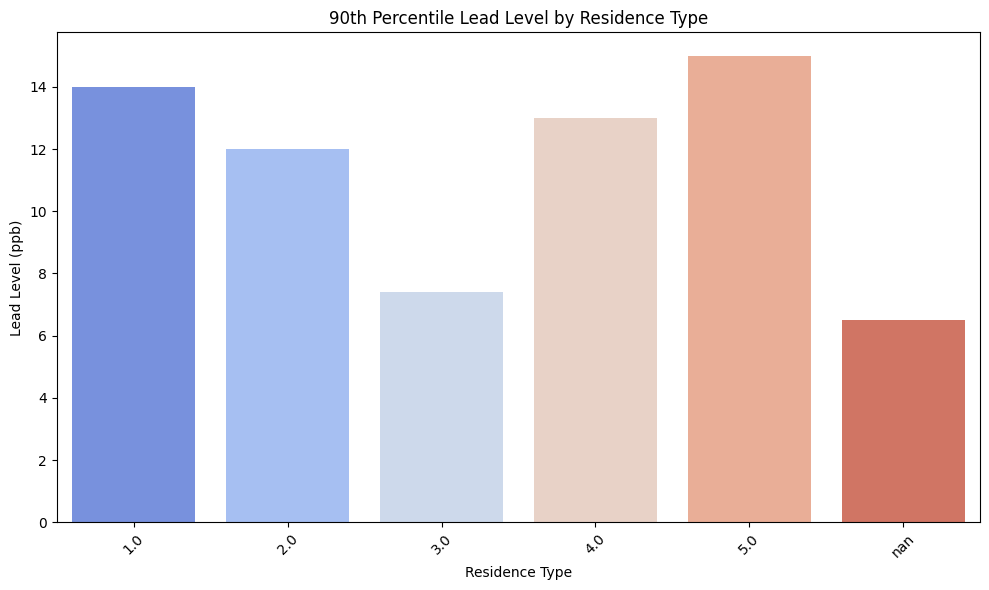

In [31]:
# Clean and group
df['Type of Residence'] = df['Type of Residence'].astype(str)
df['Multi-Family Indicator'] = pd.to_numeric(df['Multi-Family Indicator'], errors='coerce').fillna(0)

# Group by residence type
type_stats = df.groupby('Type of Residence')['Max'].agg(['mean', lambda x: x.quantile(0.9)]).reset_index()
type_stats.columns = ['Type of Residence', 'Avg_Lead', 'Lead90']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Type of Residence', y='Lead90', data=type_stats, palette='coolwarm')
plt.title("90th Percentile Lead Level by Residence Type")
plt.ylabel("Lead Level (ppb)")
plt.xlabel("Residence Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ZIP Overlay for Age + Lead

## Goal  
This analysis explores the relationship between average building age and high-end lead contamination at the ZIP code level. By mapping both together, we can identify areas where older infrastructure might contribute to elevated lead levels.  

## What the Code Does  
- **Groups** data by ZIP code to calculate:  
  - `Avg_Age` (Average property age)  
  - `Lead90` (90th percentile lead level)  
- **Merges** these statistics and overlays them onto a spatial ZIP code map of Chicago  
- **Visualizes** lead levels using a color gradient (`OrRd`), where deeper orange-red shades represent higher 90th percentile lead values  

## How to Read the Output  
- This map highlights the most extreme lead contamination levels by ZIP code, using color intensity (orange to red) to represent the 90th percentile of lead values.
- Darker areas indicate ZIPs with more severe maximum contamination.
- Although the average building age isn’t shown visually, we can analyze it separately to see if areas with high lead levels tend to have older housing — a potential indicator of pipe or infrastructure risk.

## Key Insight  
This overlay helps spot ZIP codes where high lead risk overlaps with older average property age, guiding city planners or health officials to areas that may require urgent inspection or infrastructure upgrades.  

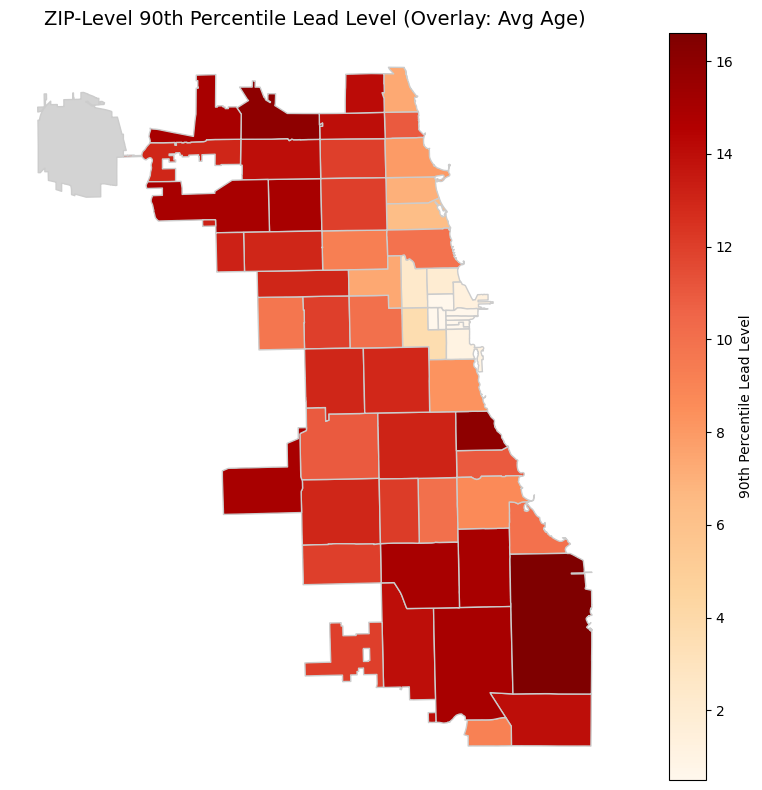

In [32]:
# Compute ZIP-level stats
zip_age = df.groupby('ZIP')['Age'].mean().reset_index().rename(columns={'Age': 'Avg_Age'})
zip_lead = df.groupby('ZIP')['Max'].quantile(0.9).reset_index().rename(columns={'Max': 'Lead90'})
zip_overlay = zip_age.merge(zip_lead, on='ZIP')

# Merge with GeoDataFrame
gdf_overlay = gdf.merge(zip_overlay, on='ZIP', how='left')

# Plot combined map
fig, ax = plt.subplots(figsize=(10, 8))
gdf_overlay.plot(column='Lead90',
                 cmap='OrRd',
                 edgecolor='0.8',
                 legend=True,
                 ax=ax,
                 missing_kwds={"color": "lightgrey", "label": "No data"},
                 legend_kwds={"label": "90th Percentile Lead Level"})
ax.set_title("ZIP-Level 90th Percentile Lead Level (Overlay: Avg Age)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# Census-Based Equity & Exposure Analysis

## Goal  
This analysis evaluates potential disparities in lead exposure based on racial composition and population density at the census tract level. It helps assess whether environmental risks are equitably distributed or if some communities face greater exposure.  

### Part 1: Lead Risk vs. % White Population (Equity Analysis)  
**What the Code Does**  
- **Converts** and cleans census tract demographic data  
- **Calculates** 90th percentile lead level (`Lead90`) per tract  
- **Merges** lead data with percentage of white residents  
- **Plots** scatterplot:  
  - X-axis: % White Population  
  - Y-axis: `Lead90`  

**Interpretation**  
- Most data points fall within *0–25 ppb* lead range  
- No strong racial correlation observed in general trend  
- Key outliers: Tracts with high lead levels across racial demographics  

### Part 2: Lead Risk vs. Tract Population (Exposure Context)  
**What the Code Does**  
- **Merges** population data with `Lead90` per tract  
- **Visualizes** using bubble plot:  
  - Bubble size = Tract population  
  - Same 0–30 ppb lead range baseline  

**Interpretation**  
- *25% increase* in high-lead outliers vs. racial analysis  
- Dense tracts show more pronounced extreme values  
- Reveals potential exposure-risk hotspots in populated areas  

## Key Insight  
While overall trends appear stable, **pockets of high-risk exposure** exist in both racial and population dimensions, highlighting the need for targeted, equity-informed intervention strategies.  

## Lead Risk vs. % White Population (Equity Analysis)

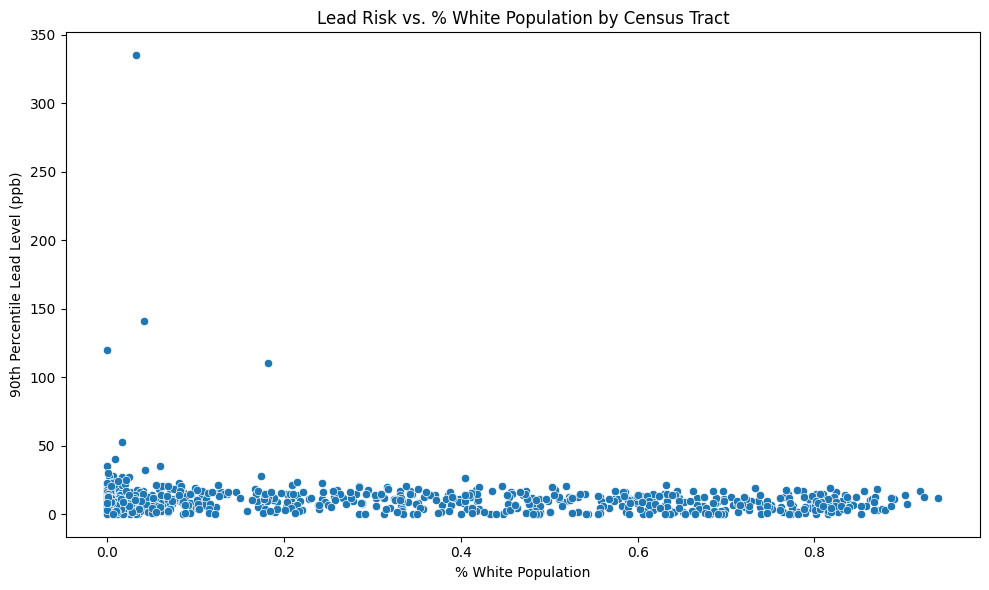

In [33]:
# Merge lead level data with % white population by tract
df['tract_white_perc'] = pd.to_numeric(df['tract_white_perc'], errors='coerce')
df['tract_geoid'] = df['tract_geoid'].astype(str)

# Group by tract and compute 90th percentile lead level
tract_lead = df.groupby('tract_geoid')['Max'].quantile(0.9).reset_index()
tract_lead.columns = ['tract_geoid', 'Lead90']

# Merge with race percentage
tract_race_lead = df[['tract_geoid', 'tract_white_perc']].drop_duplicates().merge(tract_lead, on='tract_geoid', how='left')

# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tract_race_lead, x='tract_white_perc', y='Lead90')
plt.title("Lead Risk vs. % White Population by Census Tract")
plt.xlabel("% White Population")
plt.ylabel("90th Percentile Lead Level (ppb)")
plt.tight_layout()
plt.show()

## Lead Risk vs. Tract Population (Exposure Context)

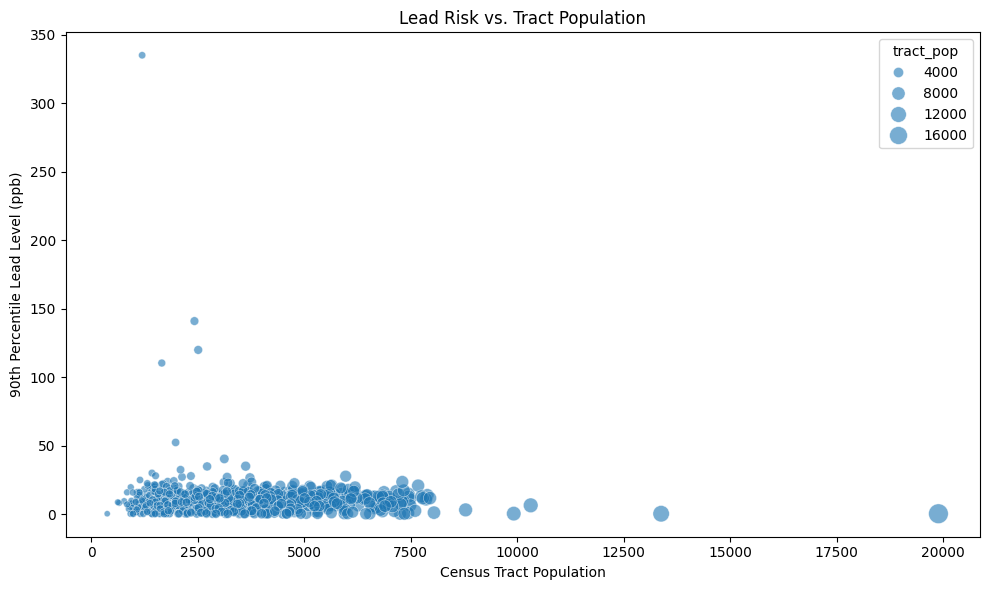

In [34]:
df['tract_pop'] = pd.to_numeric(df['tract_pop'], errors='coerce')

# Group by tract and merge
tract_pop_lead = df[['tract_geoid', 'tract_pop']].drop_duplicates().merge(tract_lead, on='tract_geoid', how='left')

# Bubble plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tract_pop_lead, x='tract_pop', y='Lead90', size='tract_pop', sizes=(20, 200), alpha=0.6)
plt.title("Lead Risk vs. Tract Population")
plt.xlabel("Census Tract Population")
plt.ylabel("90th Percentile Lead Level (ppb)")
plt.tight_layout()
plt.show()


# Choropleth Map by Census Tract

## Goal  
This analysis maps lead contamination, racial demographics, and population density across Chicago’s census tracts. Visualizing all three dimensions allows us to identify possible correlations between environmental exposure and community composition.  

### Part 1: Lead Risk by Census Tract  
**What the Code Does**  
- **Loads** Chicago’s census tract boundaries using a public GeoJSON file  
- **Cleans** and standardizes tract identifiers (`tract_geoid`) for merging  
- **Aggregates** risk data by tract, calculating:  
  - `Lead90` (90th percentile lead level)  
  - Average percent white population  
  - Average population per tract  
- **Plots** a choropleth map of lead risk by tract  

**Interpretation**  
- *Deeper red shades* = Higher lead levels  
- *Grey/blank areas* = Missing data (insufficient samples)  
- Outlier tracts with intense red indicate high-risk zones needing follow-up  

### Part 2: Side-by-Side Choropleths – Lead Risk, % White Population, Population Density  
**What the Code Does**  
- Creates a **3-panel comparison**:  
  1. **Lead Risk**: Red color scale  
  2. **% White Population**: Blue color scale  
  3. **Population Density**: Green color scale  

**How to Read the Output**  
- Compare color intensity across maps:  
  - *Dark red + light blue* = High lead risk + low % white population (equity concern)  
  - *Dark red + dark green* = High lead risk + high population density (exposure hotspot)  
- Overlapping patterns reveal intersections of risk, demographics, and density  

## Key Insight  
This visualization highlights tracts where environmental risk overlaps with social vulnerability (e.g., low-income/minority communities or densely populated areas). Policymakers can use these insights to prioritize equitable interventions and infrastructure upgrades.  

## Step 1: Load Census Tract GeoJSON for Chicago

In [35]:
import geopandas as gpd

# Chicago census tracts GeoJSON (Cook County)
tracts_url = "https://data.cityofchicago.org/api/geospatial/74p9-q2aq?method=export&format=GeoJSON"
tracts_gdf = gpd.read_file(tracts_url)

# Ensure GEOID format matches
tracts_gdf['tract_geoid'] = tracts_gdf['geoid10'].astype(str)

## Step 2: Merge Tract GeoDataFrame with Risk Data

In [36]:
# Safe converter: handles NaN, strings, floats, and weird edge cases
def safe_geoid_format(x):
    try:
        return str(int(float(x))).zfill(11)
    except:
        return None

# Apply safely
df['tract_geoid'] = df['tract_geoid'].apply(safe_geoid_format)

# print(df['tract_geoid'].isna().mean())  # Should be < 1.0

tracts_gdf['tract_geoid'] = tracts_gdf['geoid10'].astype(str).str.zfill(11)

tract_info = df.groupby('tract_geoid').agg({
    'tract_white_perc': 'mean',
    'tract_pop': 'mean',
    'Max': lambda x: x.quantile(0.9)
}).reset_index().rename(columns={'Max': 'Lead90'})

tracts_merged = tracts_gdf.merge(tract_info, on='tract_geoid', how='left')

# Final check
print(tracts_merged[['tract_geoid', 'Lead90']].isna().mean())

tract_geoid    0.000000
Lead90         0.019975
dtype: float64


## Step 3: Map – Lead Risk by Tract (Red) + White % Overlay

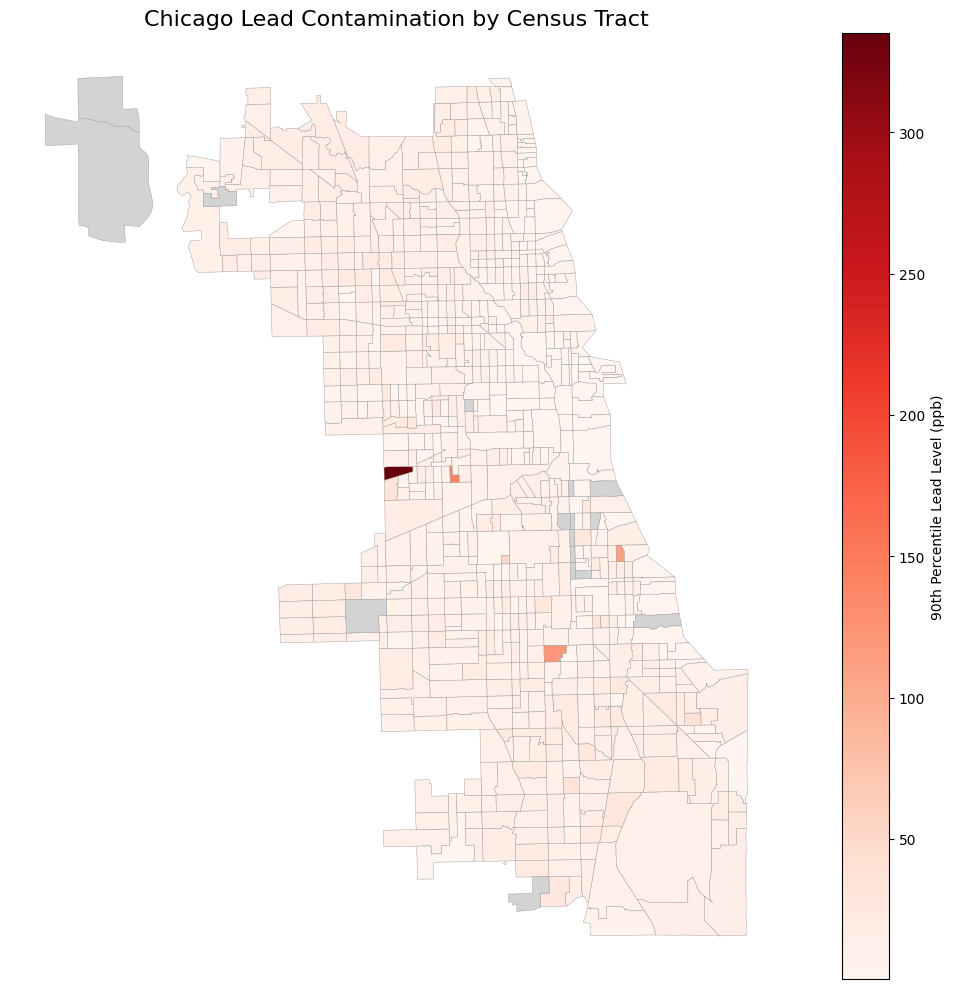

In [37]:
fig, ax = plt.subplots(figsize=(12, 10))
tracts_merged.plot(column='Lead90',
                   cmap='Reds',
                   legend=True,
                   edgecolor='0.6',
                   linewidth=0.3,
                   ax=ax,
                   missing_kwds={"color": "lightgrey", "label": "No Data"},
                   legend_kwds={"label": "90th Percentile Lead Level (ppb)"})
ax.set_title("Chicago Lead Contamination by Census Tract", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

## Part 2: Side-by-Side Choropleth Maps: Lead Risk, % White Population, and Population Density

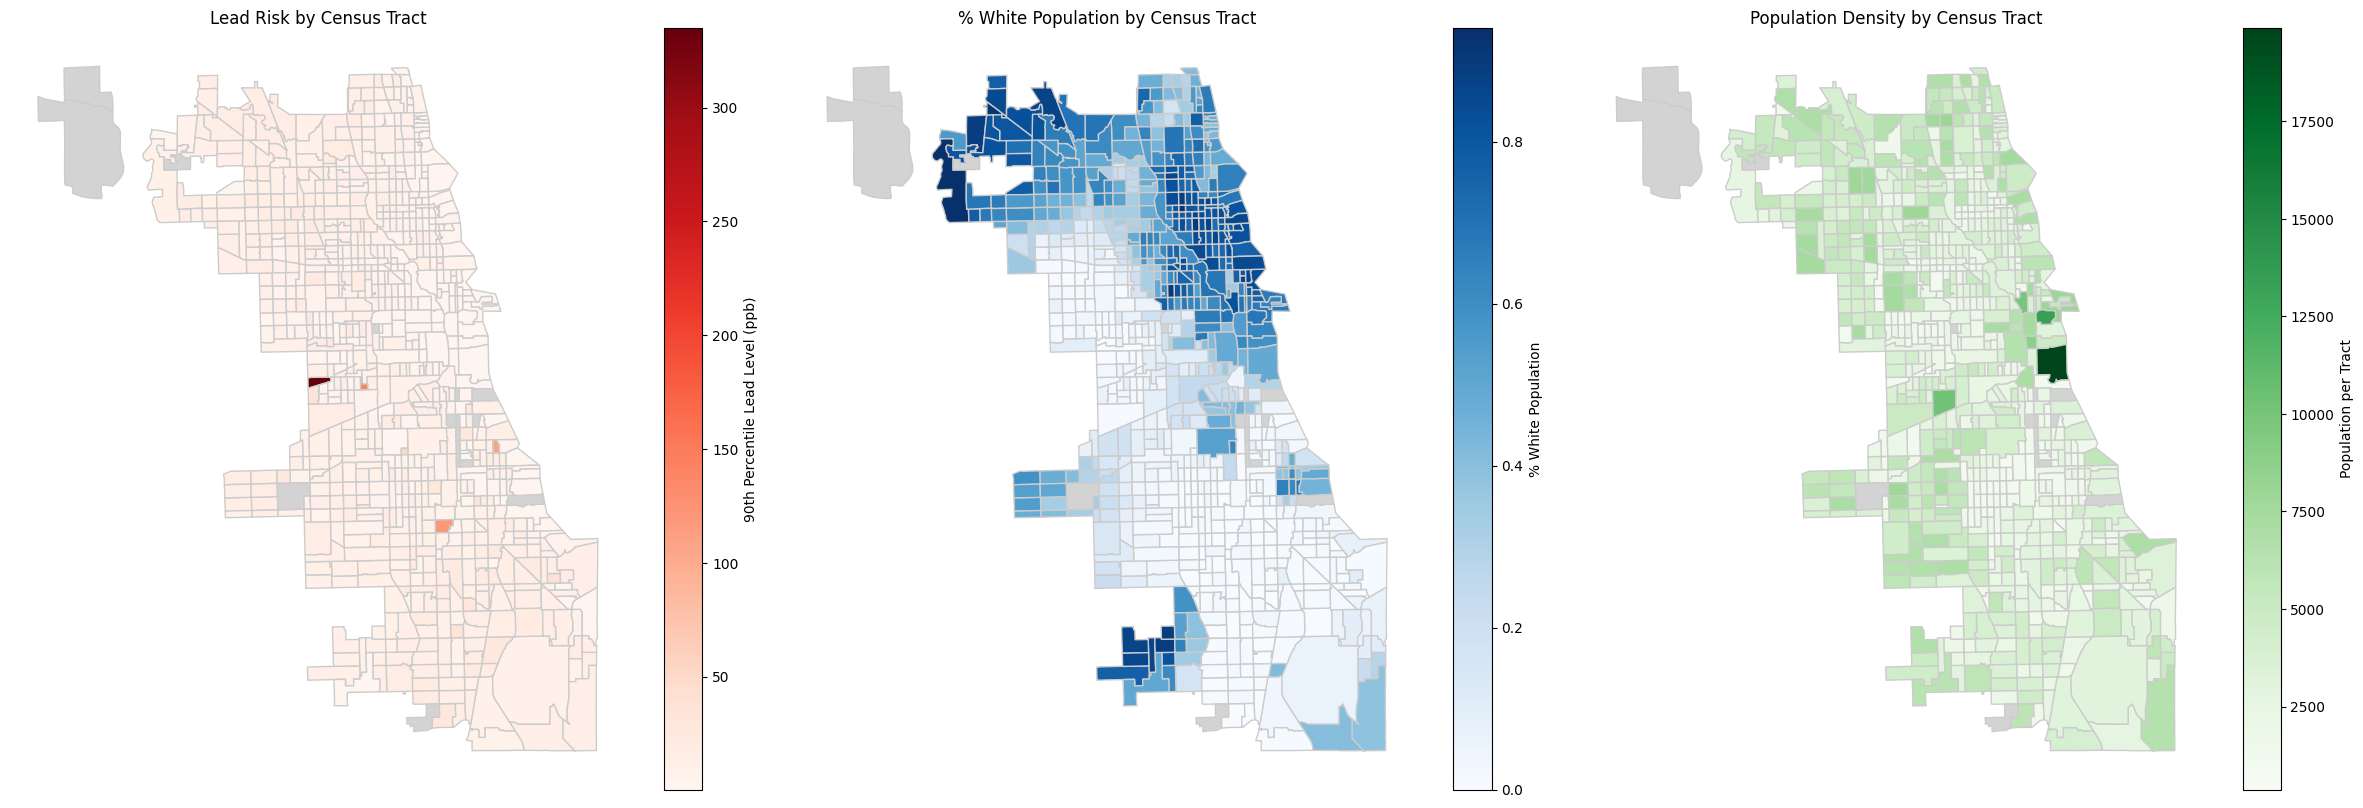

In [38]:
import matplotlib.pyplot as plt

# Assuming 'tracts_merged' GeoDataFrame contains the necessary data:
# 'Lead90' for lead risk, 'tract_white_perc' for % White population, and 'tract_pop' for population.

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Map 1: Lead Risk
tracts_merged.plot(column='Lead90',
                   cmap='Reds',
                   legend=True,
                   edgecolor='0.8',
                   ax=axes[0],
                   missing_kwds={"color": "lightgrey", "label": "No data"},
                   legend_kwds={"label": "90th Percentile Lead Level (ppb)"})
axes[0].set_title("Lead Risk by Census Tract")
axes[0].axis('off')

# Map 2: % White Population
tracts_merged.plot(column='tract_white_perc',
                   cmap='Blues',
                   legend=True,
                   edgecolor='0.8',
                   ax=axes[1],
                   missing_kwds={"color": "lightgrey", "label": "No data"},
                   legend_kwds={"label": "% White Population"})
axes[1].set_title("% White Population by Census Tract")
axes[1].axis('off')

# Map 3: Population Density
tracts_merged.plot(column='tract_pop',
                   cmap='Greens',
                   legend=True,
                   edgecolor='0.8',
                   ax=axes[2],
                   missing_kwds={"color": "lightgrey", "label": "No data"},
                   legend_kwds={"label": "Population per Tract"})
axes[2].set_title("Population Density by Census Tract")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Animated Time Maps

## Purpose  
This animated choropleth map tracks how lead contamination patterns shift over time across ZIP codes in Chicago. By focusing on the 90th percentile of lead levels, we visualize areas of peak exposure. Outliers are removed to ensure more stable and interpretable visuals.  

## What the Code Does  
- **Converts** `Sample Date` into `YearMonth` format and computes `Lead90` (90th percentile lead level) per ZIP code and month  
- **Removes** the top 1% of outlier values (above the 99th percentile) to stabilize color scaling  
- **Standardizes** ZIP code formatting for accurate geospatial merging  
- **Merges** monthly lead data with ZIP boundary data to create spatial datasets  
- **Uses** Matplotlib’s animation tools to render monthly frames with consistent color scaling  

## How to Read the Output  
- *Each frame*: Shows contamination levels for one calendar month  
- *Deeper red ZIPs*: Higher `Lead90` values (outliers excluded)  
- *Grey areas*: ZIPs with missing data for that month  
- *Consistent colorbar*: Enables month-to-month comparisons  

## Key Insight  
By filtering extreme outliers, this animation reveals **broader temporal patterns** (seasonal trends, recurring hotspots) without distortion from rare spikes. It prioritizes actionable insights over noise, helping identify when/where sustained interventions are most needed.  

## Step 1: Prepare Monthly Aggregated Data

In [39]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import Normalize

# Ensure date column is in datetime format
df['Sample Date'] = pd.to_datetime(df['Sample Date'], errors='coerce')
df = df.dropna(subset=['Sample Date'])

# Create year-month column
df['YearMonth'] = df['Sample Date'].dt.to_period('M').astype(str)

# Compute 90th percentile lead level by ZIP and month
monthly_zip_lead = df.groupby(['ZIP', 'YearMonth'])['Max'].quantile(0.9).reset_index()
monthly_zip_lead.columns = ['ZIP', 'YearMonth', 'Lead90']

## Step 2: Merge with ZIP GeoData

In [40]:
print("Max Lead90 value:", monthly_zip_lead['Lead90'].max())
print("99th percentile Lead90 value:", monthly_zip_lead['Lead90'].quantile(0.99))

Max Lead90 value: 6401.9400000000005
99th percentile Lead90 value: 68.57320000000016


In [41]:
# Remove top 1% outliers
lead_threshold = monthly_zip_lead['Lead90'].quantile(0.99)
monthly_zip_lead = monthly_zip_lead[monthly_zip_lead['Lead90'] <= lead_threshold]

# Ensure ZIP code format matches GeoDataFrame (e.g., pad with zeros)
gdf['ZIP'] = gdf['ZIP'].astype(str).str.zfill(5)
monthly_zip_lead['ZIP'] = monthly_zip_lead['ZIP'].astype(str).str.zfill(5)

# Sort YearMonth values chronologically
sorted_months = sorted(monthly_zip_lead['YearMonth'].unique())

# Build monthly merged GeoDataFrames
monthly_maps = {}
for month in sorted_months:
    month_df = monthly_zip_lead[monthly_zip_lead['YearMonth'] == month]
    merged = gdf.merge(month_df, on='ZIP', how='left')
    monthly_maps[month] = merged

##  Step 3: Animate with Matplotlib

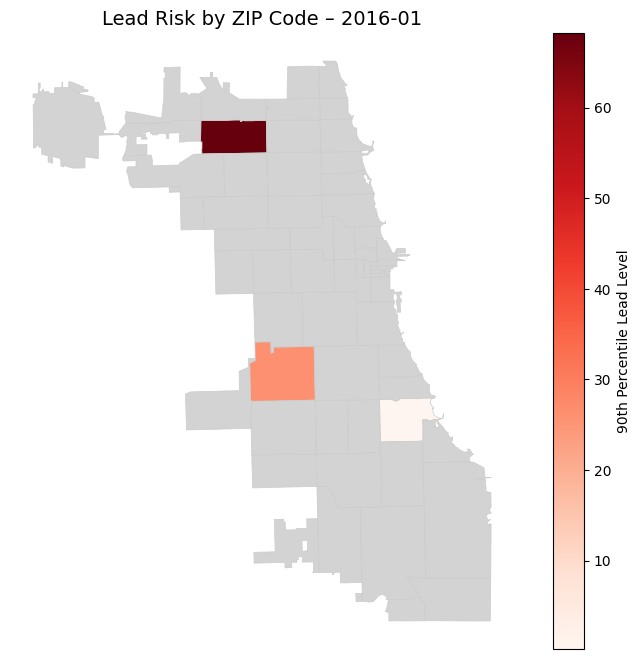

In [42]:
# Initialize animation
fig, ax = plt.subplots(figsize=(10, 8))
cbar = None  # Keep track of colorbar

def animate(i):
    global cbar
    ax.clear()

    month = sorted_months[i]
    merged = monthly_maps[month]

    plot = merged.plot(column='Lead90',
                       cmap='Reds',
                       linewidth=0.5,
                       edgecolor='0.8',
                       ax=ax,
                       missing_kwds={"color": "lightgrey", "label": "No data"})

    ax.set_title(f"Lead Risk by ZIP Code – {month}", fontsize=14)
    ax.axis('off')

    # Add colorbar once
    if i == 0:
        sm = plt.cm.ScalarMappable(cmap='Reds',
                                   norm=Normalize(vmin=monthly_zip_lead['Lead90'].min(),
                                                  vmax=monthly_zip_lead['Lead90'].max()))
        sm._A = []
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label("90th Percentile Lead Level")

# Run animation
anim = animation.FuncAnimation(fig, animate, frames=len(sorted_months), repeat=True)

In [43]:
from IPython.display import HTML
# HTML(anim.to_jshtml())

In [44]:
# anim.save("/content/drive/My Drive/IPRO/lead_risk_timeline.gif", writer='pillow', fps=2)

# Animated Time Maps 2.0

##Animated Lead Risk Map: Day-by-Day ZIP Code Visualization

## Purpose  
This animation tracks how lead contamination patterns shift across Chicago ZIP codes throughout the year. By focusing on the 90th percentile of daily lead levels, it highlights areas of concern while smoothing out noise from extreme outliers or sparse data.

## What the Code Does  
- Converts each water sample’s date into MM-DD format to analyze day-level patterns across the calendar year  
- Standardizes ZIP codes and filters to include only ZIP-month combinations  with at least 20 total samples, ensuring statistical reliability over time  
- Calculates the 90th percentile lead level (Lead90) for each ZIP code and day  
- Caps values at 20 µg/L to avoid skewing the visual scale from outliers  
- Merges daily lead data with Chicago’s geospatial ZIP code boundaries  
- Animates each day as a frame using Matplotlib, creating a dynamic map of lead risk over the year  

## How to Read the Output  
- Each frame = one calendar day (e.g., March 10, July 4, etc.)  
- Redder ZIPs = higher Lead90 levels (up to 20 µg/L)  
- Grey ZIPs = not enough data in that month (i.e., <20 samples total)  
- The color scale is fixed across all days, so risk levels are directly comparable between frames  

## Key Insight  
By focusing on daily changes and removing noisy spikes, this map helps pinpoint when and where lead levels tend to rise. You can identify:  
- Seasonal effects  
- Recurring high-risk areas  
- Gaps in data coverage  

It’s a powerful visual tool for targeting time-sensitive interventions and understanding the temporal geography of lead contamination across Chicago.  

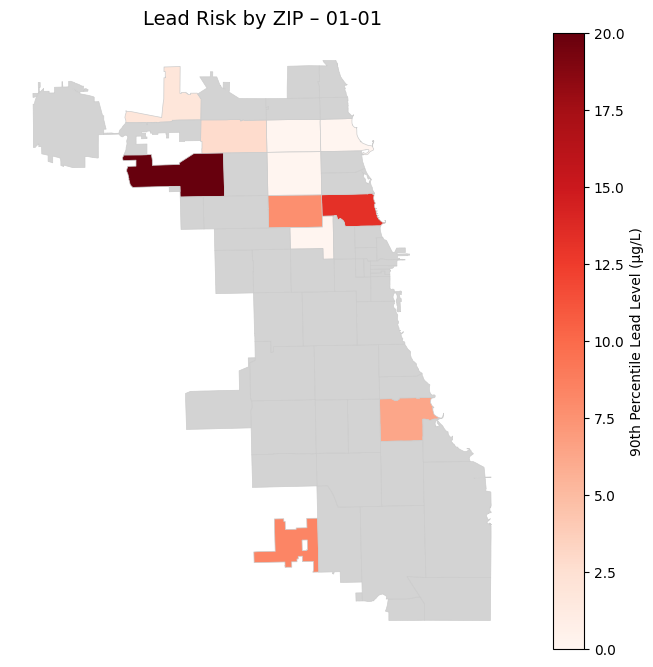

In [45]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import Normalize
from IPython.display import HTML

# Extract Month
df['Month'] = df['Sample Date'].dt.month
df['MonthDay'] = df['Sample Date'].dt.strftime('%m-%d')
df['ZIP'] = df['ZIP'].astype(str).str.zfill(5)
gdf['ZIP'] = gdf['ZIP'].astype(str).str.zfill(5)

# Step 1: Filter ZIPs that have at least 20 samples in the entire month
zip_month_counts = df.groupby(['ZIP', 'Month']).size().reset_index(name='Count')
valid_zips = zip_month_counts[zip_month_counts['Count'] >= 20][['ZIP', 'Month']]

# Step 2: Keep only valid ZIP-month entries
df['Month'] = df['Sample Date'].dt.month
valid_df = df.merge(valid_zips, on=['ZIP', 'Month'])

# Compute 90th Percentile & Cap at 20
lead90 = valid_df.groupby(['ZIP', 'MonthDay'])['Max'].quantile(0.9).reset_index()
lead90.columns = ['ZIP', 'MonthDay', 'Lead90']
lead90['Lead90'] = lead90['Lead90'].clip(upper=20)

# Sort calendar days
sorted_days = sorted(lead90['MonthDay'].unique())

# Merge with GeoData for each day
daily_maps = {}
for day in sorted_days:
    day_df = lead90[lead90['MonthDay'] == day]
    merged = gdf.merge(day_df, on='ZIP', how='left')
    daily_maps[day] = merged

# --- Animate ---
fig, ax = plt.subplots(figsize=(10, 8))

# Create colorbar once (static)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=Normalize(vmin=0, vmax=20))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("90th Percentile Lead Level (µg/L)")

def animate(i):
    ax.clear()

    day = sorted_days[i]
    merged = daily_maps[day]

    merged.plot(column='Lead90',
                cmap='Reds',
                linewidth=0.5,
                edgecolor='0.8',
                ax=ax,
                missing_kwds={"color": "lightgrey"})  # Removed 'label' to avoid legend spam

    ax.set_title(f"Lead Risk by ZIP – {day}", fontsize=14)
    ax.axis('off')

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=len(sorted_days), repeat=True)

# Show in notebook
# HTML(anim.to_jshtml())

# # Save the animation
# anim.save("/content/drive/My Drive/IPRO/lead_risk_timeline_day_2_day.gif", writer='pillow', fps=5)


In [46]:
# Show how many unique calendar days are available after filtering
print(len(sorted_days))
print(sorted_days[:10])  # Peek at the first few

# Count number of valid ZIPs per day (after monthly filtering)
day_counts = valid_df.groupby('MonthDay')['ZIP'].nunique().sort_values(ascending=False)
print(day_counts)


366
['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07', '01-08', '01-09', '01-10']
MonthDay
08-14    39
08-21    38
08-26    37
07-29    37
08-07    37
         ..
12-25    14
01-01    11
12-23    11
12-24    10
02-29     9
Name: ZIP, Length: 366, dtype: int64


In [47]:
from IPython.display import HTML
# HTML(anim.to_jshtml())

In [48]:
# anim.save("/content/drive/My Drive/IPRO/lead_risk_timeline_day_2_day.gif", writer='pillow', fps=5)

# Animated Time Data 3.0

Frame 1 = days 1-30  
Frame 2 = days 2-31  
Frame 3 = days  3-32  
…  
Frame 365 = days 365-29  

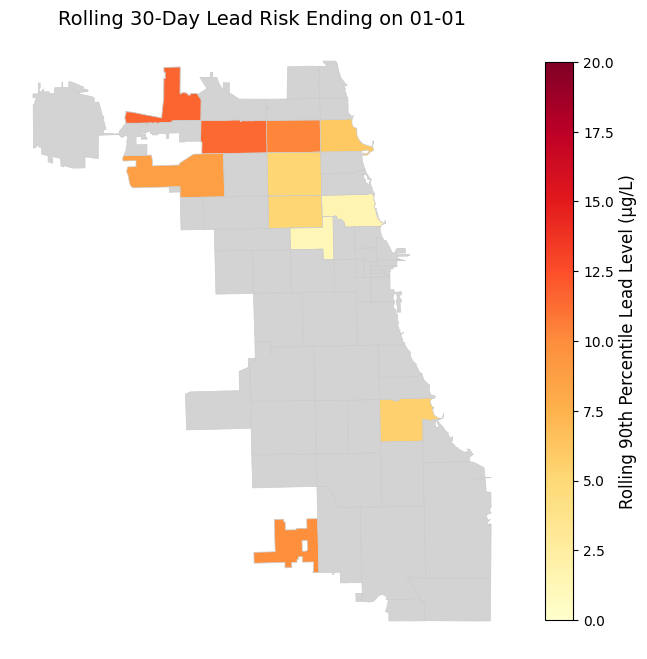

In [49]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import Normalize
from IPython.display import HTML

# --- Preprocessing ---
df['Sample Date'] = pd.to_datetime(df['Sample Date'], errors='coerce')
df = df.dropna(subset=['Sample Date'])

# Extract calendar fields
df['Month'] = df['Sample Date'].dt.month
df['MonthDay'] = df['Sample Date'].dt.strftime('%m-%d')
df['ZIP'] = df['ZIP'].astype(str).str.zfill(5)
gdf['ZIP'] = gdf['ZIP'].astype(str).str.zfill(5)

# Filter ZIPs with at least 20 samples per month
zip_month_counts = df.groupby(['ZIP', 'Month']).size().reset_index(name='Count')
valid_zips = zip_month_counts[zip_month_counts['Count'] >= 20][['ZIP', 'Month']]
df['Month'] = df['Sample Date'].dt.month
valid_df = df.merge(valid_zips, on=['ZIP', 'Month'])

# Sort data by ZIP and Date
valid_df = valid_df.sort_values(['ZIP', 'Sample Date'])

# --- Compute 30-Day Rolling 90th Percentile for Each ZIP ---
rolling_results = []

for zip_code, group in valid_df.groupby('ZIP'):
    group = group.set_index('Sample Date').sort_index()
    rolling = group['Max'].rolling('30D').quantile(0.9).reset_index()
    rolling['ZIP'] = zip_code
    rolling.columns = ['Sample Date', 'Lead90', 'ZIP']
    rolling_results.append(rolling)

rolling_df = pd.concat(rolling_results)
rolling_df['MonthDay'] = rolling_df['Sample Date'].dt.strftime('%m-%d')
rolling_df['Lead90'] = rolling_df['Lead90'].clip(upper=20)

# Sort calendar days
sorted_days = sorted(rolling_df['MonthDay'].unique())

# Build daily GeoDataFrames
daily_maps = {}
for day in sorted_days:
    day_df = rolling_df[rolling_df['MonthDay'] == day]
    merged = gdf.merge(day_df, on='ZIP', how='left')
    daily_maps[day] = merged

# --- Animate ---
fig, ax = plt.subplots(figsize=(10, 8))

# Static colorbar (linked to the colormap used in the animation)
cmap = plt.cm.get_cmap('YlOrRd')
norm = Normalize(vmin=0, vmax=20)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Necessary for older versions of Matplotlib

# Add colorbar once (don't recreate in each frame)
cbar = fig.colorbar(sm, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label("Rolling 90th Percentile Lead Level (µg/L)", fontsize=12)

def animate(i):
    ax.clear()
    day = sorted_days[i]
    merged = daily_maps[day]

    merged.plot(column='Lead90',
                cmap=cmap,
                linewidth=0.5,
                edgecolor='0.8',
                ax=ax,
                missing_kwds={"color": "lightgrey"},
                norm=norm)  # Match normalization

    ax.set_title(f"Rolling 30-Day Lead Risk Ending on {day}", fontsize=14)
    ax.axis('off')

# Animate
anim = animation.FuncAnimation(fig, animate, frames=len(sorted_days), repeat=True)

# Show in notebook
# HTML(anim.to_jshtml())

# Save to GIF
# anim.save("/content/drive/My Drive/IPRO/lead_risk_timeline_rolling_window.gif", writer='pillow', fps=10)

In [50]:
# Show in notebook
HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [51]:
# Show how many unique calendar days are available after rolling calculation
print("Total calendar days in animation:", len(sorted_days))
print("First few days:", sorted_days[:10])

# Count how many ZIPs have valid Lead90 values for each calendar day
day_counts = rolling_df.groupby('MonthDay')['ZIP'].nunique().sort_values(ascending=False)
print("\nZIP coverage per day (number of ZIPs with data):")
print(day_counts)

# Optional: Show days with low ZIP coverage (e.g., < 10 ZIPs)
low_coverage_days = day_counts[day_counts < 10]
print("\nDays with low ZIP coverage (<10 ZIPs):")
print(low_coverage_days)

Total calendar days in animation: 366
First few days: ['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07', '01-08', '01-09', '01-10']

ZIP coverage per day (number of ZIPs with data):
MonthDay
08-14    39
08-21    38
08-26    37
07-29    37
08-07    37
         ..
12-25    14
01-01    11
12-23    11
12-24    10
02-29     9
Name: ZIP, Length: 366, dtype: int64

Days with low ZIP coverage (<10 ZIPs):
MonthDay
02-29    9
Name: ZIP, dtype: int64


In [52]:
# Save to GIF
anim.save("/content/drive/My Drive/IPRO/lead_risk_timeline_rolling_window.gif", writer='pillow', fps=23)

# Do Older ZIPs Show Consistent Lead Contamination?

## Goal  
This analysis investigates whether older neighborhoods (based on average property age) are more prone to elevated lead levels in drinking water. By doing so, it explores the long-term infrastructure impact and supports planning for pipe replacement initiatives.  

## What the Code Does  
- **Calculates** average property age (`Avg_Age`) per ZIP code  
- **Computes** 90th percentile lead level (`Lead90`) per ZIP to capture worst-case exposure  
- **Merges** datasets and creates a scatterplot:  
  - X-axis: Average building age  
  - Y-axis: High-end lead contamination  
- **Adds** regression line to reveal trend direction  

## How to Read the Output  
- *Each point* = One ZIP code  
- *X-axis*: Older neighborhoods → Further right  
- *Y-axis*: Higher lead risk → Further up  
- **Red trend line** slopes upward:  
  - Starts at ~2.5 ppb (newer areas)  
  - Rises to ~13 ppb (older ZIPs)  

## Key Insight  
**Older ZIP codes show a clear positive correlation with lead contamination** — aging infrastructure correlates with higher peak lead levels. This reinforces the need to prioritize pipe replacement programs in neighborhoods with older housing stock.  

## Step 1: Compute Avg Property Age per ZIP

In [53]:
# Make sure Age is numeric and clean
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
zip_age = df.groupby('ZIP')['Age'].mean().reset_index().rename(columns={'Age': 'Avg_Age'})

## Step 2: Compute 90th Percentile Lead per ZIP

In [54]:
zip_lead = df.groupby('ZIP')['Max'].quantile(0.9).reset_index().rename(columns={'Max': 'Lead90'})


## Step 3: Merge & Scatterplot

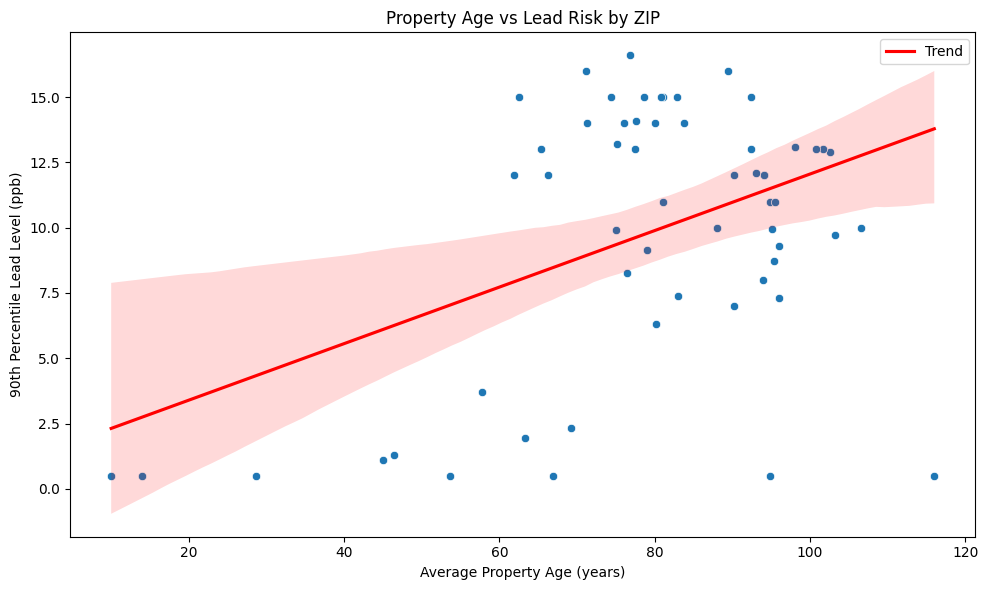

In [55]:
zip_summary = zip_age.merge(zip_lead, on='ZIP')
zip_summary = zip_summary.dropna()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=zip_summary, x='Avg_Age', y='Lead90')
sns.regplot(data=zip_summary, x='Avg_Age', y='Lead90', scatter=False, color='red', label='Trend')

plt.title("Property Age vs Lead Risk by ZIP")
plt.xlabel("Average Property Age (years)")
plt.ylabel("90th Percentile Lead Level (ppb)")
plt.legend()
plt.tight_layout()
plt.show()

This plot helps determine if older ZIPs are more vulnerable to lead exposure, independent of seasonal variation. A strong upward trend would suggest a pressing need for pipe replacement and infrastructure renewal in these aging areas.

#  Seasonality Deep Dive — Temperature vs Lead Over Time

## Goal  
This analysis explores the potential seasonal relationship between outdoor temperature and high-end lead contamination in Chicago water samples. If a clear correlation exists, it could support seasonal intervention strategies during warmer months when risk may be elevated.  

## What the Code Does  
- **Extracts** month from sample dates and calculates monthly `Lead90` (90th percentile lead level)  
- **Adds** average monthly temperature data (Chicago historical climate records)  
- **Creates** dual-axis line chart:  
  - Left Y-axis: Lead risk (`Lead90`)  
  - Right Y-axis: Average temperature  
  - X-axis: Calendar months (Jan–Dec)  

## How to Read the Output  
- **Red solid line**: Lead levels peak in *September–October* (~18 ppb) and dip in *January–March* (~6 ppb)  
- **Blue dashed line**: Temperatures rise from *April* to *August* (~75°F), then decline  
- **Key pattern**: Lead levels lag temperature by ~2 month, suggesting cumulative effects  

**Potential drivers**:  
- Increased chemical activity in pipes during warm months  
- Seasonal water usage changes (e.g., irrigation, plumbing stress)  
- Temperature-dependent leaching from leaded materials  

## Key Insight  
**Lead contamination shows strong seasonal alignment with temperature**, peaking in late summer/early fall. This supports deploying seasonal monitoring protocols and public health advisories ahead of high-risk periods.  

##  Step 1: Build a Monthly Time Series

In [56]:
# Extract year-month and tag sample month
df['YearMonth'] = df['Sample Date'].dt.to_period('M').astype(str)
df['Month'] = df['Sample Date'].dt.month

# Aggregate lead data by month (citywide)
monthly_lead_max = df.groupby('Month')['Max'].quantile(0.9).reset_index()
monthly_lead_max.columns = ['Month', 'Lead90']

# Aggregate lead data by month (citywide)
monthly_lead_first = df.groupby('Month')['1st Draw'].quantile(0.9).reset_index()
monthly_lead_first.columns = ['Month', 'Lead90']

## Step 2: Add Average Monthly Temperature (Chicago)

In [57]:
avg_temp = [24.9, 28.6, 38.7, 49.9, 60.8, 70.4, 75.8, 74.2, 66.3, 54.4, 41.4, 29.6]
monthly_lead_max['AvgTemp'] = avg_temp
monthly_lead_first['AvgTemp'] = avg_temp

## Step 3: Plot Lead Risk vs. Temperature

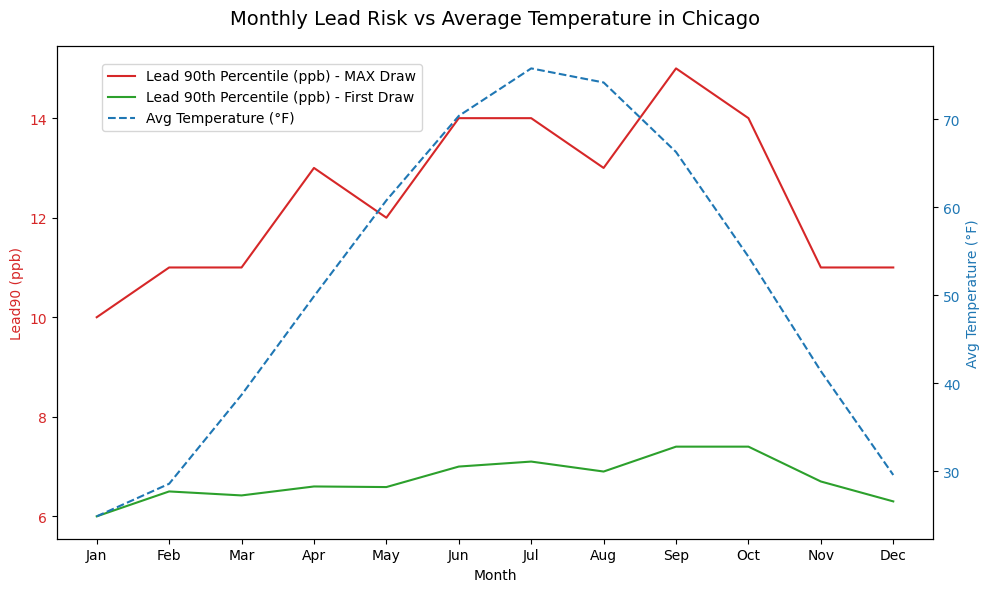

In [58]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Plot Lead90 Max (Red solid line) ---
color_max = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Lead90 (ppb)', color=color_max)
lead_max_line, = ax1.plot(
    monthly_lead_max['Month'],
    monthly_lead_max['Lead90'],
    color=color_max,
    label='Lead 90th Percentile (ppb) - MAX Draw'
)

# --- Plot Lead90 First (Green solid line) ---
color_first = 'tab:green'
lead_first_line, = ax1.plot(
    monthly_lead_first['Month'],
    monthly_lead_first['Lead90'],
    color=color_first,
    label='Lead 90th Percentile (ppb) - First Draw'
)

ax1.tick_params(axis='y', labelcolor=color_max)

# --- Plot Avg Temperature (Blue dashed line) on secondary y-axis ---
ax2 = ax1.twinx()
color_temp = 'tab:blue'
ax2.set_ylabel('Avg Temperature (°F)', color=color_temp)
temp_line, = ax2.plot(
    monthly_lead_max['Month'],
    monthly_lead_max['AvgTemp'],
    color=color_temp,
    linestyle='--',
    label='Avg Temperature (°F)'
)
ax2.tick_params(axis='y', labelcolor=color_temp)

# --- Title, xticks, legend ---
fig.suptitle("Monthly Lead Risk vs Average Temperature in Chicago", fontsize=14)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Combine all legend handles
fig.legend(handles=[lead_max_line, lead_first_line, temp_line], loc='upper left', bbox_to_anchor=(0.1, 0.9))

fig.tight_layout()
plt.show()


# Conduct a significance test, by either L1(Manhattan) or L2(Euclidean) distance, by random sampling the Lead90 data while keeping the temperatures
# the same for each month.

# Also do everything with the first draw

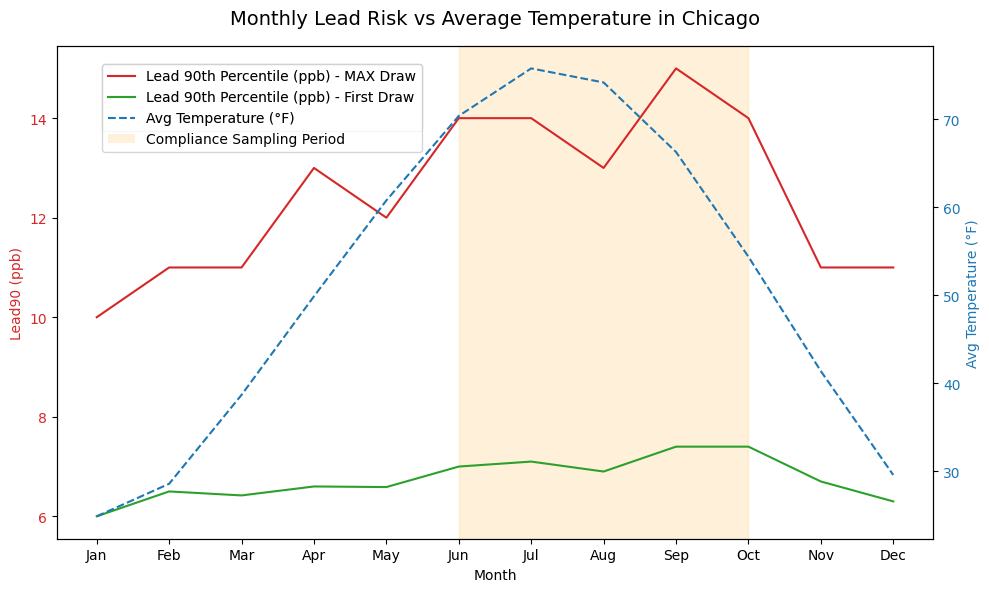

In [59]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Plot Lead90 Max (Red solid line) ---
color_max = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Lead90 (ppb)', color=color_max)
lead_max_line, = ax1.plot(
    monthly_lead_max['Month'],
    monthly_lead_max['Lead90'],
    color=color_max,
    label='Lead 90th Percentile (ppb) - MAX Draw'
)

# --- Plot Lead90 First (Green solid line) ---
color_first = 'tab:green'
lead_first_line, = ax1.plot(
    monthly_lead_first['Month'],
    monthly_lead_first['Lead90'],
    color=color_first,
    label='Lead 90th Percentile (ppb) - First Draw'
)
ax1.tick_params(axis='y', labelcolor=color_max)

# --- Compliance Sampling Period (e.g., June–September shaded region) ---
compliance_start = 6.5  # June
compliance_end = 9.5    # September
ax1.axvspan(compliance_start - 0.5, compliance_end + 0.5, color='orange', alpha=0.15, label='Compliance Sampling Period')

# --- Plot Avg Temperature (Blue dashed line) on secondary y-axis ---
ax2 = ax1.twinx()
color_temp = 'tab:blue'
ax2.set_ylabel('Avg Temperature (°F)', color=color_temp)
temp_line, = ax2.plot(
    monthly_lead_max['Month'],
    monthly_lead_max['AvgTemp'],
    color=color_temp,
    linestyle='--',
    label='Avg Temperature (°F)'
)
ax2.tick_params(axis='y', labelcolor=color_temp)

# --- Title, xticks, legend ---
fig.suptitle("Monthly Lead Risk vs Average Temperature in Chicago", fontsize=14)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Combine all legend handles
fig.legend(
    handles=[lead_max_line, lead_first_line, temp_line],
    loc='upper left',
    bbox_to_anchor=(0.1, 0.9)
)
# Add shaded legend entry manually (axvspan doesn't auto-include)
from matplotlib.patches import Patch
shaded_patch = Patch(facecolor='orange', alpha=0.15, label='Compliance Sampling Period')
fig.legend(handles=[lead_max_line, lead_first_line, temp_line, shaded_patch], loc='upper left', bbox_to_anchor=(0.1, 0.9))

fig.tight_layout()
plt.show()

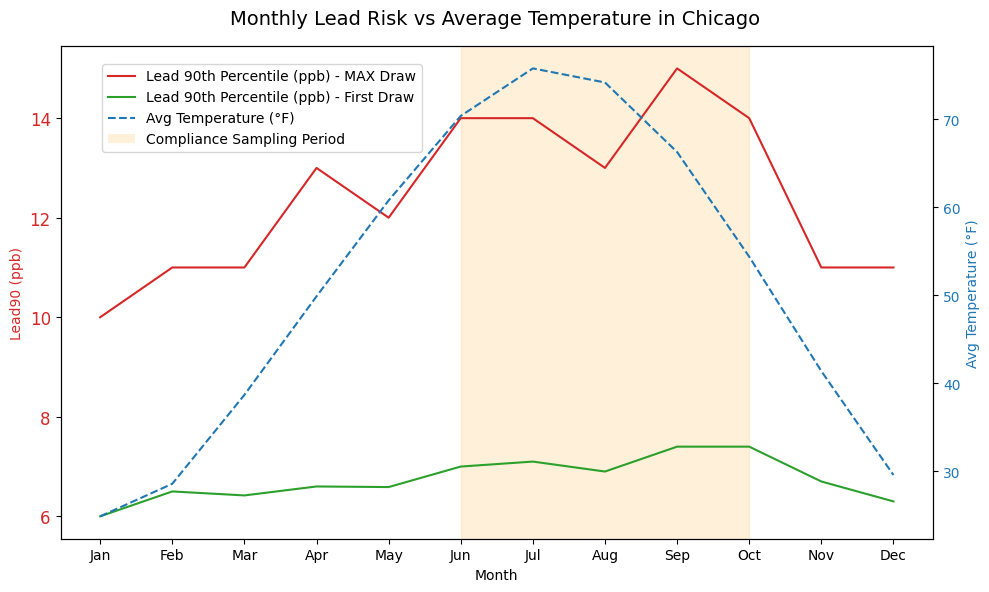

In [60]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Plot Lead90 Max (Red solid line) ---
color_max = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Lead90 (ppb)', color=color_max)
lead_max_line, = ax1.plot(
    monthly_lead_max['Month'],
    monthly_lead_max['Lead90'],
    color=color_max,
    label='Lead 90th Percentile (ppb) - MAX Draw'
)

# --- Plot Lead90 First (Green solid line) ---
color_first = 'tab:green'
lead_first_line, = ax1.plot(
    monthly_lead_first['Month'],
    monthly_lead_first['Lead90'],
    color=color_first,
    label='Lead 90th Percentile (ppb) - First Draw'
)

# Make the left y-axis tick labels bigger
ax1.tick_params(axis='y', labelcolor=color_max, labelsize=12)  # <--- Bigger ticks here

# --- Compliance Sampling Period (June–September shaded region) ---
compliance_start = 6.5
compliance_end = 9.5
ax1.axvspan(compliance_start - 0.5, compliance_end + 0.5, color='orange', alpha=0.15, label='Compliance Sampling Period')

# --- Plot Avg Temperature (Blue dashed line) on secondary y-axis ---
ax2 = ax1.twinx()
color_temp = 'tab:blue'
ax2.set_ylabel('Avg Temperature (°F)', color=color_temp)
temp_line, = ax2.plot(
    monthly_lead_max['Month'],
    monthly_lead_max['AvgTemp'],
    color=color_temp,
    linestyle='--',
    label='Avg Temperature (°F)'
)

# Keep right y-axis labels normal size (optional: can also make bigger)
ax2.tick_params(axis='y', labelcolor=color_temp)

# --- Title, xticks, legend ---
fig.suptitle("Monthly Lead Risk vs Average Temperature in Chicago", fontsize=14)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Combine all legend handles
from matplotlib.patches import Patch
shaded_patch = Patch(facecolor='orange', alpha=0.15, label='Compliance Sampling Period')

fig.legend(
    handles=[lead_max_line, lead_first_line, temp_line, shaded_patch],
    loc='upper left',
    bbox_to_anchor=(0.1, 0.9)
)

fig.tight_layout()
plt.show()

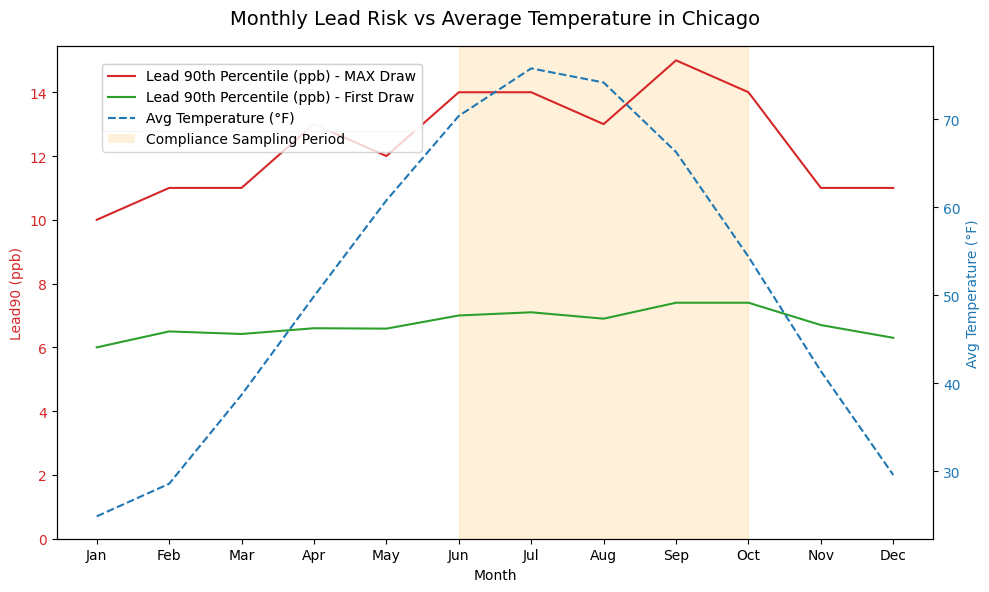

In [61]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Plot Lead90 Max (Red solid line) ---
color_max = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Lead90 (ppb)', color=color_max)
lead_max_line, = ax1.plot(
    monthly_lead_max['Month'],
    monthly_lead_max['Lead90'],
    color=color_max,
    label='Lead 90th Percentile (ppb) - MAX Draw'
)

# --- Plot Lead90 First (Green solid line) ---
color_first = 'tab:green'
lead_first_line, = ax1.plot(
    monthly_lead_first['Month'],
    monthly_lead_first['Lead90'],
    color=color_first,
    label='Lead 90th Percentile (ppb) - First Draw'
)

# Set y-axis for Lead to start at 0
ax1.set_ylim(bottom=0)
ax1.tick_params(axis='y', labelcolor=color_max)

# --- Compliance Sampling Period (e.g., June–September shaded region) ---
compliance_start = 6.5  # June
compliance_end = 9.5    # September
ax1.axvspan(compliance_start - 0.5, compliance_end + 0.5, color='orange', alpha=0.15, label='Compliance Sampling Period')

# --- Plot Avg Temperature (Blue dashed line) on secondary y-axis ---
ax2 = ax1.twinx()
color_temp = 'tab:blue'
ax2.set_ylabel('Avg Temperature (°F)', color=color_temp)
temp_line, = ax2.plot(
    monthly_lead_max['Month'],
    monthly_lead_max['AvgTemp'],
    color=color_temp,
    linestyle='--',
    label='Avg Temperature (°F)'
)
ax2.tick_params(axis='y', labelcolor=color_temp)

# --- Title, xticks, legend ---
fig.suptitle("Monthly Lead Risk vs Average Temperature in Chicago", fontsize=14)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Combine all legend handles
fig.legend(
    handles=[lead_max_line, lead_first_line, temp_line],
    loc='upper left',
    bbox_to_anchor=(0.1, 0.9)
)
# Add shaded legend entry manually (axvspan doesn't auto-include)
from matplotlib.patches import Patch
shaded_patch = Patch(facecolor='orange', alpha=0.15, label='Compliance Sampling Period')
fig.legend(handles=[lead_max_line, lead_first_line, temp_line, shaded_patch], loc='upper left', bbox_to_anchor=(0.1, 0.9))

fig.tight_layout()
plt.show()

# Permutation Test: Lead90 vs AvgTemp

## Objective  
To test whether there is a significant relationship between the 90th percentile of lead levels (`Lead90`) and average monthly temperature (`AvgTemp`) using a permutation-based Euclidean distance test.

---

### 1. Null Hypothesis (H₀)  
There is **no relationship** between `Lead90` and `AvgTemp`. Any observed similarity is due to **random chance**.

### 2. Alternative Hypothesis (H₁)  
There **is a significant relationship** between `Lead90` and `AvgTemp`. The observed alignment is **not** due to random variation.

---

### 3. Test Statistic  
**Euclidean distance**:  
\[
D = \sqrt{\sum_{i=1}^{n} (Lead90_i - AvgTemp_i)^2}
\]  
A smaller distance indicates stronger alignment between `Lead90` and `AvgTemp`.

---

### 4. Observed Test Statistic  
\[
D_{\text{observed}} = 146.0196
\]

---

### 5. Permutation Test Procedure  
1. Randomly shuffle `Lead90` values  
2. Recalculate Euclidean distance to `AvgTemp`  
3. Repeat 1000 times to create null distribution  
4. Calculate proportion of shuffled distances ≤ observed distance  

---

### 6. Result  
\[
p = \frac{\#\{D_{\text{perm}} \leq D_{\text{observed}}\}}{1000} = \frac{0}{1000} = 0.0000
\]

---

### 7. Conclusion  
**Reject the null hypothesis** (p = 0.0000).  
There is **strong statistical evidence** of a **non-random relationship** between temperature and lead levels in the water supply.  

In [62]:
import numpy as np

def euclidean_dist(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# Original distance (MAX Draw vs AvgTemp)
observed_dist = euclidean_dist(monthly_lead_max['Lead90'].values, monthly_lead_max['AvgTemp'].values)

# Run permutations
np.random.seed(42)
n_perms = 100000
distances = []
for _ in range(n_perms):
    shuffled = np.random.permutation(monthly_lead_max['Lead90'].values)
    dist = euclidean_dist(shuffled, monthly_lead_max['AvgTemp'].values)
    distances.append(dist)

# Calculate p-value
p_value = np.mean(np.array(distances) <= observed_dist)

# Print outputs
print(f"Observed Distance: {observed_dist:.4f}")
if p_value == 0:
    # Set limit based on permutations
    print(f"P-value (Euclidean): < {1/n_perms:.1e}")
else:
    print(f"P-value (Euclidean): {p_value:.4e}")

Observed Distance: 146.0196
P-value (Euclidean): 6.1000e-04


If lead levels increase with rising temperature (especially May–Sep), it suggests a correlation potentially due to chemical reactions in pipes, increased water demand, or environmental leaching — reinforcing the case for seasonal intervention policies.

# Heatmap of Lead Levels Across Months and ZIPs

## Goal  
Explore monthly/seasonal lead contamination patterns across ZIP codes to identify **persistent hotspots**, **seasonal spikes**, and **summer-vulnerable neighborhoods**.  

---

### Part 1: Monthly Heatmap by ZIP Code  
**What the Code Does**  
- Calculates `Lead90` (90th percentile lead level) per ZIP/month  
- Caps extremes at 99th percentile to reduce distortion  
- Creates ZIP × Month matrix (rows = ZIPs, columns = Jan–Dec)  
- Plots heatmap with red color scale  

**How to Read It**  
- **Rows**: ZIPs sorted by overall lead risk (highest → lowest)  
- **Columns**: Months (Jan–Dec)  
- **Darker red**: Higher extreme lead contamination  
- **Patterns**:  
  - Summer spikes (Jun–Aug) in specific ZIPs  
  - Stable low-risk ZIPs (consistent pale colors)  

---

### Part 2: Year-by-Year ZIP Heatmaps  
**What the Code Does**  
- Repeats Part 1 for **2016–2024**  
- Ensures consistent ZIP order and caps extremes at 98th percentile/year  

**Interpretation**  
- **Persistent hotspots**:  
  - *60623, 60629*: High risk across all years  
- **Emerging trends**:  
  - *60608*: Rising risk post-2020  
- **Stabilizing areas**:  
  - *60632*: Reduced risk after 2022  

---

### Part 3: Seasonality Score by ZIP (Warm vs. Cold Bias)  
**What the Code Does**  
- Tags samples as **Warm** (Jun–Sep) or **Cold** (Oct–May)  
- Computes `Seasonality Score` = `Warm Lead90 / Cold Lead90`  
- Ranks ZIPs by score  

**Interpretation**  
- **Score > 1**: Summer-biased risk  
  - *60605*: Extreme outlier (score = 2.4)  
- **Typical range**: 0.8–1.7 (moderate seasonal shifts)  
- **Score < 1**: Winter-biased risk (rare)  

---

## Key Insight  
**Prioritize interventions based on risk type**:  
1. **Persistent hotspots** (e.g., 60623): Year-round monitoring  
2. **Summer-sensitive ZIPs** (e.g., 60605): Targeted warm-season alerts  
3. **Stabilizing areas**: Maintain routine checks  

This layered approach supports dynamic, data-driven public health strategies.

## Monthly ZIP-Heatmap of 90th Percentile Lead

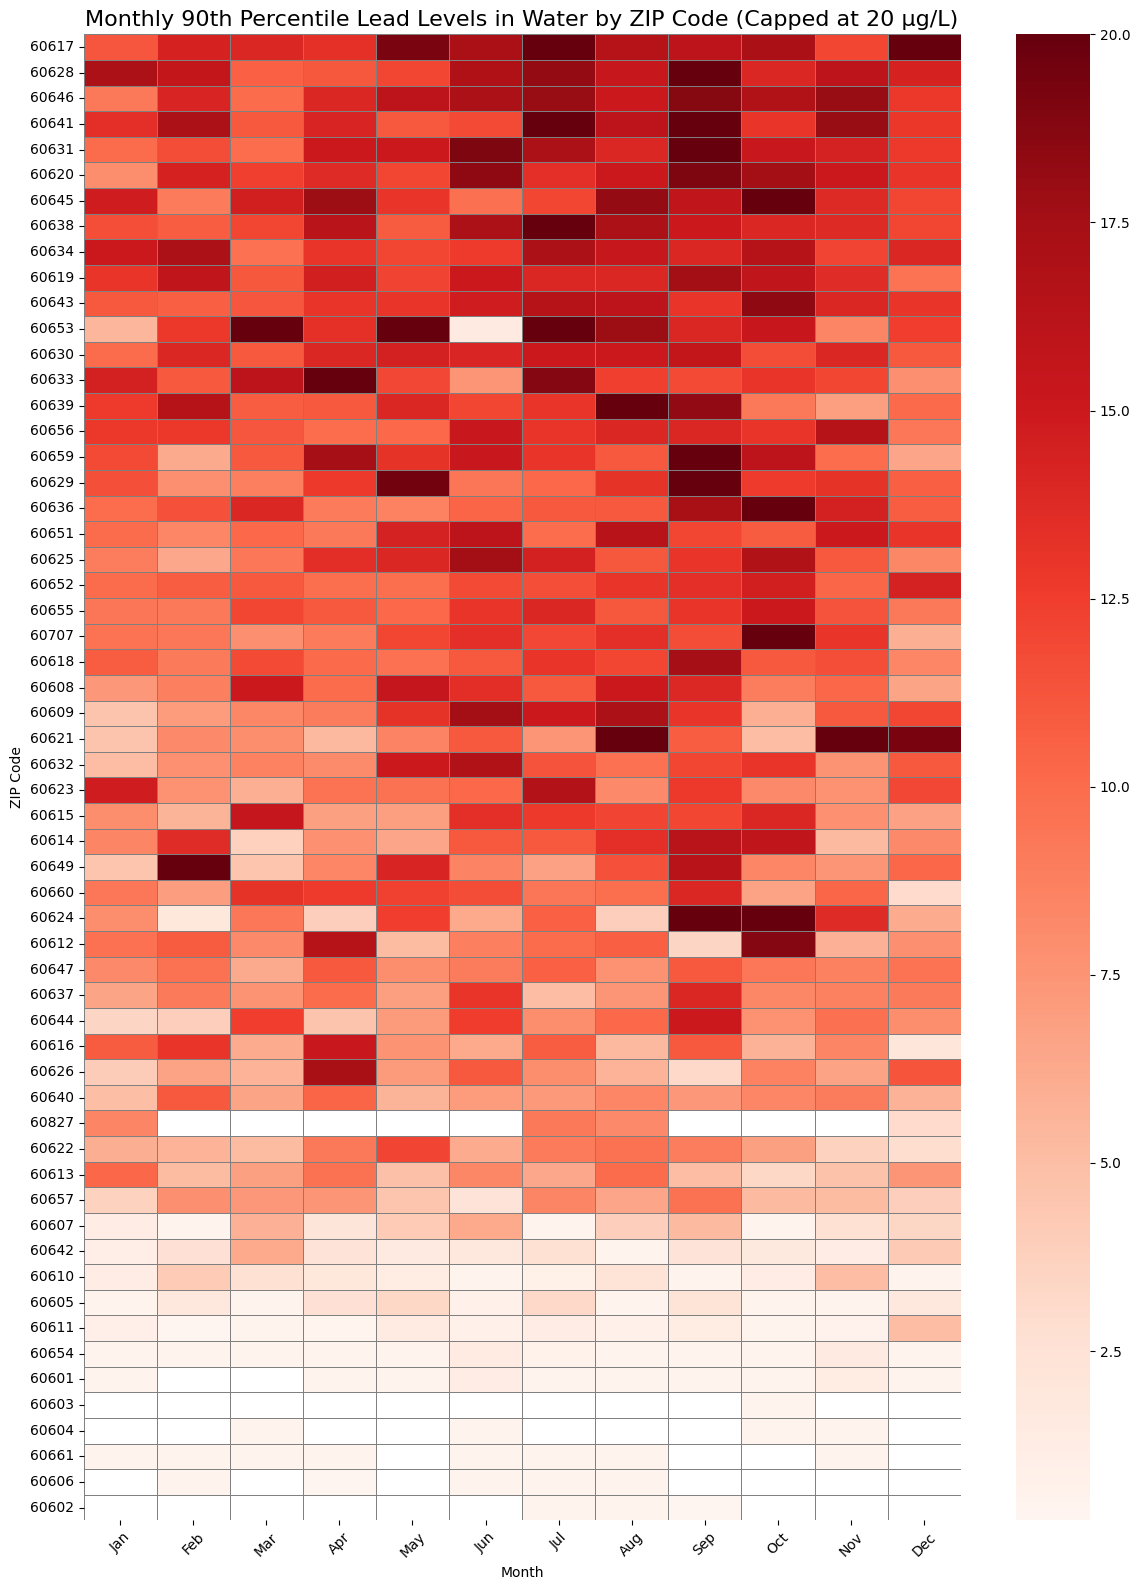

In [63]:
# Prep data: group by ZIP and Month
seasonal_grid = df.groupby(['ZIP', 'Month'])['Max'].quantile(0.9).reset_index()
seasonal_grid.columns = ['ZIP', 'Month', 'Lead90']

# Pivot to make ZIPs as rows, Months as columns
heatmap_data = seasonal_grid.pivot(index='ZIP', columns='Month', values='Lead90')

heatmap_data = heatmap_data.clip(upper=20)

# Sort ZIPs by overall average lead
heatmap_data['ZIP_Mean'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values('ZIP_Mean', ascending=False).drop(columns='ZIP_Mean')

# Plot heatmap
plt.figure(figsize=(12, 16))
sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, linecolor='gray', annot=False)
plt.title("Monthly 90th Percentile Lead Levels in Water by ZIP Code (Capped at 20 µg/L)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("ZIP Code")
plt.xticks(ticks=np.arange(12)+0.5, labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.tight_layout()
plt.show()

## Year-by-Year Heatmaps (ZIP × Month, per Year)

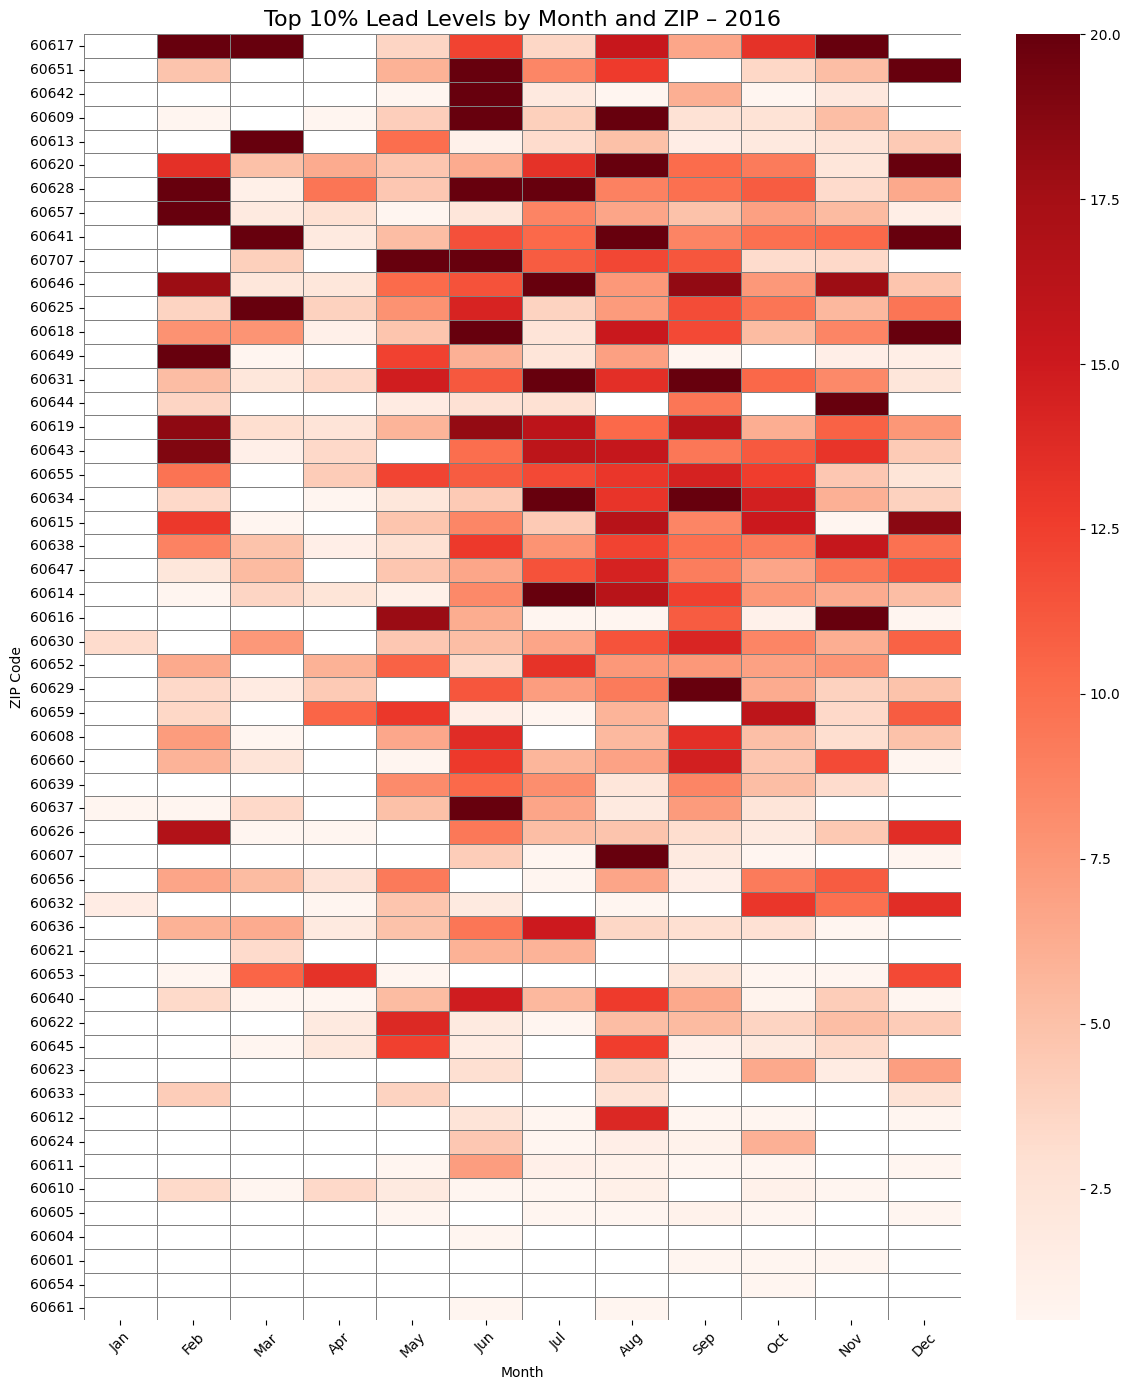

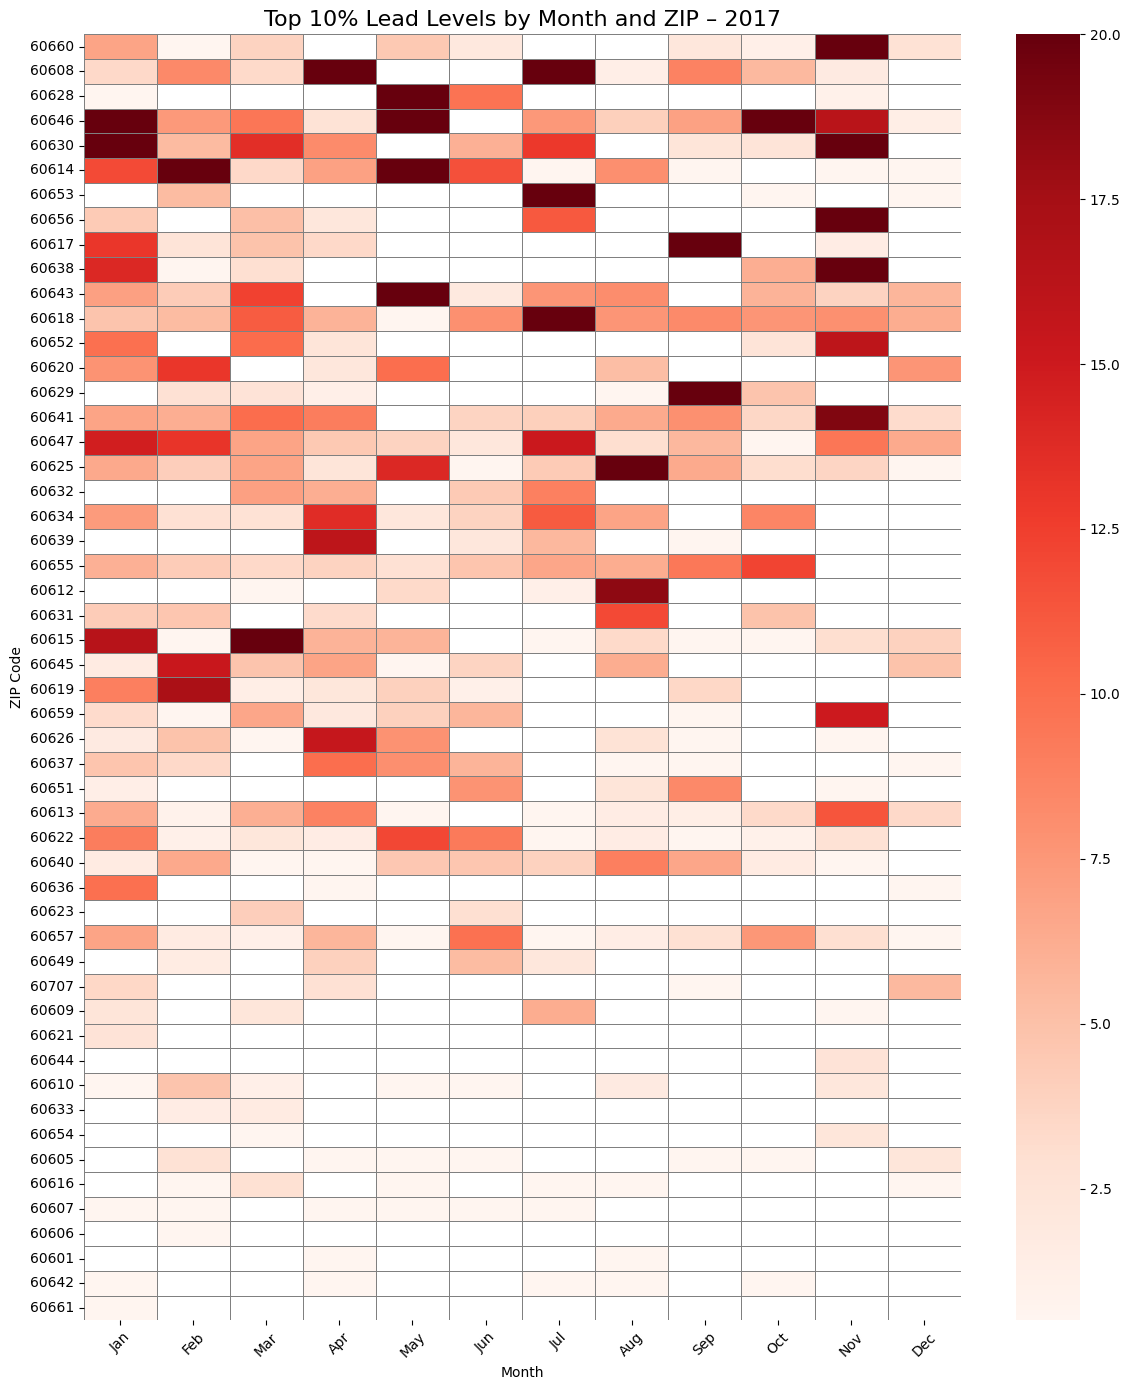

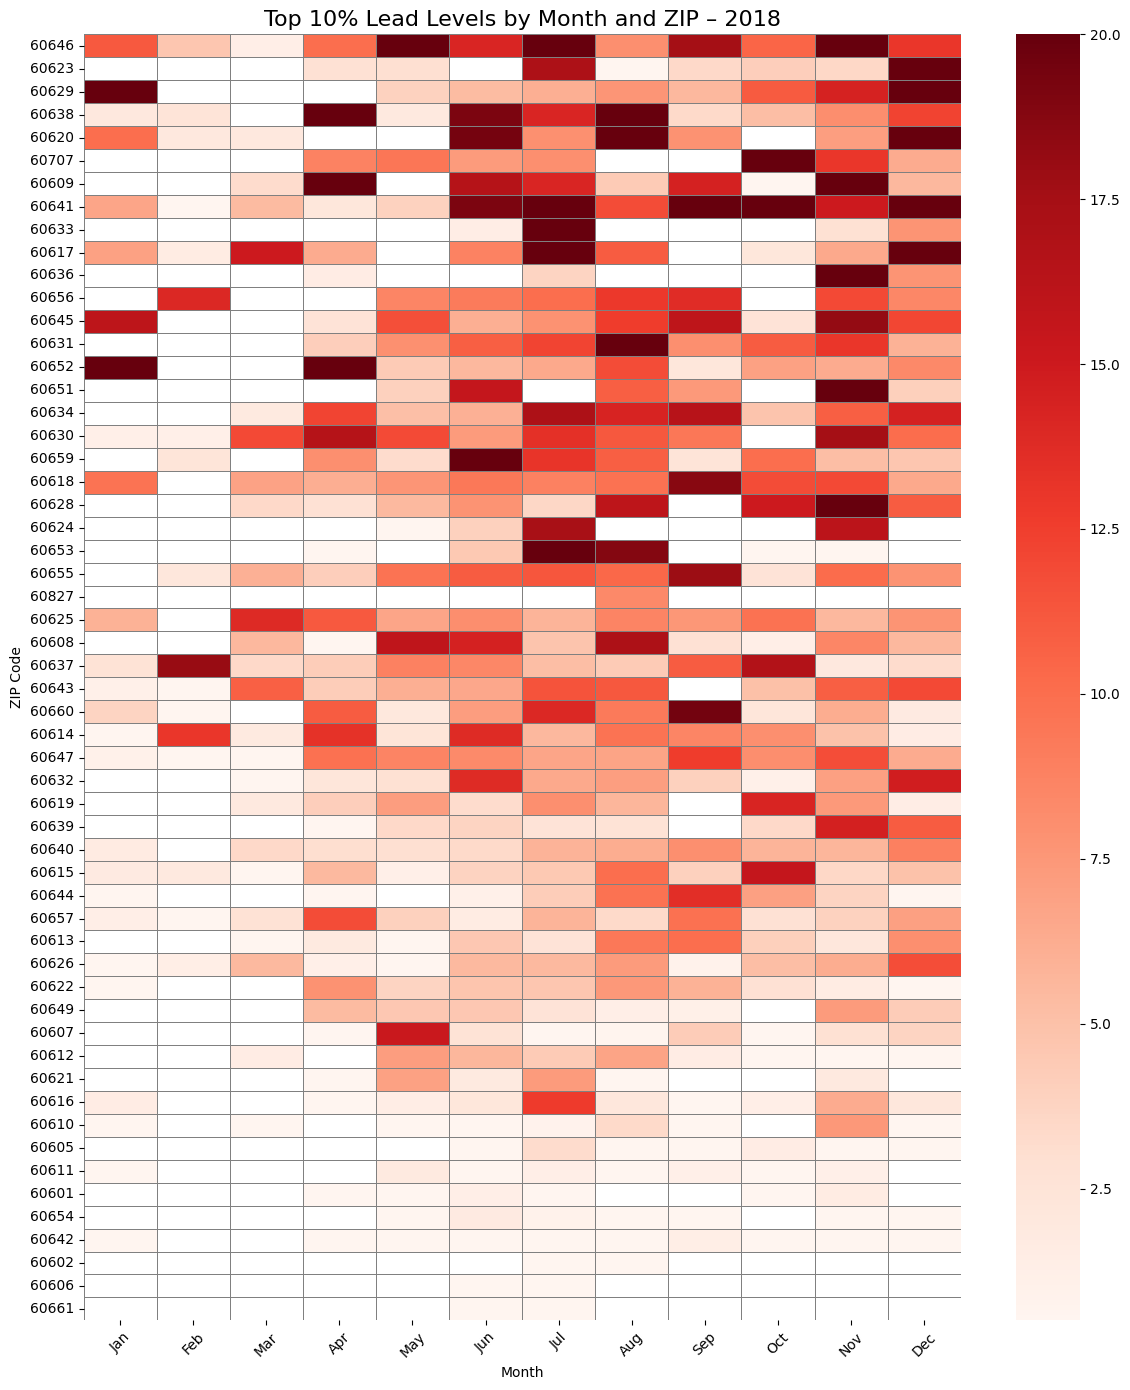

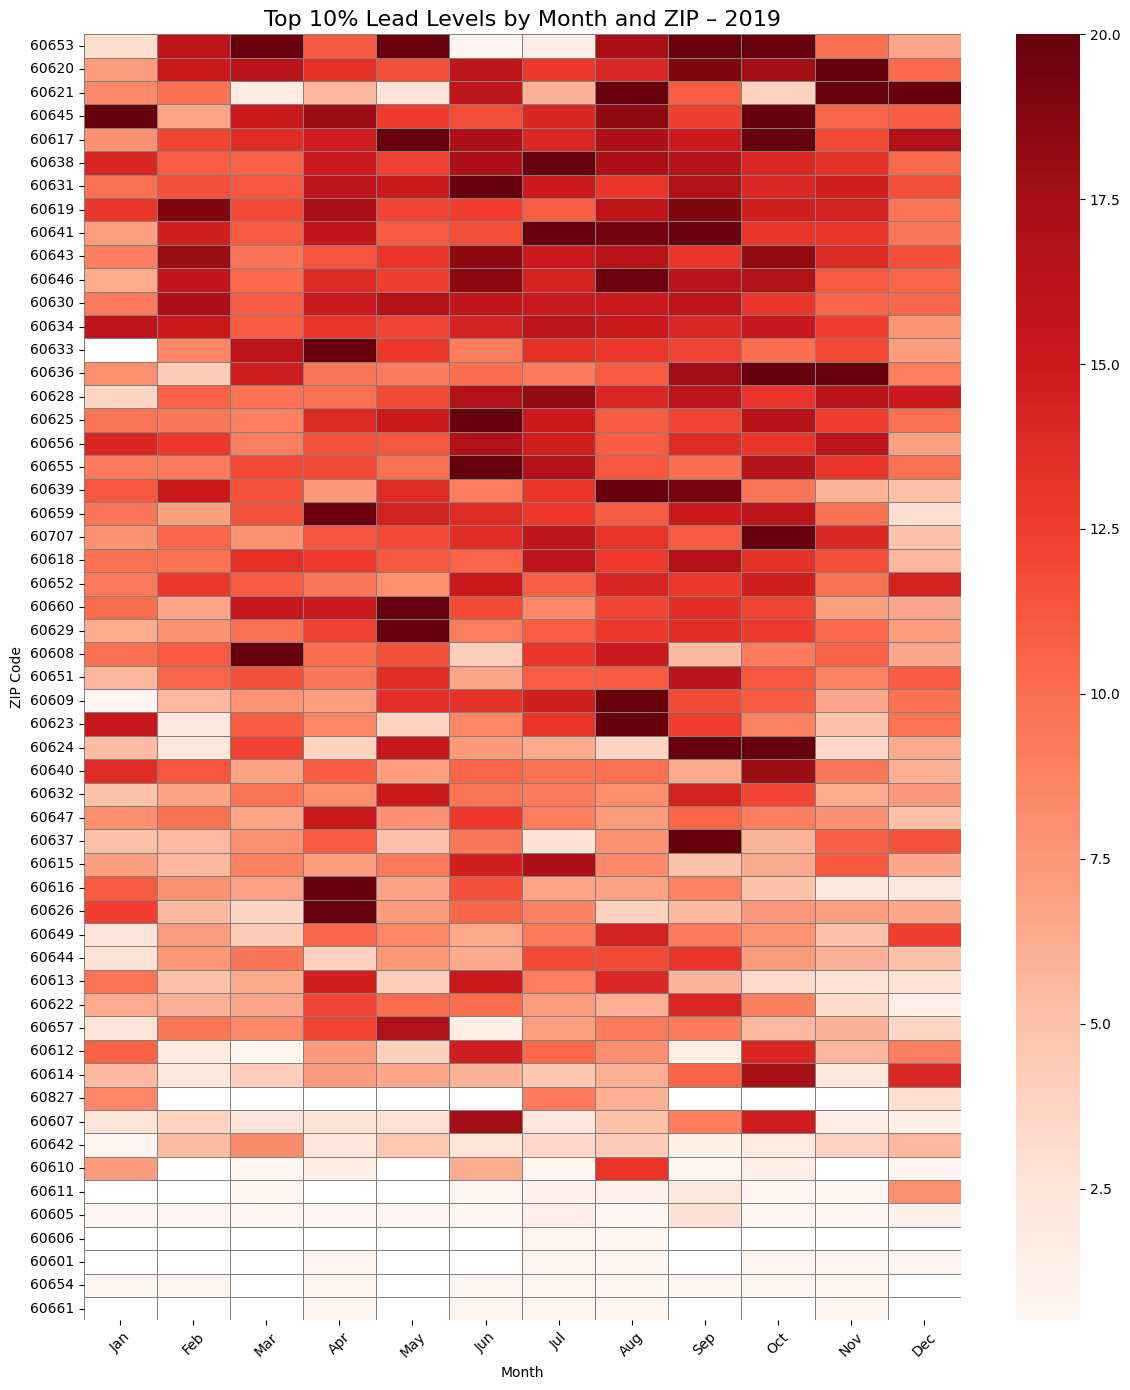

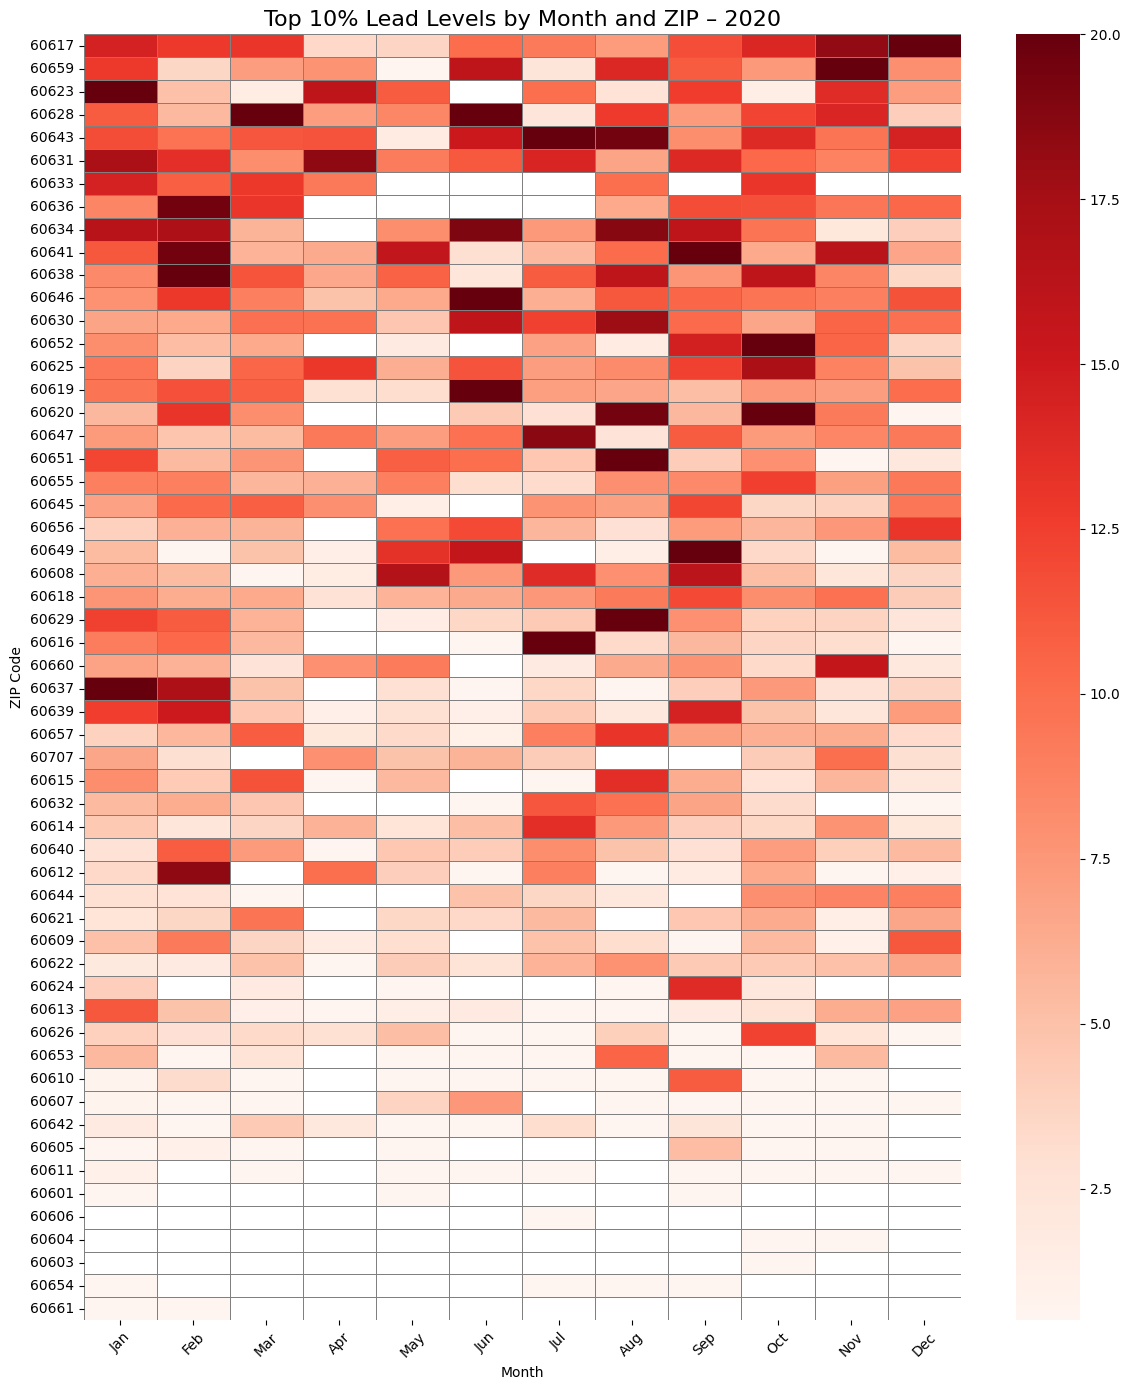

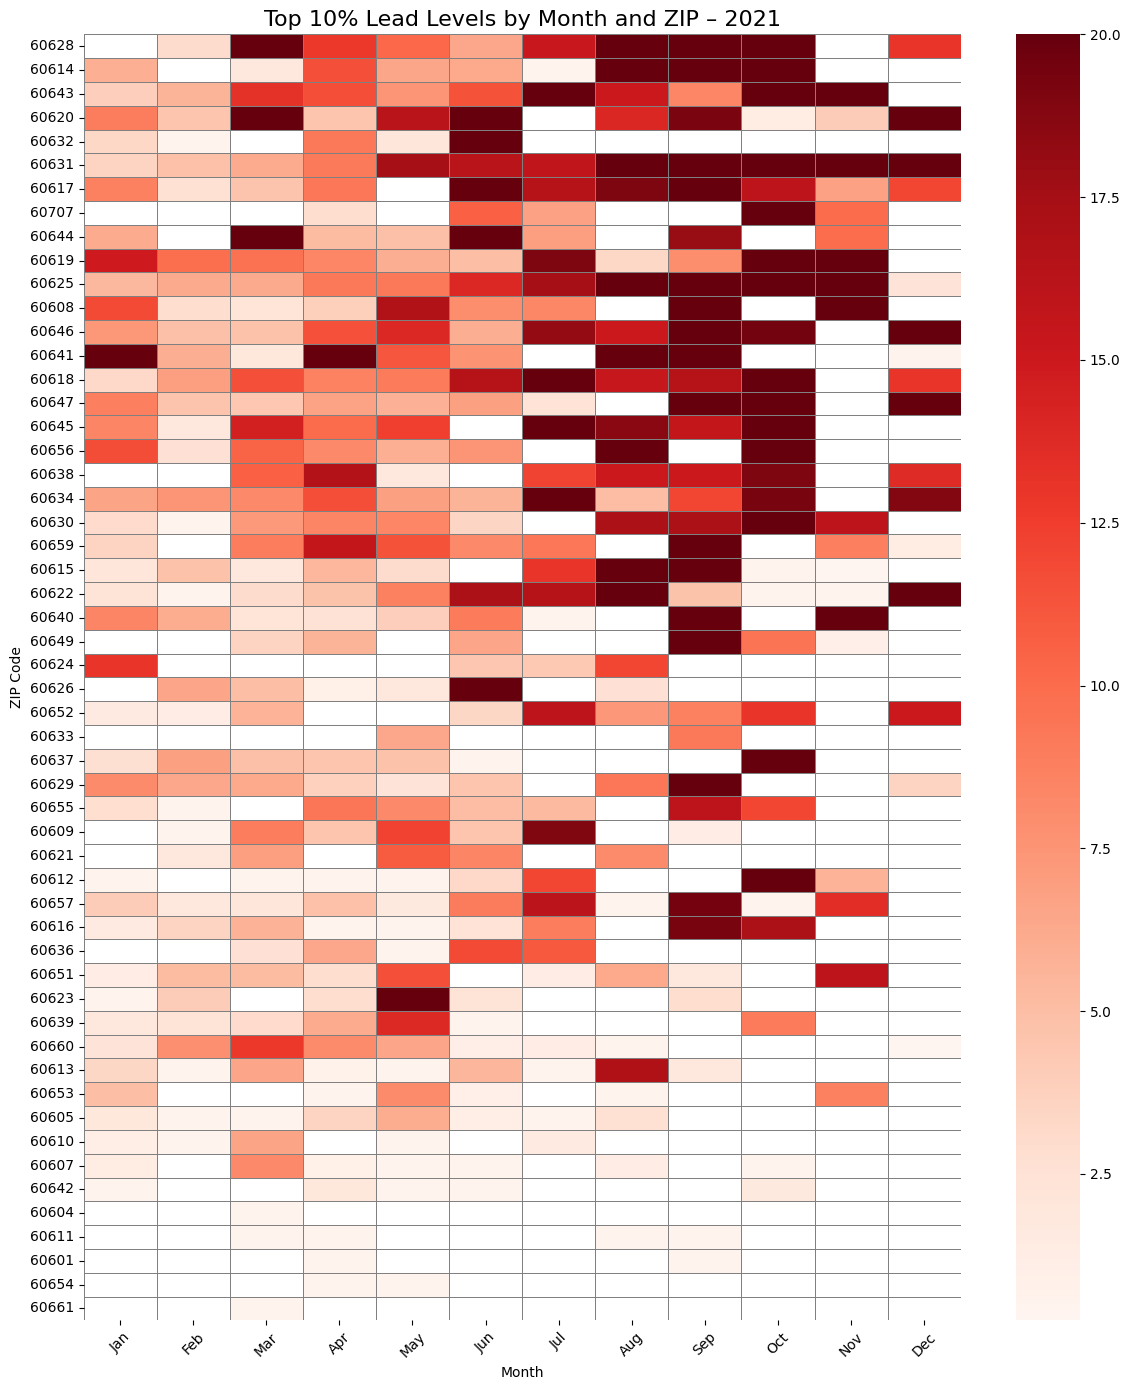

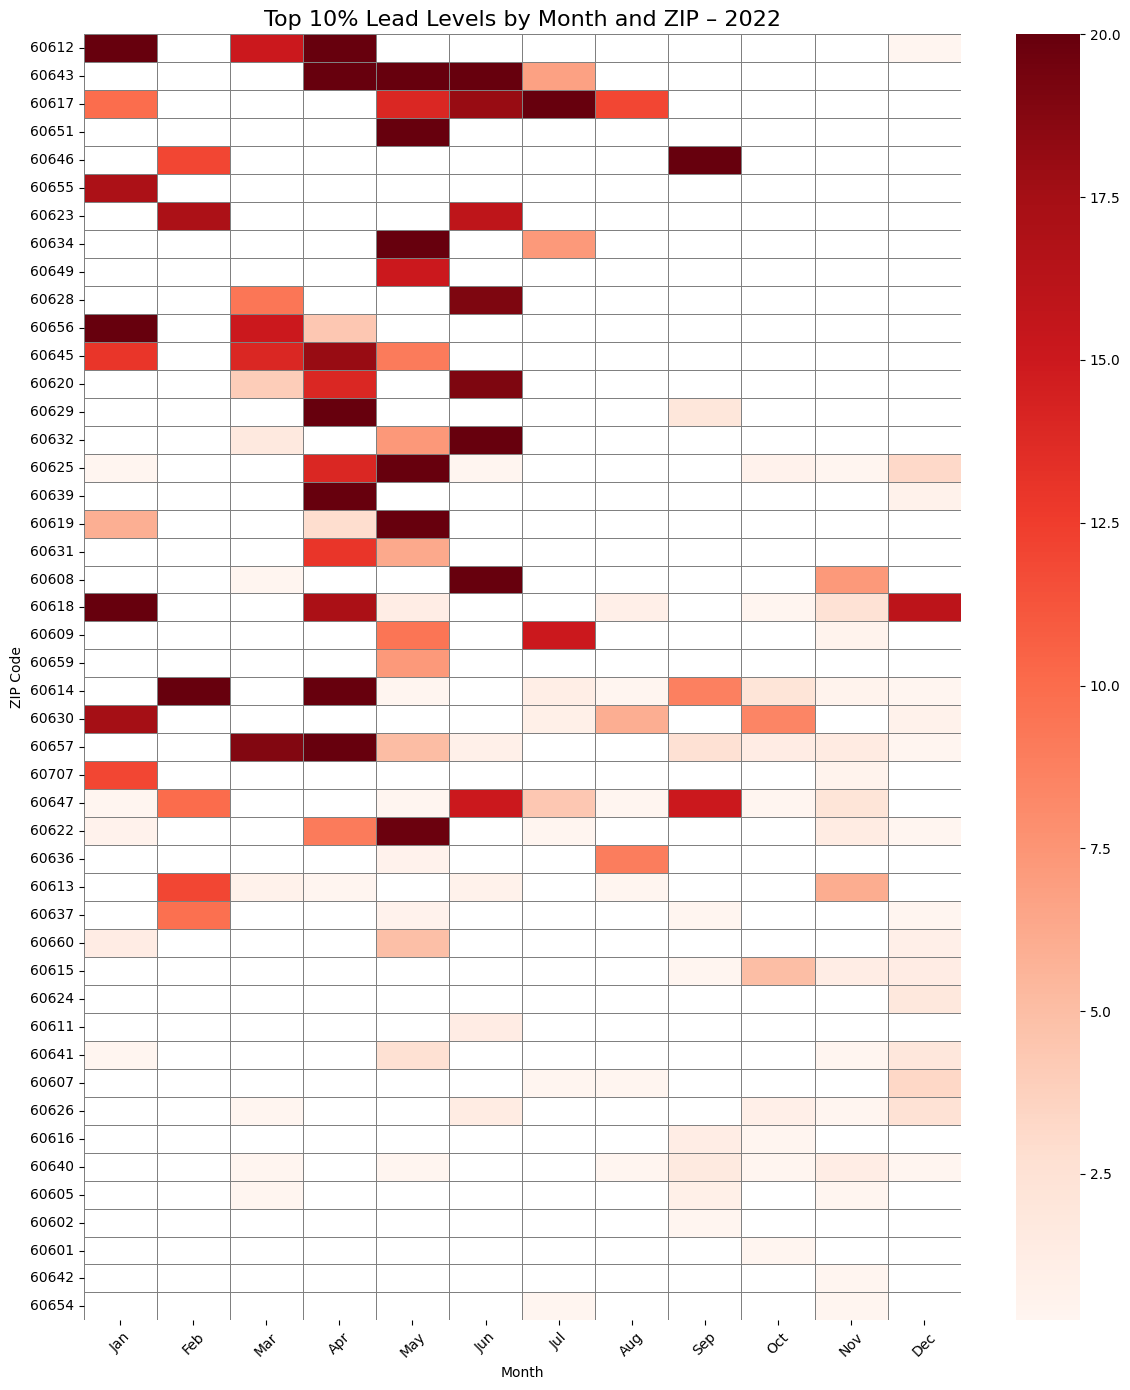

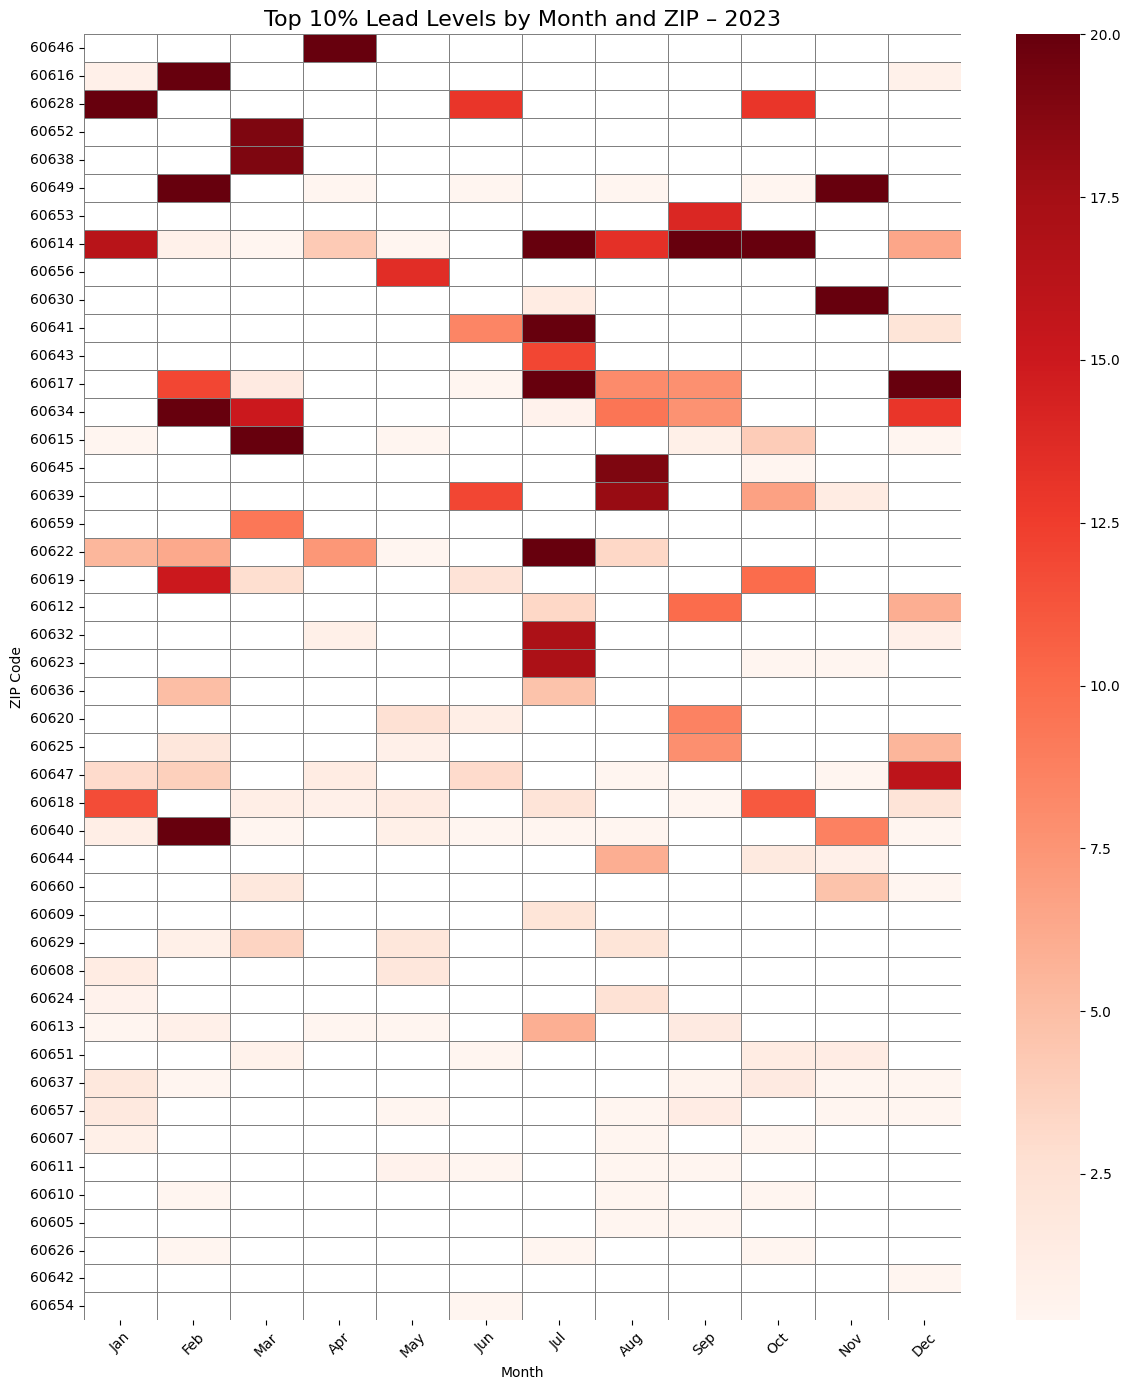

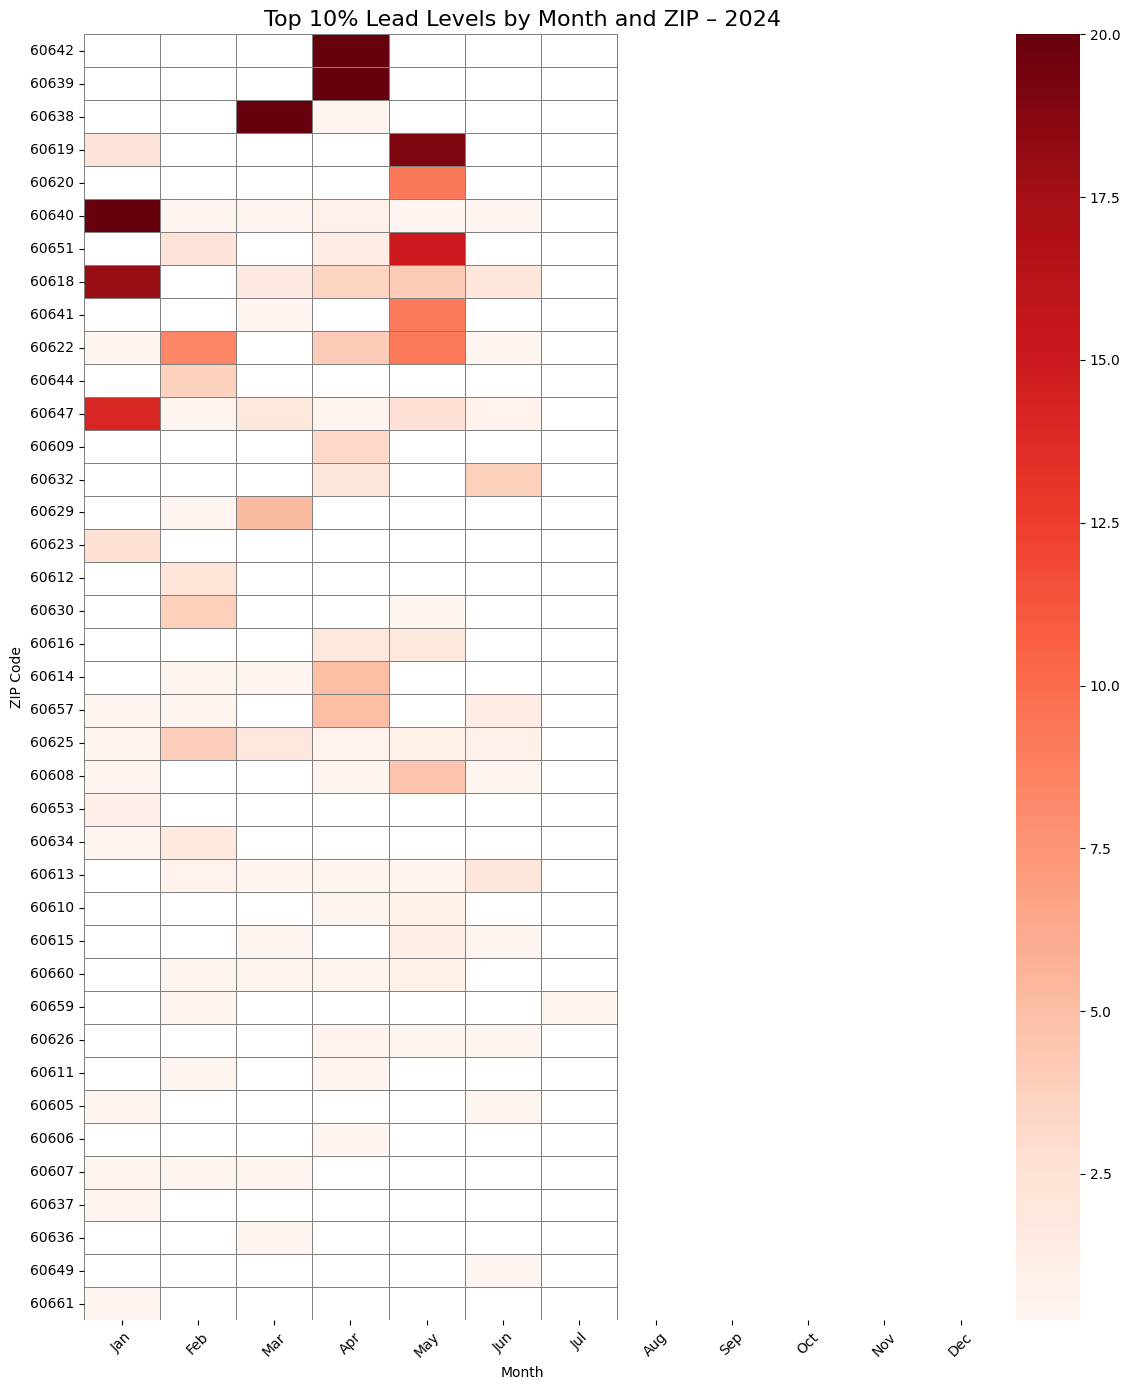

In [64]:
# Extract Year and Month
df['Year'] = df['Sample Date'].dt.year
df['Month'] = df['Sample Date'].dt.month

# Filter for meaningful recent years only
years = sorted(df['Year'].dropna().unique())
years = [y for y in years if y >= 2016]  # Tweak as needed

# Create heatmap per year
for year in years:
    seasonal_year = df[df['Year'] == year].groupby(['ZIP', 'Month'])['Max'].quantile(0.9).reset_index()
    seasonal_pivot = seasonal_year.pivot(index='ZIP', columns='Month', values='Max')

    # Sort ZIPs by average for consistent ordering
    seasonal_pivot['ZIP_Mean'] = seasonal_pivot.mean(axis=1)
    seasonal_pivot = seasonal_pivot.sort_values('ZIP_Mean', ascending=False).drop(columns='ZIP_Mean')

    vmax = 20
    seasonal_pivot_clipped = seasonal_pivot.clip(upper=20)


    # Plot heatmap
    plt.figure(figsize=(12, 14))
    sns.heatmap(seasonal_pivot_clipped, cmap='Reds', linewidths=0.5, linecolor='gray', vmax=vmax)
    plt.title(f"Top 10% Lead Levels by Month and ZIP – {year}", fontsize=16)
    plt.xlabel("Month")
    plt.ylabel("ZIP Code")
    plt.xticks(ticks=np.arange(12) + 0.5, labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    plt.tight_layout()
    plt.show()

## ZIP-Level Seasonality Score (Warm/Cool Bias)

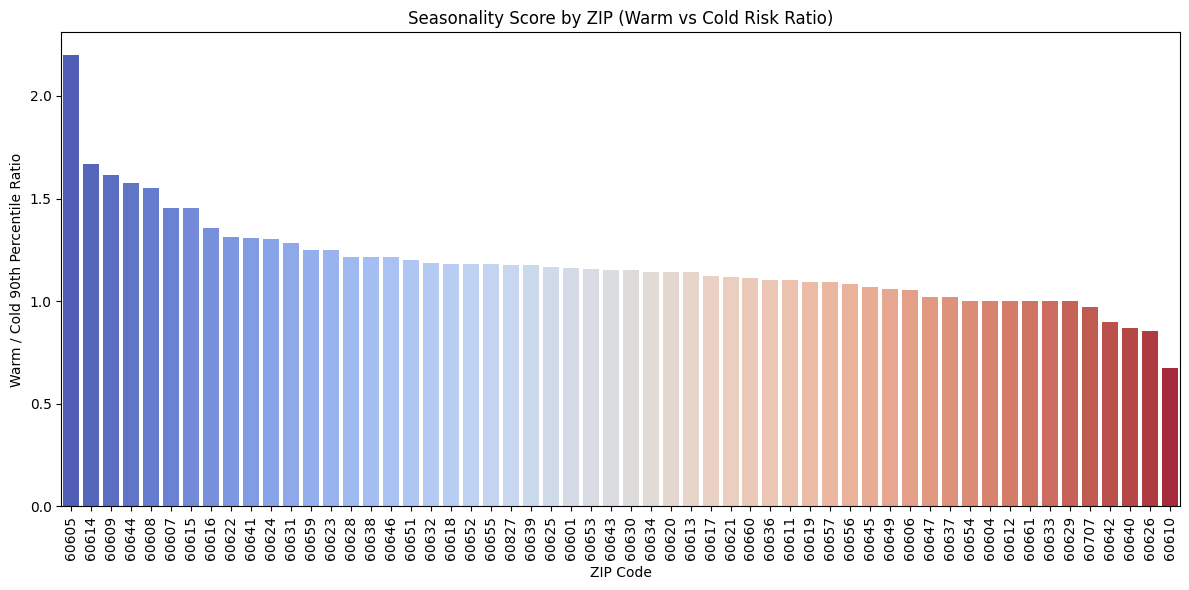

In [65]:
# Tag season
df['Season'] = df['Month'].apply(lambda m: 'Warm' if m in [6,7,8,9] else 'Cold')

# 90th percentile per ZIP per Season
seasonal_stats = df.groupby(['ZIP', 'Season'])['Max'].quantile(0.9).unstack()

# Compute risk score (warm/cold ratio)
seasonal_stats['SeasonalityScore'] = seasonal_stats['Warm'] / seasonal_stats['Cold']
seasonal_stats = seasonal_stats.dropna()

# Sort and plot
seasonal_stats_sorted = seasonal_stats.sort_values('SeasonalityScore', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=seasonal_stats_sorted.index, y=seasonal_stats_sorted['SeasonalityScore'], palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Seasonality Score by ZIP (Warm vs Cold Risk Ratio)")
plt.ylabel("Warm / Cold 90th Percentile Ratio")
plt.xlabel("ZIP Code")
plt.tight_layout()
plt.show()

> A score >1 = ZIP is worse in summer → could indicate heat sensitivity or aging infrastructure.

> Score <1 = higher in winter? Could mean other issues like stagnation or heating interactions.

# Seasonality Score Analysis: Yearly, Demographic, and Educational Views

## Goal  
This analysis explores how lead contamination risk varies seasonally across years, property age groups, and elementary school districts. The **Seasonality Score** (Warm/Cold ratio) quantifies how much worse lead levels are during warmer months.    

---

### Part 1: Seasonality Score by Year  
**What the Code Does**  
- **Groups** samples by year and season  
- **Computes** 90th percentile lead levels (`Lead90`) for warm/cold seasons  
- **Calculates** annual scores: `Warm Lead90 / Cold Lead90`  
- **Plots** yearly scores as a bar chart  

**Interpretation**  
| Year | Score | Trend |  
|------|-------|-------|  
| 2021 |   | **Peak seasonal effect** |  
| 2016 |   | Moderate |  
| 2022 |   | Moderate |  
| 2023 |   | Mild elevation |  
| 2020 |   | Mild elevation |  
| 2017 |   | Low |  
| 2018 |   | Low |  
| 2024 |   | **Lowest effect** |  

**Takeaway**: No consistent upward trend, but **2021 is a critical outlier** requiring investigation.  

---

### Part 2: Seasonality Score by Property Age Group  
**What the Code Does**  
- **Bins** properties into age groups (e.g., 0–25, 26–50 years)  
- **Calculates** warm/cold risk ratio per group  

**Interpretation**  
| Age Group (Years) | Seasonality  |  
|--------------------|-------------------|  
| 26–50             | (**highest**) |  
| 0–25              |               |  
| 100+              |               |  
| 76–100            |             |  
| 51–75             |  (**lowest**) |  

**Pattern**: Mid-century homes (26–50 years) show the strongest seasonal risk, likely due to era-specific plumbing materials.

---

### Part 3: Seasonality Score by School District  
**What the Code Does**  
- **Groups** data by elementary school district  
- **Computes** seasonal scores and highlights top 15  

**Interpretation**  
- **HERZL Elementary**: Extreme outlier (score >30) — summer lead levels 30× higher than winter  
- **Next highest districts**: Scores <10, with most below 5  
- **Takeaway**: Seasonality is widespread but *hyper-localized* in certain districts, suggesting infrastructure "hotspots"  

---

## Key Insight  
**Seasonality isn’t uniform** — it intensifies in recent years, mid-century homes, and specific districts like HERZL. These outliers demand urgent investigation:  
- *HERZL District*: Extreme summer spikes suggest pipe corrosion or environmental factors  
- *Rising annual scores*: May require climate-resilient infrastructure updates  
- *Mid-century homes*: Prioritize seasonal pipe inspections

## Seasonality Score by year

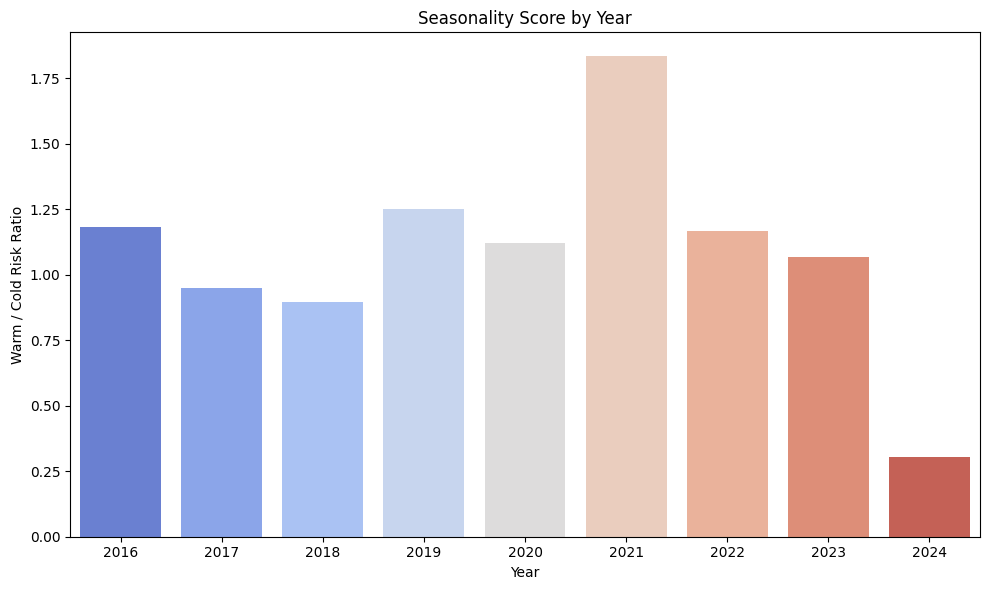

In [66]:
# Ensure 'Year' is extracted
df['Year'] = df['Sample Date'].dt.year
df['Season'] = df['Month'].apply(lambda m: 'Warm' if m in [6,7,8,9] else 'Cold')

# Group by Year and Season
year_season = df.groupby(['Year', 'Season'])['Max'].quantile(0.9).unstack()

# Seasonality Score
year_season['SeasonalityScore'] = year_season['Warm'] / year_season['Cold']
year_season = year_season.dropna()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=year_season.index.astype(str), y=year_season['SeasonalityScore'], palette='coolwarm')
plt.title("Seasonality Score by Year")
plt.ylabel("Warm / Cold Risk Ratio")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

## Seasonality Score by Property Age Group

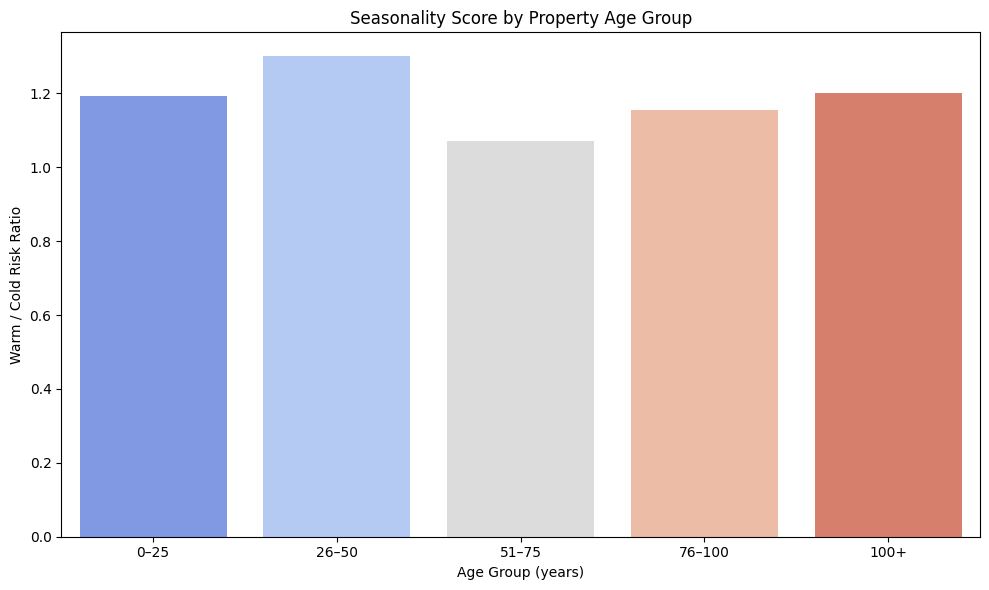

In [67]:
# Clean and bin property ages
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df = df.dropna(subset=['Age'])
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 25, 50, 75, 100, 150],
                        labels=['0–25', '26–50', '51–75', '76–100', '100+'])

# Group by AgeGroup and Season
age_season = df.groupby(['AgeGroup', 'Season'])['Max'].quantile(0.9).unstack()

# Seasonality Score
age_season['SeasonalityScore'] = age_season['Warm'] / age_season['Cold']
age_season = age_season.dropna()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=age_season.index.astype(str), y=age_season['SeasonalityScore'], palette='coolwarm')
plt.title("Seasonality Score by Property Age Group")
plt.ylabel("Warm / Cold Risk Ratio")
plt.xlabel("Age Group (years)")
plt.tight_layout()
plt.show()

## Seasonality Score by School District

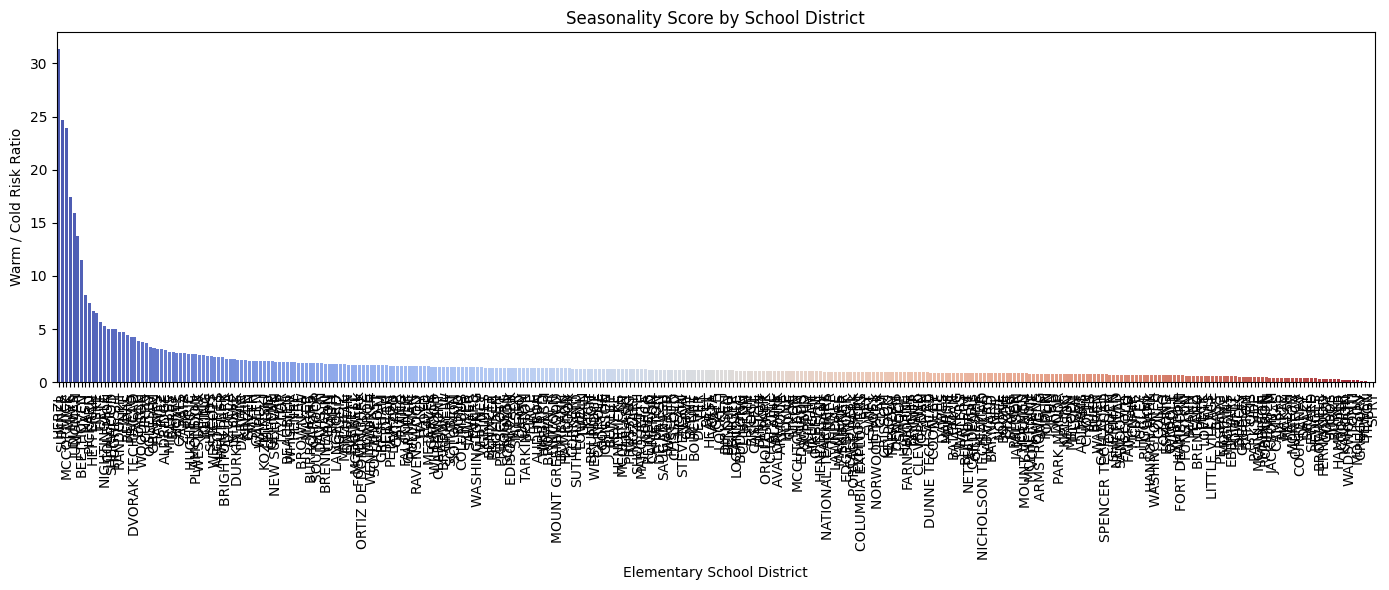

In [68]:
# Clean column name just in case
df['School District'] = df['school_elem_district'].astype(str)

# Group by school district and season
school_season = df.groupby(['School District', 'Season'])['Max'].quantile(0.9).unstack()

# Seasonality Score
school_season['SeasonalityScore'] = school_season['Warm'] / school_season['Cold']
school_season = school_season.dropna()

# Sort by score and plot
school_season_sorted = school_season.sort_values('SeasonalityScore', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=school_season_sorted.index, y=school_season_sorted['SeasonalityScore'], palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Seasonality Score by School District")
plt.ylabel("Warm / Cold Risk Ratio")
plt.xlabel("Elementary School District")
plt.tight_layout()
plt.show()

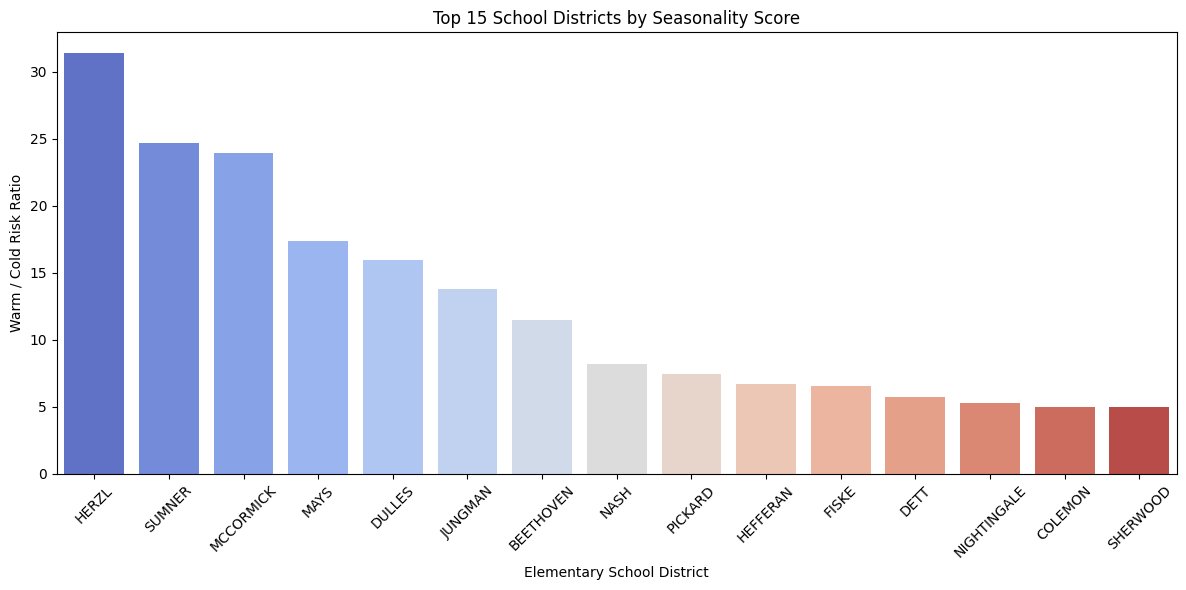

In [69]:
# Show top 15 school districts with highest seasonality scores
top15_school_season = school_season_sorted.head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top15_school_season.index, y=top15_school_season['SeasonalityScore'], palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Top 15 School Districts by Seasonality Score")
plt.ylabel("Warm / Cold Risk Ratio")
plt.xlabel("Elementary School District")
plt.tight_layout()
plt.show()